In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import warnings
import pickle
import os
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from matplotlib import rc
from tabulate import tabulate
from PIL import Image

# rc('font', family='Arial Unicode MS')

warnings.filterwarnings(action='ignore')

In [ ]:
# 한글 설정
rc('font', family='NanumBarunGothic')

In [ ]:
DIR_PATH = "/content/drive/MyDrive/ds_study/DL_project2/"

SAMPLING_RATE = 44100

TEST_MUSIC = 14 # Test 데이터 Music 총 개수
SAMPLE_MUSIC = 500 # 비교용 샘플 Music 랜덤 추출 개수

START_INDEX = 0 # 데이터프레임에서 조회할 음원 index 기본 범위 설정
END_INDEX = 99999 # 데이터프레임에서 조회할 음원 index 기본 범위 설정

#### mp3파일 경로 데이터프레임 생성

In [ ]:
# music_paths = glob.glob(DIR_PATH + "data/*.mp3")
# music_paths[:5]

In [ ]:
# total_music_paths = pd.DataFrame(music_paths, columns=["Path"])
# total_music_paths.head()

In [ ]:
total_music_paths.to_csv(DIR_PATH + 'music_paths.csv', index=False) # csv 파일로 저장

In [ ]:
total_music_paths = pd.read_csv(DIR_PATH + 'music_paths.csv')
total_music_paths.head()

Path
0  /content/drive/MyDrive/ds_study/DL_project2/da...
1  /content/drive/MyDrive/ds_study/DL_project2/da...
2  /content/drive/MyDrive/ds_study/DL_project2/da...
3  /content/drive/MyDrive/ds_study/DL_project2/da...
4  /content/drive/MyDrive/ds_study/DL_project2/da...

In [ ]:
total_music_paths.shape

(2341, 1)

#### 음원 구간별 파일 정보 저장 => "total_music_paths_trim"

In [ ]:
total_music_paths_trim = pd.read_csv(DIR_PATH + 'trim_audio_label_v1.csv')
total_music_paths_trim.head()

file name  ... order
0  1635994364508_862a7b71f7a80b2e5550ed718e332866...  ...     1
1  1635994364508_862a7b71f7a80b2e5550ed718e332866...  ...     2
2  1635994364508_862a7b71f7a80b2e5550ed718e332866...  ...     3
3  1635994364508_862a7b71f7a80b2e5550ed718e332866...  ...     4
4  1635994365521_2b1d9fe10b3d9119470e8e9fb4e20872...  ...     1

[5 rows x 4 columns]

In [ ]:
total_music_paths_trim.shape

(5898, 4)

In [ ]:
total_music_paths_trim['Path'] = DIR_PATH + 'data/trim/' + total_music_paths_trim['file name']
total_music_paths_trim.head()

file name  ...                                               Path
0  1635994364508_862a7b71f7a80b2e5550ed718e332866...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...
1  1635994364508_862a7b71f7a80b2e5550ed718e332866...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...
2  1635994364508_862a7b71f7a80b2e5550ed718e332866...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...
3  1635994364508_862a7b71f7a80b2e5550ed718e332866...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...
4  1635994365521_2b1d9fe10b3d9119470e8e9fb4e20872...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...

[5 rows x 5 columns]

In [ ]:
total_music_paths_trim.to_csv(DIR_PATH + f'test_data/df_total_path_trim.csv', index=False) # csv 파일로 저장

In [ ]:
total_music_paths_trim = pd.read_csv(DIR_PATH + f'test_data/df_total_path_trim.csv') # csv 파일 불러오기
total_music_paths_trim.shape

(5898, 5)

In [ ]:
# test1
ipd.Audio(total_music_paths_trim.loc[0, 'Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ipd.Audio(total_music_paths_trim.loc[1, 'Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ipd.Audio(total_music_paths_trim.loc[2, 'Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ipd.Audio(total_music_paths_trim.loc[3, 'Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ipd.Audio(DIR_PATH + 'data/' + total_music_paths_trim.loc[0, 'original file'] + '.mp3', rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test2
ipd.Audio(total_music_paths_trim.loc[6, 'Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ipd.Audio(total_music_paths_trim.loc[7, 'Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ipd.Audio(total_music_paths_trim.loc[8, 'Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ipd.Audio(DIR_PATH + 'data/' + total_music_paths_trim.loc[6, 'original file'] + '.mp3', rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

# 음원 특성 관련 Chroma 시각화 및 검토

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd

In [ ]:
# chromagram 시각화 함수 정의 => 'stft', 'cqt', 'cens' 옵션별 출력
def show_chromagram(music, sr, type='stft'):
  if type == 'cqt':
    chroma = librosa.feature.chroma_cqt(music, sr)
  elif type == 'cens':
    chroma = librosa.feature.chroma_cens(music, sr)
  elif type == 'stft':
    chroma = librosa.feature.chroma_stft(music, sr)
  else:
    print('type error')
    return

  seconds = len(music)/SAMPLING_RATE

  plt.figure(figsize=(15,5))
  librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
  plt.colorbar()
  plt.tight_layout()
  plt.xlabel('time')
  plt.ylabel('pitch class')
  plt.xticks(np.arange(0, seconds, seconds//10)) # 좌표간격 설정
  plt.show()

In [ ]:
# 테스트용 음원 load
music, sr = librosa.load(total_music_paths.loc[0, 'Path'], sr=SAMPLING_RATE, duration=None)

In [ ]:
# 테스트용 음원(trim) load
music_trim, sr_trim = librosa.load(total_music_paths_trim.loc[0, 'Path'], sr=SAMPLING_RATE, duration=None)

#### chroma_stft

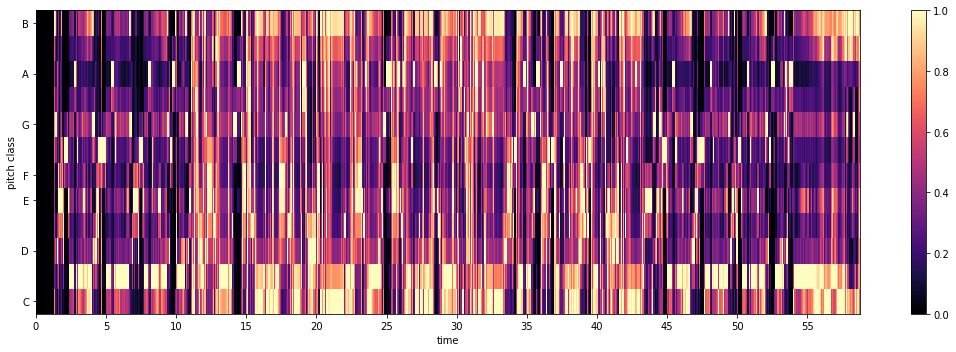

In [ ]:
show_chromagram(music, sr, 'stft')

#### chroma_cqt

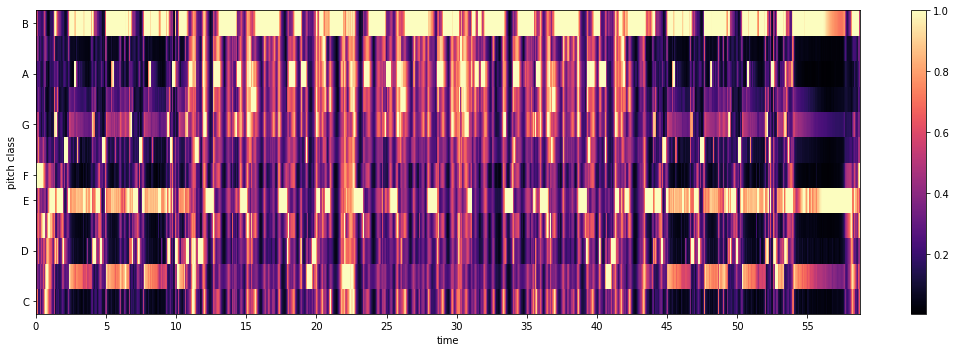

In [ ]:
show_chromagram(music, sr, 'cqt')

#### chroma_cens

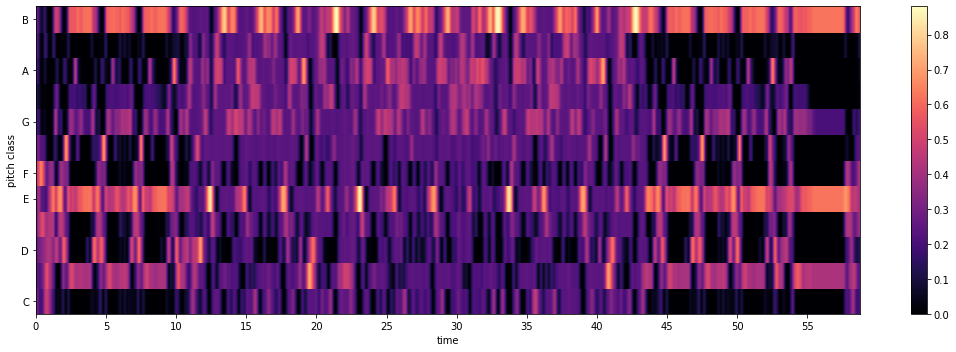

In [ ]:
show_chromagram(music, sr, 'cens')

> 12음계를 기반으로 위 3가지가 각각의 음원 특성을 나타내는 것을 확인함

# 데이터셋 구성

In [ ]:
# 원곡 및 유사곡 위주의 Test 데이터 파일정보 생성
test_data = pd.read_excel(DIR_PATH + 'test_data/test_data_list.xlsx', index_col=0)
test_data

Music                                               Path
1                 더더 - It’s you  /content/drive/MyDrive/ds_study/DL_project2/te...
2               MC몽 - 너에게 쓰는 편지  /content/drive/MyDrive/ds_study/DL_project2/te...
3                     와이낫 - 파랑새  /content/drive/MyDrive/ds_study/DL_project2/te...
4                   씨엔블루 - 외톨이야  /content/drive/MyDrive/ds_study/DL_project2/te...
5             요시마타 료 - Resolver  /content/drive/MyDrive/ds_study/DL_project2/te...
6               FTISLAND - 사랑앓이  /content/drive/MyDrive/ds_study/DL_project2/te...
7               TLC - No Scrubs  /content/drive/MyDrive/ds_study/DL_project2/te...
8     Ed Sheeran - Shape of you  /content/drive/MyDrive/ds_study/DL_project2/te...
9   Harold Faltermeyer - Axel F  /content/drive/MyDrive/ds_study/DL_project2/te...
10                     싸이 - 챔피언  /content/drive/MyDrive/ds_study/DL_project2/te...
11      A$ton Wyld - Next Level  /content/drive/MyDrive/ds_study/DL_project2/te...
12             에스파 - Next Level  /content/drive/MyDrive/ds_study/DL_project2/te...
13    S.E.S. - Dreams Come True  /content/drive/MyDrive/ds_study/DL_project2/te...
14       에스파 - Dreams Come True  /content/drive/MyDrive/ds_study/DL_project2/te...

In [ ]:
test_data_trim = pd.DataFrame(columns=['file name', 'original file', 'label', 'order', 'Path'])
test_data_trim['Path'] = glob.glob(DIR_PATH + 'test_data/trim/*.wav')
test_data_trim.head()

file name  ...                                               Path
0       NaN  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
1       NaN  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
2       NaN  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
3       NaN  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
4       NaN  ...  /content/drive/MyDrive/ds_study/DL_project2/te...

[5 rows x 5 columns]

In [ ]:
file_name_list = []
original_file_list = []
label_list = []
order_list = []

for idx, row in test_data_trim.iterrows():
  file_name = row['Path'].split('/')[-1]
  directory_num = int(file_name.split('_')[0])
  type_str = file_name.split('_')[1]
  order = int(file_name.split('_')[-1].split('.')[0]) + 1

  if type_str == 'org':
    original_file = test_data.loc[directory_num*2-1, 'Path'].split('/')[-1].split('.')[0]
    label = test_data.loc[directory_num*2-1, 'Music']
  else:
    original_file = test_data.loc[directory_num*2, 'Path'].split('/')[-1].split('.')[0]
    label = test_data.loc[directory_num*2, 'Music']

  # print(file_name, directory_num, type_str, order)
  file_name_list.append(file_name)
  original_file_list.append(original_file)
  label_list.append(label)
  order_list.append(order)

test_data_trim['file name'] = file_name_list
test_data_trim['original file'] = original_file_list
test_data_trim['label'] = label_list
test_data_trim['order'] = order_list

In [ ]:
test_data_trim.head()

file name  ...                                               Path
0  1_org_0.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
1  1_org_1.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
2  1_org_2.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
3  1_org_3.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
4  1_org_4.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...

[5 rows x 5 columns]

In [ ]:
# 샘플 Music 랜덤 추출
random.seed(42)

sample_index = random.sample(range(len(total_music_paths)), SAMPLE_MUSIC) # SAMPLE_MUSIC : 추출 개수
sample_index.sort()

sample_music = total_music_paths.loc[sample_index, :]
sample_music["Music"] = [f'Music_{idx}' for idx in sample_music.index]
sample_music = sample_music[['Music', 'Path']]
sample_music.head()

Music                                               Path
2    Music_2  /content/drive/MyDrive/ds_study/DL_project2/da...
3    Music_3  /content/drive/MyDrive/ds_study/DL_project2/da...
7    Music_7  /content/drive/MyDrive/ds_study/DL_project2/da...
8    Music_8  /content/drive/MyDrive/ds_study/DL_project2/da...
13  Music_13  /content/drive/MyDrive/ds_study/DL_project2/da...

#### Total_trim 데이터프레임 생성 => "df_total_trim_v0"

In [ ]:
# Test 데이터 및 전체 Music 데이터 합치기 => Total 데이터 "df_total_trim_v0" 생성
df_total_trim_v0 = pd.concat([test_data_trim, total_music_paths_trim])
df_total_trim_v0.reset_index(drop=True, inplace=True)
df_total_trim_v0.head()

file name  ...                                               Path
0  1_org_0.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
1  1_org_1.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
2  1_org_2.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
3  1_org_3.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
4  1_org_4.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...

[5 rows x 5 columns]

In [ ]:
df_total_trim_v0.tail()

file name  ...                                               Path
6034  1635985157096_435832d28265fcba7cb7eed70fd10ada...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...
6035  1635985157096_435832d28265fcba7cb7eed70fd10ada...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...
6036  1635985163517_f26217cc824086f20d9a9ccaf37ca2d3...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...
6037  1635985163517_f26217cc824086f20d9a9ccaf37ca2d3...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...
6038  1635985163517_f26217cc824086f20d9a9ccaf37ca2d3...  ...  /content/drive/MyDrive/ds_study/DL_project2/da...

[5 rows x 5 columns]

# Part 1. 유클리드 거리, 코사인 유사도, 피어슨 유사도

## 음원 특성 추출 및 유사도 비교(1차)
* 추출 특성 : Tempo 1개, Chroma 72개
* 유사도 기준 : 유클리드 거리, 코사인 유사도, 피어슨 유사도

## 음원 특성 추출

In [ ]:
# 음원 특성 추출 함수 정의(v1)
def get_features_v1(df, duration=None, offset=0.0, start_idx=START_INDEX,
                    end_idx=END_INDEX):
  df_copy = df.copy() # 데이터프레임 복사본 생성

  for idx, row in tqdm(df_copy.iterrows()):
    # index 범위 확인
    if idx < start_idx or idx > end_idx:
      continue

    # 음원 load
    music_path = row['Path']
    music, sr = librosa.load(music_path, sr=SAMPLING_RATE,
                             duration=duration, offset=offset) # 구간 설정

    # 템포 저장
    df_copy.loc[idx, 'Tempo'] = librosa.beat.tempo(music, sr=sr)

    # chroma_stft 12음계별 평균 및 분산 산출 후 저장
    chroma_stft_raw = librosa.feature.chroma_stft(music, sr)
    for i, values in enumerate(chroma_stft_raw):
      df_copy.loc[idx, f'Chroma_stft{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'Chroma_stft{i+1}_var'] = values.var() # 분산
    
    # chroma_cqt 12음계별 평균 및 분산 산출 후 저장
    chroma_cqt_raw = librosa.feature.chroma_cqt(music, sr)
    for i, values in enumerate(chroma_cqt_raw):
      df_copy.loc[idx, f'Chroma_cqt{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'Chroma_cqt{i+1}_var'] = values.var() # 분산
    
    # chroma_cens 12음계별 평균 및 분산 산출 후 저장
    chroma_cens_raw = librosa.feature.chroma_cens(music, sr)
    for i, values in enumerate(chroma_cens_raw):
      df_copy.loc[idx, f'Chroma_cens{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'Chroma_cens{i+1}_var'] = values.var() # 분산
  
  return df_copy

In [ ]:
# 전체 컬럼 스케일링 함수 정의
def get_norm(df, type='mms', start_col='Tempo'):
  df_copy = df.copy()

  if type == 'mms':
    scaler = MinMaxScaler()
  elif type == 'ss':
    scaler = StandardScaler()
  else:
    print('type error')
    return

  df_copy.loc[:, start_col:] = scaler.fit_transform(df_copy.loc[:, start_col:])
  
  return df_copy

#### 음원 특성 추출 결과 저장 => "df_total_trim_v1"

In [ ]:
df_total_trim_v1 = get_features_v1(df_total_trim_v0)

0it [00:00, ?it/s]

In [ ]:
df_total_trim_v1.head()

file name  ... Chroma_cens12_var
0  1_org_0.wav  ...          0.007403
1  1_org_1.wav  ...          0.008774
2  1_org_2.wav  ...          0.004933
3  1_org_3.wav  ...          0.007687
4  1_org_4.wav  ...          0.009618

[5 rows x 78 columns]

In [ ]:
df_total_trim_v1.shape

(6039, 78)

In [ ]:
df_total_trim_v1.to_csv(DIR_PATH + f'test_data/df_total_trim_v1.csv', index=False) # csv 파일로 저장

In [ ]:
df_total_trim_v1 = pd.read_csv(DIR_PATH + f'test_data/df_total_trim_v1.csv') # csv 파일 불러오기
df_total_trim_v1.shape

(6039, 78)

In [ ]:
df_total_trim_v1.head() # 특성 추출 결과 확인

file name  ... Chroma_cens12_var
0  1_org_0.wav  ...          0.007403
1  1_org_1.wav  ...          0.008774
2  1_org_2.wav  ...          0.004933
3  1_org_3.wav  ...          0.007687
4  1_org_4.wav  ...          0.009618

[5 rows x 78 columns]

#### 전체 컬럼 스케일링 => "df_total_trim_v1_norm"

In [ ]:
df_total_trim_v1_norm = get_norm(df_total_trim_v1, 'ss', start_col='Tempo') # MinMax 스케일링 or Standard 스케일링
df_total_trim_v1_norm.head()

file name  ... Chroma_cens12_var
0  1_org_0.wav  ...         -0.842753
1  1_org_1.wav  ...         -0.764234
2  1_org_2.wav  ...         -0.984311
3  1_org_3.wav  ...         -0.826502
4  1_org_4.wav  ...         -0.715876

[5 rows x 78 columns]

## 음원별 유사도 측정 및 비교(v1)

In [ ]:
# 유클리드 거리 산출 함수 정의
def euclidean_dist(a, b):
  return np.sqrt(np.sum((a - b)**2))

# 코사인 유사도 산출 함수 정의
def cos_similarity(a, b):
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# 피어슨 유사도 산출 함수 정의
def pearson_similarity(a, b):
  return np.dot((a - np.mean(a)), (b - np.mean(b))) \
  / (np.linalg.norm(a - np.mean(a)) * np.linalg.norm(b - np.mean(b)))

In [ ]:
# 원곡음원과 유사음원간 유사도 측정 함수 정의
def get_similarity_A(df_norm, start_col='Tempo'):
  # "score_table_a" 생성
  score_table_a = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)

  for idx, row in score_table_a.iterrows():
    if score_table_a.index[0] != 1: # index 1로 시작하는지 확인
      print('check index')
      return

    # 스케일링 적용된 데이터 기준 값 추출
    a = df_norm.loc[idx*2-2, start_col:].values
    b = df_norm.loc[idx*2-1, start_col:].values

    # 컬럼별 값 추가
    score_table_a.loc[idx, 'Euclidean'] = euclidean_dist(a, b)
    score_table_a.loc[idx, 'Cos_sim'] = cos_similarity(a, b)
    score_table_a.loc[idx, 'Pearson_sim'] = pearson_similarity(a, b)
  
  return score_table_a

In [ ]:
# 원곡음원과 샘플음원(랜덤추출)간 유사도 측정 함수 정의
def get_similarity_B(df_norm, start_col='Tempo'):
  # "score_table_b" 생성
  score_table_b = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
  score_table_b.drop(['구분'], axis=1, inplace=True)
  score_table_b['비교곡'] = f'샘플 Music {SAMPLE_MUSIC}곡'

  for idx, row in score_table_b.iterrows():
    if score_table_b.index[0] != 1: # index 1로 시작하는지 확인
      print('check index')
      return

    # 스케일링 적용된 데이터 기준 추출
    a = df_norm.loc[idx*2-2, start_col:].values

    # 샘플 Music들과 각각 비교 후 평균값 산출
    euclidean_dist_list = []
    cos_similarity_list = []
    pearson_similarity_list = []
    for i in range(SAMPLE_MUSIC):
      samplt_idx = df_norm.index[i+TEST_MUSIC] # Test 데이터 개수(TEST_MUSIC)만큼 조정
      b = df_norm.loc[samplt_idx, start_col:].values

      euclidean_dist_list.append(euclidean_dist(a, b))
      cos_similarity_list.append(cos_similarity(a, b))
      pearson_similarity_list.append(pearson_similarity(a, b))

    # 컬럼별 값 추가
    score_table_b.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
    score_table_b.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
    score_table_b.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)
  
  return score_table_b

#### 원곡음원과 유사음원간 비교 => "score_table_1a"

In [ ]:
# 원곡음원과 유사음원간 비교 결과
score_table_1a = get_similarity_A(df_total_v1_norm, start_col='Tempo')
score_table_1a

원곡  ... Pearson_sim
1                더더 - It’s you  ...    0.377643
2                    와이낫 - 파랑새  ...    0.602041
3            요시마타 료 - Resolver  ...    0.451580
4              TLC - No Scrubs  ...    0.241405
5  Harold Faltermeyer - Axel F  ...    0.737535
6      A$ton Wyld - Next Level  ...    0.290058
7    S.E.S. - Dreams Come True  ...    0.876536

[7 rows x 6 columns]

#### 원곡음원과 샘플음원(랜덤추출)간 비교 => "score_table_1b"

In [ ]:
# 원곡음원과 샘플음원(랜덤추출)간 비교 결과
score_table_1b = get_similarity_B(df_total_v1_norm, start_col='Tempo')
score_table_1b

원곡            비교곡  Euclidean   Cos_sim  Pearson_sim
1                더더 - It’s you  샘플 Music 500곡   9.981644  0.008141     0.008252
2                    와이낫 - 파랑새  샘플 Music 500곡  10.045391  0.006847     0.006527
3            요시마타 료 - Resolver  샘플 Music 500곡   9.137197 -0.003864    -0.001026
4              TLC - No Scrubs  샘플 Music 500곡  10.828753  0.007368     0.004334
5  Harold Faltermeyer - Axel F  샘플 Music 500곡  10.961216  0.006214     0.000583
6      A$ton Wyld - Next Level  샘플 Music 500곡   9.962586  0.013065     0.010294
7    S.E.S. - Dreams Come True  샘플 Music 500곡  10.984249  0.013358     0.013944

## Score 산출 => "score_table_result_1ab"
* Euclidean 점수 : 샘플음원 대비 유사음원과 비교 시, (-) 변화량 크기
* Cos_sim 점수 : 샘플음원 대비 유사음원과 비교 시, (+) 변화량 크기
* Pearson_sim 점수 : 샘플음원 대비 유사음원과 비교 시, (+) 변화량 크기

In [ ]:
# Score 산출 함수 정의
def get_score_result(df_a, df_compare, rate=False):
  score_table_result = df_a.copy()

  if rate == True:
    # Euclidean 점수 => 비교대상음원 대비 유사음원과 비교 시, (-) 변화량 비율(%)
    score_table_result['Euclidean'] = round(((df_compare['Euclidean'] - score_table_result['Euclidean']) / df_compare['Euclidean']) * 100, 2)

    # Cos_sim 점수 => 비교대상음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
    score_table_result['Cos_sim'] = round(((score_table_result['Cos_sim'] - df_compare['Cos_sim']) / np.abs(df_compare['Cos_sim'])) * 100, 2)

    # Pearson_sim 점수 => 비교대상음원 대비 유사음원과 비교 시, (+) 변화량 비율(%)
    score_table_result['Pearson_sim'] = round(((score_table_result['Pearson_sim'] - df_compare['Pearson_sim']) / np.abs(df_compare['Pearson_sim'])) * 100, 2)
  else:
    # Euclidean 점수 => 비교대상음원 대비 유사음원과 비교 시, (-) 변화량 값
    score_table_result['Euclidean'] = df_compare['Euclidean'] - score_table_result['Euclidean']

    # Cos_sim 점수 => 비교대상음원 대비 유사음원과 비교 시, (+) 변화량 값
    score_table_result['Cos_sim'] = score_table_result['Cos_sim'] - df_compare['Cos_sim']

    # Pearson_sim 점수 => 비교대상음원 대비 유사음원과 비교 시, (+) 변화량 값
    score_table_result['Pearson_sim'] = score_table_result['Pearson_sim'] - df_compare['Pearson_sim']

  if rate == True:
    # Score 산출 => 3개 점수의 평균
    score_table_result["Score"] = round((score_table_result['Euclidean'] + score_table_result['Cos_sim'] + score_table_result['Pearson_sim']) / 3, 2)
  else:
    # Score 산출 => 3개 점수의 평균 * 100
    score_table_result["Score"] = round((score_table_result['Euclidean'] + score_table_result['Cos_sim'] + score_table_result['Pearson_sim']) / 3, 4)
    score_table_result["Score"] *= 100

  return score_table_result

In [ ]:
# Score 산출 결과 확인
score_table_result_1ab = get_score_result(score_table_1a, score_table_1b, rate=False) # 1a 기준으로 1b와 비교
score_table_result_1ab

원곡                        비교곡  ... Pearson_sim   Score
1                더더 - It’s you            MC몽 - 너에게 쓰는 편지  ...    0.369392  118.18
2                    와이낫 - 파랑새                씨엔블루 - 외톨이야  ...    0.595514  193.31
3            요시마타 료 - Resolver            FTISLAND - 사랑앓이  ...    0.452606  154.70
4              TLC - No Scrubs  Ed Sheeran - Shape of you  ...    0.237071   74.52
5  Harold Faltermeyer - Axel F                   싸이 - 챔피언  ...    0.736952  238.97
6      A$ton Wyld - Next Level           에스파 - Next Level  ...    0.279764  139.61
7    S.E.S. - Dreams Come True     에스파 - Dreams Come True  ...    0.862592  307.92

[7 rows x 7 columns]

In [ ]:
score_table_result_1ab_mean = score_table_result_1ab["Score"].mean() # Score 평균 확인
score_table_result_1ab_mean

175.31571428571428

#### 원곡음원과 Test음원(12곡)간 비교 => "score_table_1c"

In [ ]:
# 원곡음원과 Test음원(12곡)간 유사도 측정 함수 정의
def get_similarity_C(df_norm, start_col='Tempo'):
  # "score_table_c" 생성
  score_table_c = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)
  score_table_c.drop(['구분'], axis=1, inplace=True)
  score_table_c['비교곡'] = f'다른 Test음원 {TEST_MUSIC - 2}곡'

  for idx, row in score_table_c.iterrows():
    if score_table_c.index[0] != 1: # index 1로 시작하는지 확인
      print('check index')
      return

    # 스케일링 적용된 데이터 기준 추출
    a = df_norm.loc[idx*2-2, start_col:].values

    # Test음원(12곡)들과 각각 비교 후 평균값 산출
    euclidean_dist_list = []
    cos_similarity_list = []
    pearson_similarity_list = []
    for i in range(TEST_MUSIC-2):
      samplt_idx = df_norm.index[(idx*2+i)%TEST_MUSIC] # Test 음원(14곡) 중 유사음원이 아닌 12곡과 비교
      b = df_norm.loc[samplt_idx, start_col:].values

      euclidean_dist_list.append(euclidean_dist(a, b))
      cos_similarity_list.append(cos_similarity(a, b))
      pearson_similarity_list.append(pearson_similarity(a, b))

    # 컬럼별 값 추가
    score_table_c.loc[idx, 'Euclidean'] = np.mean(euclidean_dist_list)
    score_table_c.loc[idx, 'Cos_sim'] = np.mean(cos_similarity_list)
    score_table_c.loc[idx, 'Pearson_sim'] = np.mean(pearson_similarity_list)
  
  return score_table_c

In [ ]:
score_table_1a # 원곡음원과 유사음원간 비교 결과

원곡  ... Pearson_sim
1                더더 - It’s you  ...    0.377643
2                    와이낫 - 파랑새  ...    0.602041
3            요시마타 료 - Resolver  ...    0.451580
4              TLC - No Scrubs  ...    0.241405
5  Harold Faltermeyer - Axel F  ...    0.737535
6      A$ton Wyld - Next Level  ...    0.290058
7    S.E.S. - Dreams Come True  ...    0.876536

[7 rows x 6 columns]

In [ ]:
# 원곡음원과 Test음원(12곡)간 비교 결과
score_table_1c = get_similarity_C(df_total_v1_norm, start_col='Tempo')
score_table_1c

원곡            비교곡  Euclidean   Cos_sim  Pearson_sim
1                더더 - It’s you  다른 Test음원 12곡   6.786353  0.325200     0.326982
2                    와이낫 - 파랑새  다른 Test음원 12곡   6.711555  0.350231     0.350023
3            요시마타 료 - Resolver  다른 Test음원 12곡   7.537910 -0.020101    -0.010920
4              TLC - No Scrubs  다른 Test음원 12곡   7.857563  0.255188     0.251070
5  Harold Faltermeyer - Axel F  다른 Test음원 12곡   8.141975  0.233274     0.233134
6      A$ton Wyld - Next Level  다른 Test음원 12곡   7.356070  0.236307     0.233782
7    S.E.S. - Dreams Come True  다른 Test음원 12곡   7.432379  0.379355     0.381293

## Score 산출 => "score_table_result_1ac"

In [ ]:
# Score 산출 결과 확인
score_table_result_1ac = get_score_result(score_table_1a, score_table_1c, rate=False) # 1a 기준으로 1c와 비교
score_table_result_1ac

원곡                        비교곡  ... Pearson_sim   Score
1                더더 - It’s you            MC몽 - 너에게 쓰는 편지  ...    0.050661   -9.52
2                    와이낫 - 파랑새                씨엔블루 - 외톨이야  ...    0.252019   59.29
3            요시마타 료 - Resolver            FTISLAND - 사랑앓이  ...    0.462500  102.26
4              TLC - No Scrubs  Ed Sheeran - Shape of you  ...   -0.009665  -41.00
5  Harold Faltermeyer - Axel F                   싸이 - 챔피언  ...    0.504401  129.68
6      A$ton Wyld - Next Level           에스파 - Next Level  ...    0.056276   37.84
7    S.E.S. - Dreams Come True     에스파 - Dreams Come True  ...    0.495242  165.08

[7 rows x 7 columns]

In [ ]:
score_table_result_1ac_mean = score_table_result_1ac["Score"].mean() # Score 평균 확인
score_table_result_1ac_mean

63.37571428571429

> 샘플음원 비교 시 Score와 상당히 차이가 남을 확인함 (샘플음원 비교 시 Score 평균 : 175.32)<br/>
> 특히 2곡은 마이너스 Score인 것으로 확인됨 => 유사음원으로 설정한 음원과의 유사도가 평균치보다도 오히려 낮게 나온 것을 의미함

## (참고)유사음원의 전체가 아닌 특정구간(가장 유사한 구간)을 추출해 비교 및 결과 확인
\- 테스트 음원 => "더더 - It’s you" & "MC몽 - 너에게 쓰는 편지"

In [ ]:
# "더더 - It’s you" 특정구간 추출 및 확인
music_test1, sr_test1 = librosa.load(test_data.loc[1, 'Path'], sr=SAMPLING_RATE, duration=30, offset=45)
ipd.Audio(music_test1, rate=sr_test1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# "MC몽 - 너에게 쓰는 편지" 특정구간 추출 및 확인
music_test2, sr_test2 = librosa.load(test_data.loc[2, 'Path'], sr=SAMPLING_RATE, duration=30, offset=45)
ipd.Audio(music_test2, rate=sr_test2)

Output hidden; open in https://colab.research.google.com to view.

#### 테스트를 위해 기존 데이터프레임 복사 => "df_total_v1_1"

In [ ]:
df_total_v1_1 = df_total_v1.copy()
df_total_v1_1.head()

Music  ... Chroma_cens12_var
0      더더 - It’s you  ...          0.007481
1    MC몽 - 너에게 쓰는 편지  ...          0.022349
2          와이낫 - 파랑새  ...          0.009192
3        씨엔블루 - 외톨이야  ...          0.013060
4  요시마타 료 - Resolver  ...          0.022109

[5 rows x 75 columns]

In [ ]:
df_total_v1_1 = get_features_v1(df_total_v1_1, duration=30, offset=45, start_idx=0, end_idx=1) # 특정구간(45초에서 시작, 길이 30초) 기준으로 index 0과 1만 특성을 새로 추출함
df_total_v1_1.head()

0it [00:00, ?it/s]

Music  ... Chroma_cens12_var
0      더더 - It’s you  ...          0.004133
1    MC몽 - 너에게 쓰는 편지  ...          0.012067
2          와이낫 - 파랑새  ...          0.009192
3        씨엔블루 - 외톨이야  ...          0.013060
4  요시마타 료 - Resolver  ...          0.022109

[5 rows x 75 columns]

In [ ]:
# 스케일링 적용 => "df_total_v1_1_norm"
df_total_v1_1_norm = get_norm(df_total_v1_1, 'ss', start_col='Tempo')
df_total_v1_1_norm.head()

Music  ... Chroma_cens12_var
0      더더 - It’s you  ...         -1.153814
1    MC몽 - 너에게 쓰는 편지  ...         -0.680486
2          와이낫 - 파랑새  ...         -0.852024
3        씨엔블루 - 외톨이야  ...         -0.621210
4  요시마타 료 - Resolver  ...         -0.081366

[5 rows x 75 columns]

In [ ]:
# 원곡음원과 유사음원간 비교 결과 => "score_table_1_1a"
score_table_1_1a = get_similarity_A(df_total_v1_1_norm, start_col='Tempo')
score_table_1_1a

원곡  ... Pearson_sim
1                더더 - It’s you  ...    0.616075
2                    와이낫 - 파랑새  ...    0.601163
3            요시마타 료 - Resolver  ...    0.451228
4              TLC - No Scrubs  ...    0.241454
5  Harold Faltermeyer - Axel F  ...    0.737425
6      A$ton Wyld - Next Level  ...    0.290348
7    S.E.S. - Dreams Come True  ...    0.876397

[7 rows x 6 columns]

In [ ]:
# 원곡음원과 샘플음원(랜덤추출)간 비교 결과 => "score_table_1_1b"
score_table_1_1b = get_similarity_B(df_total_v1_1_norm, start_col='Tempo')
score_table_1_1b

원곡            비교곡  Euclidean   Cos_sim  Pearson_sim
1                더더 - It’s you  샘플 Music 500곡  10.664271  0.004232     0.007668
2                    와이낫 - 파랑새  샘플 Music 500곡  10.039318  0.006435     0.006079
3            요시마타 료 - Resolver  샘플 Music 500곡   9.132793 -0.003867    -0.000986
4              TLC - No Scrubs  샘플 Music 500곡  10.823869  0.007099     0.003964
5  Harold Faltermeyer - Axel F  샘플 Music 500곡  10.957239  0.006246     0.000448
6      A$ton Wyld - Next Level  샘플 Music 500곡   9.957444  0.013173     0.010316
7    S.E.S. - Dreams Come True  샘플 Music 500곡  10.978345  0.013002     0.013571

In [ ]:
# Score 산출 결과 확인 => "score_table_result_1_1ab"
score_table_result_1_1ab = get_score_result(score_table_1_1a, score_table_1_1b, rate=False)
score_table_result_1_1ab

원곡                        비교곡  ... Pearson_sim   Score
1                더더 - It’s you            MC몽 - 너에게 쓰는 편지  ...    0.608407  169.48
2                    와이낫 - 파랑새                씨엔블루 - 외톨이야  ...    0.595084  193.10
3            요시마타 료 - Resolver            FTISLAND - 사랑앓이  ...    0.452215  154.59
4              TLC - No Scrubs  Ed Sheeran - Shape of you  ...    0.237490   74.55
5  Harold Faltermeyer - Axel F                   싸이 - 챔피언  ...    0.736977  238.89
6      A$ton Wyld - Next Level           에스파 - Next Level  ...    0.280033  139.58
7    S.E.S. - Dreams Come True     에스파 - Dreams Come True  ...    0.862825  307.80

[7 rows x 7 columns]

> 테스트 음원이었던 "더더 - It’s you"와 "MC몽 - 너에게 쓰는 편지"간의 Score가 기존 118.18에서 169.48로 향상됨

In [ ]:
# 원곡음원과 Test음원(12곡)간 비교 결과 => "score_table_1_1c"
score_table_1_1c = get_similarity_C(df_total_v1_1_norm, start_col='Tempo')
score_table_1_1c

원곡            비교곡  Euclidean   Cos_sim  Pearson_sim
1                더더 - It’s you  다른 Test음원 12곡   7.223623  0.358015     0.372107
2                    와이낫 - 파랑새  다른 Test음원 12곡   6.784427  0.359474     0.360418
3            요시마타 료 - Resolver  다른 Test음원 12곡   7.707758 -0.017726    -0.012132
4              TLC - No Scrubs  다른 Test음원 12곡   7.958246  0.255663     0.256052
5  Harold Faltermeyer - Axel F  다른 Test음원 12곡   8.336572  0.219091     0.226119
6      A$ton Wyld - Next Level  다른 Test음원 12곡   7.562053  0.224863     0.226057
7    S.E.S. - Dreams Come True  다른 Test음원 12곡   7.474035  0.387172     0.389674

In [ ]:
# Score 산출 결과 확인 => "score_table_result_1_1ac"
score_table_result_1_1ac = get_score_result(score_table_1_1a, score_table_1_1c, rate=False)
score_table_result_1_1ac

원곡                        비교곡  ... Pearson_sim   Score
1                더더 - It’s you            MC몽 - 너에게 쓰는 편지  ...    0.243968   30.85
2                    와이낫 - 파랑새                씨엔블루 - 외톨이야  ...    0.240744   61.02
3            요시마타 료 - Resolver            FTISLAND - 사랑앓이  ...    0.463360  107.92
4              TLC - No Scrubs  Ed Sheeran - Shape of you  ...   -0.014598  -37.66
5  Harold Faltermeyer - Axel F                   싸이 - 챔피언  ...    0.511305  136.92
6      A$ton Wyld - Next Level           에스파 - Next Level  ...    0.064292   45.49
7    S.E.S. - Dreams Come True     에스파 - Dreams Come True  ...    0.486722  165.99

[7 rows x 7 columns]

> 테스트 음원이었던 "더더 - It’s you"와 "MC몽 - 너에게 쓰는 편지"간의 Score가 기존 -9.52에서 30.85로 (+)로 전환되며 향상됨

# 음원 특성 추출 및 유사도 비교(2차)
* 추출 특성 : Tempo 1개, Chroma 72개, MFCC 26개
* 유사도 기준 : 유클리드 거리, 코사인 유사도, 피어슨 유사도

#### MFCC 옵션값에 따른 특성 시각화 및 비교

In [ ]:
mfcc_test = librosa.feature.mfcc(music_test1, sr=sr_test1, n_mfcc=13) # n_mfcc 13으로 설정
mfcc_test

array([[-1.16851906e+02, -1.23444771e+02, -1.29546509e+02, ...,
        -1.03461655e+02, -1.22404297e+02, -1.27884254e+02],
       [ 8.39475632e+01,  8.23653412e+01,  7.75186462e+01, ...,
         9.63855896e+01,  9.77073822e+01,  1.09348518e+02],
       [-2.08627319e+01, -2.54470024e+01, -2.85797005e+01, ...,
        -6.41711731e+01, -6.31554489e+01, -6.00511627e+01],
       ...,
       [-8.17093277e+00, -2.70546103e+00,  5.11001110e+00, ...,
         6.35292625e+00,  4.97155809e+00,  3.40894294e+00],
       [ 4.74177003e-02,  6.33914089e+00,  6.70441008e+00, ...,
         2.37547588e+00,  3.38768959e-03, -7.70899534e-01],
       [ 3.40945768e+00, -8.04408550e-01, -4.32019234e+00, ...,
         5.96972418e+00,  2.64016843e+00, -8.07285845e-01]], dtype=float32)

In [ ]:
mfcc_test.shape

(13, 2584)

In [ ]:
len(mfcc_test)

13

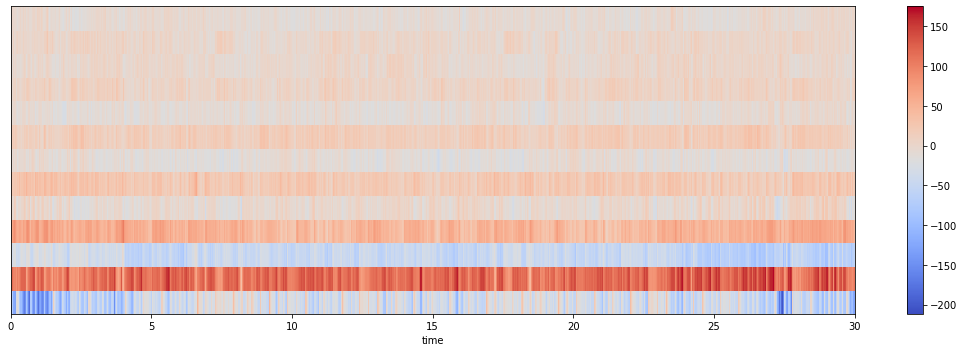

In [ ]:
plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

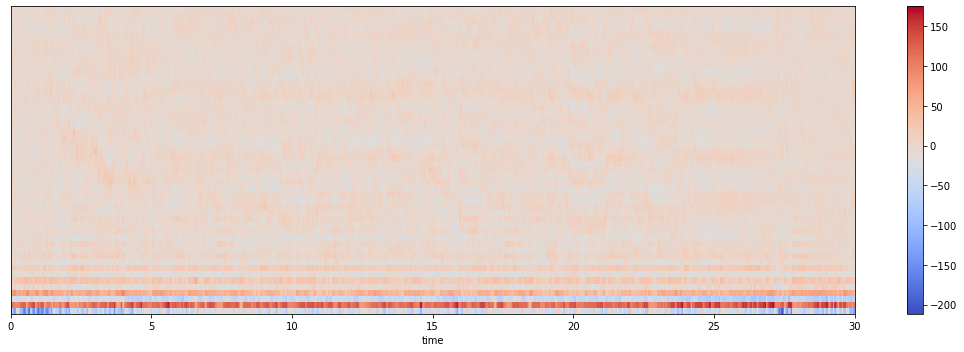

In [ ]:
mfcc_test = librosa.feature.mfcc(music_test1, sr=sr_test1, n_mfcc=50) # n_mfcc 50으로 설정

plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

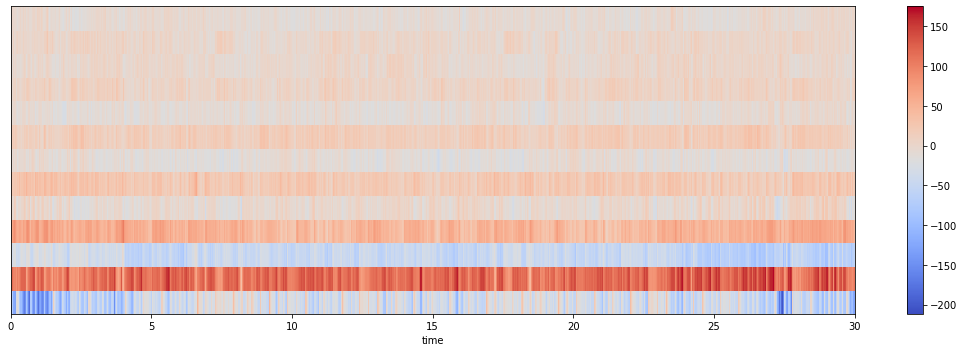

In [ ]:
mfcc_test2 = librosa.feature.mfcc(music_test1, sr=sr_test1, n_mfcc=13) # n_mfcc 13으로 설정

plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test2, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

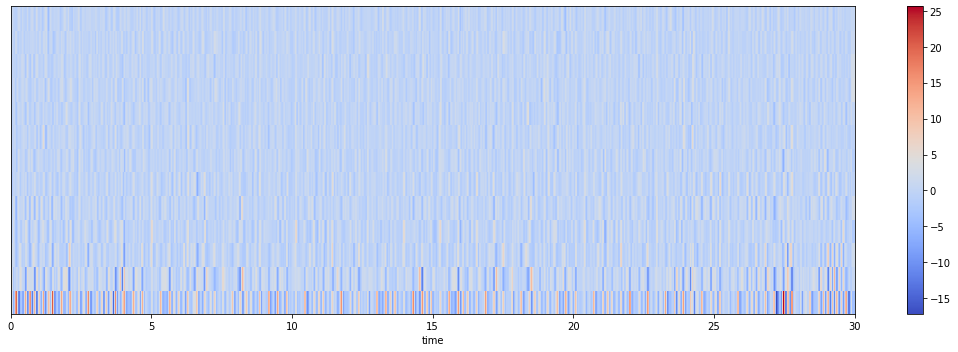

In [ ]:
mfcc_test2_delta = librosa.feature.delta(mfcc_test2)

plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test2_delta, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

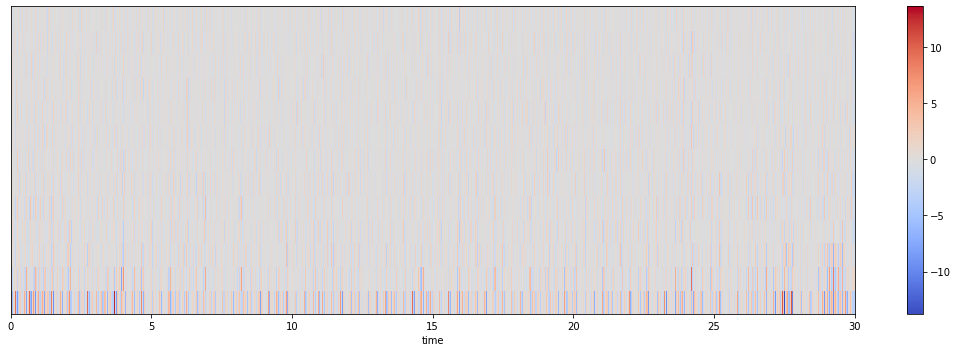

In [ ]:
mfcc_test2_delta2 = librosa.feature.delta(mfcc_test2, order=2)

plt.figure(figsize=(15,5))
librosa.display.specshow(mfcc_test2_delta2, sr=sr_test1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.xlabel('time')
plt.show()

In [ ]:
mfcc_test2.mean(axis=1)

array([-41.303383 , 116.67117  , -47.978    ,  52.246975 ,  -2.46684  ,
        23.92176  , -10.879446 ,  16.62207  ,  -8.112418 ,   6.441608 ,
        -0.8483089,   1.2515312,  -6.8292737], dtype=float32)

In [ ]:
mfcc_test2_delta.mean(axis=1)

array([ 0.01190331,  0.01144092, -0.01259566, -0.01338301, -0.00565325,
       -0.00728546, -0.00692504, -0.00893814, -0.0031424 ,  0.00421485,
        0.00415817,  0.00010216,  0.0035779 ], dtype=float32)

In [ ]:
mfcc_test2_delta2.mean(axis=1)

array([-0.00334321,  0.00293799,  0.00169406, -0.00301089, -0.00125977,
       -0.0042638 , -0.00305993, -0.0003083 , -0.00104567, -0.00167756,
       -0.00362369, -0.00207861,  0.00113246], dtype=float32)

In [ ]:
np.concatenate((mfcc_test2.mean(axis=1), mfcc_test2_delta.mean(axis=1), mfcc_test2_delta2.mean(axis=1)))

array([-4.13033829e+01,  1.16671173e+02, -4.79780006e+01,  5.22469749e+01,
       -2.46684003e+00,  2.39217606e+01, -1.08794460e+01,  1.66220703e+01,
       -8.11241817e+00,  6.44160795e+00, -8.48308921e-01,  1.25153124e+00,
       -6.82927370e+00,  1.19033139e-02,  1.14409225e-02, -1.25956628e-02,
       -1.33830104e-02, -5.65324770e-03, -7.28546362e-03, -6.92503667e-03,
       -8.93814489e-03, -3.14239925e-03,  4.21485305e-03,  4.15816763e-03,
        1.02156453e-04,  3.57789639e-03, -3.34320869e-03,  2.93799164e-03,
        1.69406214e-03, -3.01088672e-03, -1.25977246e-03, -4.26380243e-03,
       -3.05992644e-03, -3.08296178e-04, -1.04566640e-03, -1.67756260e-03,
       -3.62369302e-03, -2.07860628e-03,  1.13246136e-03], dtype=float32)

## MFCC 특성 추출

### (1차) MFCC 13차원에 대해 각각 평균 및 분산 산출 => 총 26개 Feature 반영

In [ ]:
# 음원 특성 추출 함수 정의(v2) => v1에서 mfcc 컬럼을 추가 반영
def get_features_v2(df, duration=None, offset=0.0, start_idx=START_INDEX,
                    end_idx=END_INDEX):
  df_copy = df.copy() # 데이터프레임 복사본 생성

  for idx, row in tqdm(df_copy.iterrows()):
    # index 범위 확인
    if idx < start_idx or idx > end_idx:
      continue

    # 음원 load
    music_path = row['Path']
    music, sr = librosa.load(music_path, sr=SAMPLING_RATE,
                             duration=duration, offset=offset) # 구간 설정

    # mfcc 13개 차원별 평균 및 분산 산출 후 저장
    mfcc = librosa.feature.mfcc(music, sr=sr, n_mfcc=13) # n_mfcc 13으로 설정
    for i, values in enumerate(mfcc):
      df_copy.loc[idx, f'MFCC{i+1}_mean'] = values.mean() # 평균
      df_copy.loc[idx, f'MFCC{i+1}_var'] = values.var() # 분산
  
  return df_copy

#### 음원 특성 추출 결과 저장 => "df_total_trim_v2"

In [ ]:
df_total_trim_v2 = get_features_v2(df_total_trim_v1)

0it [00:00, ?it/s]

In [ ]:
df_total_trim_v2.head()

file name  ... MFCC13_var
0  1_org_0.wav  ...  42.985229
1  1_org_1.wav  ...  37.703323
2  1_org_2.wav  ...  44.095776
3  1_org_3.wav  ...  39.537697
4  1_org_4.wav  ...  38.241234

[5 rows x 104 columns]

In [ ]:
df_total_trim_v2.shape

(6039, 104)

In [ ]:
df_total_trim_v2.to_csv(DIR_PATH + f'test_data/df_total_trim_v2.csv', index=False) # csv 파일로 저장

In [ ]:
df_total_trim_v2 = pd.read_csv(DIR_PATH + f'test_data/df_total_trim_v2.csv') # csv 파일 불러오기
df_total_trim_v2.shape

(6039, 104)

In [ ]:
df_total_trim_v2.head() # 특성 추출 결과 확인

file name  ... MFCC13_var
0  1_org_0.wav  ...  42.985229
1  1_org_1.wav  ...  37.703323
2  1_org_2.wav  ...  44.095776
3  1_org_3.wav  ...  39.537697
4  1_org_4.wav  ...  38.241234

[5 rows x 104 columns]

#### 전체 컬럼 스케일링 => "df_total_trim_v2_norm"

In [ ]:
df_total_trim_v2_norm = get_norm(df_total_trim_v2, 'ss', start_col='Tempo')
df_total_trim_v2_norm.head()

file name  ... MFCC13_var
0  1_org_0.wav  ...  -0.850753
1  1_org_1.wav  ...  -0.976342
2  1_org_2.wav  ...  -0.824347
3  1_org_3.wav  ...  -0.932726
4  1_org_4.wav  ...  -0.963552

[5 rows x 104 columns]

## 음원별 유사도 측정 및 비교(v2)

#### 원곡음원과 유사음원간 비교 => "score_table_2a"

In [ ]:
# 원곡음원과 유사음원간 비교 결과 => "score_table_2a"
score_table_2a = get_similarity_A(df_total_v2_norm, start_col='Tempo')
score_table_2a

원곡  ... Pearson_sim
1                더더 - It’s you  ...    0.540897
2                    와이낫 - 파랑새  ...    0.739906
3            요시마타 료 - Resolver  ...    0.558441
4              TLC - No Scrubs  ...    0.297194
5  Harold Faltermeyer - Axel F  ...    0.650248
6      A$ton Wyld - Next Level  ...    0.458567
7    S.E.S. - Dreams Come True  ...    0.876603

[7 rows x 6 columns]

#### 원곡음원과 샘플음원(랜덤추출)간 비교 => "score_table_2b"

In [ ]:
# 원곡음원과 샘플음원(랜덤추출)간 비교 결과 => "score_table_2b"
score_table_2b = get_similarity_B(df_total_v2_norm, start_col='Tempo')
score_table_2b

원곡            비교곡  Euclidean   Cos_sim  Pearson_sim
1                더더 - It’s you  샘플 Music 500곡  12.691976  0.004436     0.005785
2                    와이낫 - 파랑새  샘플 Music 500곡  12.269280 -0.000209     0.000263
3            요시마타 료 - Resolver  샘플 Music 500곡  11.744420  0.002177     0.004687
4              TLC - No Scrubs  샘플 Music 500곡  13.057510  0.000714    -0.000231
5  Harold Faltermeyer - Axel F  샘플 Music 500곡  12.681067  0.000623    -0.000986
6      A$ton Wyld - Next Level  샘플 Music 500곡  12.313355 -0.000295    -0.001185
7    S.E.S. - Dreams Come True  샘플 Music 500곡  13.122772  0.005378     0.006121

In [ ]:
# Score 산출 결과 확인
score_table_result_2ab = get_score_result(score_table_2a, score_table_2b, rate=False) # 2a 기준으로 2b와 비교
score_table_result_2ab

원곡                        비교곡  ... Pearson_sim   Score
1                더더 - It’s you            MC몽 - 너에게 쓰는 편지  ...    0.535112  192.93
2                    와이낫 - 파랑새                씨엔블루 - 외톨이야  ...    0.739643  258.86
3            요시마타 료 - Resolver            FTISLAND - 사랑앓이  ...    0.553754  212.84
4              TLC - No Scrubs  Ed Sheeran - Shape of you  ...    0.297425  108.78
5  Harold Faltermeyer - Axel F                   싸이 - 챔피언  ...    0.651234  233.94
6      A$ton Wyld - Next Level           에스파 - Next Level  ...    0.459752  192.03
7    S.E.S. - Dreams Come True     에스파 - Dreams Come True  ...    0.870482  354.30

[7 rows x 7 columns]

In [ ]:
score_table_result_2ab_mean = score_table_result_2ab["Score"].mean() # Score 평균 확인
score_table_result_2ab_mean

221.9542857142857

#### Test음원과 Test음원(12곡)간 비교 => "score_table_2c"

In [ ]:
# 원곡음원과 Test음원(12곡)간 비교 결과
score_table_2c = get_similarity_C(df_total_v2_norm, start_col='Tempo')
score_table_2c

원곡            비교곡  Euclidean   Cos_sim  Pearson_sim
1                더더 - It’s you  다른 Test음원 12곡   7.863316  0.506887     0.511656
2                    와이낫 - 파랑새  다른 Test음원 12곡   7.564321  0.498360     0.500461
3            요시마타 료 - Resolver  다른 Test음원 12곡   8.781699  0.292652     0.298856
4              TLC - No Scrubs  다른 Test음원 12곡   8.753873  0.431337     0.436610
5  Harold Faltermeyer - Axel F  다른 Test음원 12곡   9.859649  0.234820     0.247942
6      A$ton Wyld - Next Level  다른 Test음원 12곡   9.236501  0.294414     0.302069
7    S.E.S. - Dreams Come True  다른 Test음원 12곡   8.263381  0.497288     0.499331

In [ ]:
# Score 산출 결과 확인
score_table_result_2ac = get_score_result(score_table_2a, score_table_2c, rate=False) # 2a 기준으로 2c와 비교
score_table_result_2ac

원곡                        비교곡  ... Pearson_sim   Score
1                더더 - It’s you            MC몽 - 너에게 쓰는 편지  ...    0.029241   -1.63
2                    와이낫 - 파랑새                씨엔블루 - 외톨이야  ...    0.239445   68.74
3            요시마타 료 - Resolver            FTISLAND - 사랑앓이  ...    0.259586   94.60
4              TLC - No Scrubs  Ed Sheeran - Shape of you  ...   -0.139416  -63.59
5  Harold Faltermeyer - Axel F                   싸이 - 챔피언  ...    0.402306  123.79
6      A$ton Wyld - Next Level           에스파 - Next Level  ...    0.156498   69.54
7    S.E.S. - Dreams Come True     에스파 - Dreams Come True  ...    0.377272  159.49

[7 rows x 7 columns]

In [ ]:
score_table_result_2ac_mean = score_table_result_2ac["Score"].mean() # Score 평균 확인
score_table_result_2ac_mean

64.42

### (2차) MFCC 13차원에 대해 mfcc, mfcc_delta, mfcc_delta2를 구한 뒤, 각각의 평균 산출 => 총 39개 Feature 반영

In [ ]:
# 음원 특성 추출 함수 정의(v2_1) => v1에서 mfcc 컬럼을 추가 반영
def get_features_v2_1(df, duration=None, offset=0.0, start_idx=START_INDEX, end_idx=END_INDEX):
  df_copy = df.copy() # 데이터프레임 복사본 생성

  for idx, row in tqdm(df_copy.iterrows()):
    # index 범위 확인
    if idx < start_idx or idx > end_idx:
      continue

    # 음원 load
    music_path = row['Path']
    music, sr = librosa.load(music_path, sr=SAMPLING_RATE, duration=duration, offset=offset) # 옵션값 기준 구간 설정

    # mfcc 13개 차원별 평균 산출 후 저장
    mfcc = librosa.feature.mfcc(music, sr=sr, n_mfcc=13) # n_mfcc 13으로 설정
    for i, values in enumerate(mfcc):
      df_copy.loc[idx, f'MFCC{i+1}_mean'] = values.mean()
    
    # mfcc_delta 13개 차원별 평균 산출 후 저장
    mfcc_delta = librosa.feature.delta(mfcc, order=1) # delta(1차 차분)
    for i, values in enumerate(mfcc_delta):
      df_copy.loc[idx, f'MFCC_DELTA{i+1}_mean'] = values.mean()

    # mfcc_delta2 13개 차원별 평균 산출 후 저장
    mfcc_delta_delta = librosa.feature.delta(mfcc, order=2) # delta-delta(2차 차분)
    for i, values in enumerate(mfcc_delta_delta):
      df_copy.loc[idx, f'MFCC_DELTA_DELTA{i+1}_mean'] = values.mean()

  return df_copy

#### 음원 특성 추출 결과 저장 => "df_total_trim_v2_1"

In [ ]:
df_total_trim_v2_1 = get_features_v2_1(df_total_trim_v1)

0it [00:00, ?it/s]

In [ ]:
df_total_trim_v2_1.to_csv(DIR_PATH + f'test_data/df_total_trim_v2_1.csv', index=False) # csv 파일로 저장

In [ ]:
df_total_trim_v2_1 = pd.read_csv(DIR_PATH + f'test_data/df_total_trim_v2_1.csv') # csv 파일 불러오기
df_total_trim_v2_1.shape

(6039, 117)

In [ ]:
df_total_trim_v2_1.head() # 특성 추출 결과 확인

file name  ... MFCC_DELTA_DELTA13_mean
0  1_org_0.wav  ...                0.002599
1  1_org_1.wav  ...               -0.001450
2  1_org_2.wav  ...                0.004369
3  1_org_3.wav  ...                0.000486
4  1_org_4.wav  ...               -0.000701

[5 rows x 117 columns]

#### 전체 컬럼 스케일링 => "df_total_trim_v2_1_norm"

In [ ]:
df_total_trim_v2_1_norm = get_norm(df_total_trim_v2_1, 'ss', start_col='Tempo')
df_total_trim_v2_1_norm.head()

file name  ... MFCC_DELTA_DELTA13_mean
0  1_org_0.wav  ...                1.405141
1  1_org_1.wav  ...               -1.010883
2  1_org_2.wav  ...                2.460935
3  1_org_3.wav  ...                0.144105
4  1_org_4.wav  ...               -0.563967

[5 rows x 117 columns]

## 음원별 유사도 측정 및 비교(v2_1)

#### 원곡음원과 유사음원간 비교 => "score_table_2_1a"

In [ ]:
# 원곡음원과 유사음원간 비교 결과 => "score_table_2_1a"
score_table_2_1a = get_similarity_A(df_total_v2_1_norm, start_col='Tempo')
score_table_2_1a

원곡  ... Pearson_sim
1                더더 - It’s you  ...    0.519994
2                    와이낫 - 파랑새  ...    0.731637
3            요시마타 료 - Resolver  ...    0.581847
4              TLC - No Scrubs  ...    0.256759
5  Harold Faltermeyer - Axel F  ...    0.657167
6      A$ton Wyld - Next Level  ...    0.503916
7    S.E.S. - Dreams Come True  ...    0.879486

[7 rows x 6 columns]

#### 원곡음원과 샘플음원(랜덤추출)간 비교 => "score_table_2_1b"

In [ ]:
# 원곡음원과 샘플음원(랜덤추출)간 비교 결과 => "score_table_2_1b"
score_table_2_1b = get_similarity_B(df_total_v2_1_norm, start_col='Tempo')
score_table_2_1b

원곡            비교곡  Euclidean   Cos_sim  Pearson_sim
1                더더 - It’s you  샘플 Music 500곡  12.600466  0.004713     0.004652
2                    와이낫 - 파랑새  샘플 Music 500곡  12.482479  0.004403     0.003976
3            요시마타 료 - Resolver  샘플 Music 500곡  11.521195  0.002805     0.004111
4              TLC - No Scrubs  샘플 Music 500곡  13.238508 -0.000213    -0.002770
5  Harold Faltermeyer - Axel F  샘플 Music 500곡  12.854986  0.006614     0.003969
6      A$ton Wyld - Next Level  샘플 Music 500곡  12.440137  0.005924     0.005315
7    S.E.S. - Dreams Come True  샘플 Music 500곡  13.284567  0.006742     0.006540

In [ ]:
# Score 산출 결과 확인 => "score_table_result_2_1ab"
score_table_result_2_1ab = get_score_result(score_table_2_1a, score_table_2_1b, rate=False) # 2_1a 기준으로 2_1b와 비교
score_table_result_2_1ab

원곡                        비교곡  ... Pearson_sim   Score
1                더더 - It’s you            MC몽 - 너에게 쓰는 편지  ...    0.515342  196.23
2                    와이낫 - 파랑새                씨엔블루 - 외톨이야  ...    0.727661  269.56
3            요시마타 료 - Resolver            FTISLAND - 사랑앓이  ...    0.577736  230.58
4              TLC - No Scrubs  Ed Sheeran - Shape of you  ...    0.259529  109.36
5  Harold Faltermeyer - Axel F                   싸이 - 챔피언  ...    0.653198  248.88
6      A$ton Wyld - Next Level           에스파 - Next Level  ...    0.498600  216.51
7    S.E.S. - Dreams Come True     에스파 - Dreams Come True  ...    0.872946  366.01

[7 rows x 7 columns]

In [ ]:
score_table_result_2_1ab_mean = score_table_result_2_1ab["Score"].mean() # Score 평균 확인
score_table_result_2_1ab_mean

233.8757142857143

#### Test음원과 Test음원(12곡)간 비교 => "score_table_2_1c"

In [ ]:
# 원곡음원과 Test음원(12곡)간 비교 결과 => "score_table_2_1c"
score_table_2_1c = get_similarity_C(df_total_v2_1_norm, start_col='Tempo')
score_table_2_1c

원곡            비교곡  Euclidean   Cos_sim  Pearson_sim
1                더더 - It’s you  다른 Test음원 12곡   7.414603  0.503570     0.505450
2                    와이낫 - 파랑새  다른 Test음원 12곡   7.298426  0.500105     0.500174
3            요시마타 료 - Resolver  다른 Test음원 12곡   8.194622  0.280236     0.285450
4              TLC - No Scrubs  다른 Test음원 12곡   8.561101  0.412380     0.412218
5  Harold Faltermeyer - Axel F  다른 Test음원 12곡   9.533189  0.227676     0.227335
6      A$ton Wyld - Next Level  다른 Test음원 12곡   8.199044  0.391528     0.391579
7    S.E.S. - Dreams Come True  다른 Test음원 12곡   8.036486  0.491844     0.492281

In [ ]:
# Score 산출 결과 확인 => "score_table_result_2_1ac"
score_table_result_2_1ac = get_score_result(score_table_2_1a, score_table_2_1c, rate=False) # 2_1a 기준으로 2_1c와 비교
score_table_result_2_1ac

원곡                        비교곡  ... Pearson_sim   Score
1                더더 - It’s you            MC몽 - 너에게 쓰는 편지  ...    0.014544   -9.95
2                    와이낫 - 파랑새                씨엔블루 - 외톨이야  ...    0.231463   63.70
3            요시마타 료 - Resolver            FTISLAND - 사랑앓이  ...    0.296397  101.06
4              TLC - No Scrubs  Ed Sheeran - Shape of you  ...   -0.155459  -74.14
5  Harold Faltermeyer - Axel F                   싸이 - 챔피언  ...    0.429832  123.34
6      A$ton Wyld - Next Level           에스파 - Next Level  ...    0.112336   49.42
7    S.E.S. - Dreams Come True     에스파 - Dreams Come True  ...    0.387205  158.71

[7 rows x 7 columns]

In [ ]:
score_table_result_2_1ac_mean = score_table_result_2_1ac["Score"].mean() # Score 평균 확인
score_table_result_2_1ac_mean

58.87714285714286

> Score 평균이 58.88로, 기존 Score 평균(64.42) 대비 점수가 오히려 낮아진 것으로 확인됨<br/>
=> MFCC 13차원에 대해 delta값 보다는 평균 및 분산을 산출해 적용하는 것이 더 나은 것으로 판단됨

In [ ]:
score_table_result_2ac_mean # (기존) MFCC 13차원에 대해 각각 평균 및 분산 산출 시 Score 평균

64.42

## 음원 특성 조합별 유사도 측정 결과 비교

In [ ]:
# 특정 음원과 전체 음원간 유사도 측정 함수 정의
def get_similarity_ALL(label, order, df_norm, start_col='Tempo', end_col='Chroma_cens12_var', col_names=False):
  # "score_table_all" 생성
  score_table_all = pd.DataFrame(columns=['원곡', '비교곡', 'Euclidean', 'Cos_sim', 'Pearson_sim'])

  # 특정 음원 데이터 값 추출
  idx_a = df_norm[(df_norm['label'] == label) & (df_norm['order'] == order)].index[0]
  if col_names: # col_names 적용
    a = df_norm[col_names].loc[idx_a, :].values
  else: # start_col 및 end_col 적용
    a = df_norm.loc[idx_a, start_col:end_col].values

  for idx, row in df_norm.iterrows():
    # 비교대상 데이터 값 추출
    if col_names: # col_names 적용
      b = df_norm[col_names].loc[idx, :].values
    else: # start_col 및 end_col 적용
      b = df_norm.loc[idx, start_col:end_col].values

    new_data = {
        '원곡' : f'{label}_{order}',
        '비교곡' : row['label'] + '_' + str(row['order']),
        'Euclidean' : euclidean_dist(a, b),
        'Cos_sim' : cos_similarity(a, b),
        'Pearson_sim' : pearson_similarity(a, b)
    }

    # 행 데이터 추가
    score_table_all = score_table_all.append(new_data, ignore_index=True)
  
  score_table_all['Score'] = round(
      ((100.0 - score_table_all['Euclidean'])
      * (score_table_all['Cos_sim'] + 1.0)
      * (score_table_all['Pearson_sim'] + 1.0)) / 2, 2)
  
  return score_table_all

In [ ]:
list(test_data['Music'])

['더더 - It’s you',
 'MC몽 - 너에게 쓰는 편지',
 '와이낫 - 파랑새',
 '씨엔블루 - 외톨이야',
 '요시마타 료 - Resolver',
 'FTISLAND - 사랑앓이',
 'TLC - No Scrubs',
 'Ed Sheeran - Shape of you',
 'Harold Faltermeyer - Axel F',
 '싸이 - 챔피언',
 'A$ton Wyld - Next Level',
 '에스파 - Next Level',
 'S.E.S. - Dreams Come True',
 '에스파 - Dreams Come True']

In [ ]:
# 다양한 특성 조합 설정
col_names=['Tempo',
  'Chroma_stft1_mean', 'Chroma_stft2_mean', 'Chroma_stft3_mean', 'Chroma_stft4_mean', 'Chroma_stft5_mean', 'Chroma_stft6_mean',
  'Chroma_stft7_mean', 'Chroma_stft8_mean', 'Chroma_stft9_mean', 'Chroma_stft10_mean', 'Chroma_stft11_mean', 'Chroma_stft12_mean',
  'Chroma_stft1_var', 'Chroma_stft2_var', 'Chroma_stft3_var', 'Chroma_stft4_var', 'Chroma_stft5_var', 'Chroma_stft6_var',
  'Chroma_stft7_var', 'Chroma_stft8_var', 'Chroma_stft9_var', 'Chroma_stft10_var', 'Chroma_stft11_var', 'Chroma_stft12_var',
  'Chroma_cqt1_mean', 'Chroma_cqt2_mean', 'Chroma_cqt3_mean', 'Chroma_cqt4_mean', 'Chroma_cqt5_mean', 'Chroma_cqt6_mean',
  'Chroma_cqt7_mean', 'Chroma_cqt8_mean', 'Chroma_cqt9_mean', 'Chroma_cqt10_mean', 'Chroma_cqt11_mean', 'Chroma_cqt12_mean',
  'Chroma_cqt1_var', 'Chroma_cqt2_var', 'Chroma_cqt3_var', 'Chroma_cqt4_var', 'Chroma_cqt5_var', 'Chroma_cqt6_var',
  'Chroma_cqt7_var', 'Chroma_cqt8_var', 'Chroma_cqt9_var', 'Chroma_cqt10_var', 'Chroma_cqt11_var', 'Chroma_cqt12_var',
  # 'Chroma_cens1_mean', 'Chroma_cens2_mean', 'Chroma_cens3_mean', 'Chroma_cens4_mean', 'Chroma_cens5_mean', 'Chroma_cens6_mean',
  # 'Chroma_cens7_mean', 'Chroma_cens8_mean', 'Chroma_cens9_mean', 'Chroma_cens10_mean', 'Chroma_cens11_mean', 'Chroma_cens12_mean',
  # 'Chroma_cens1_var', 'Chroma_cens2_var', 'Chroma_cens3_var', 'Chroma_cens4_var', 'Chroma_cens5_var', 'Chroma_cens6_var',
  # 'Chroma_cens7_var', 'Chroma_cens8_var', 'Chroma_cens9_var', 'Chroma_cens10_var', 'Chroma_cens11_var', 'Chroma_cens12_var',
  'MFCC1_mean', 'MFCC2_mean', 'MFCC3_mean', 'MFCC4_mean', 'MFCC5_mean', 'MFCC6_mean',
  'MFCC7_mean', 'MFCC8_mean', 'MFCC9_mean', 'MFCC10_mean', 'MFCC11_mean', 'MFCC12_mean', 'MFCC13_mean',
  'MFCC1_var', 'MFCC2_var', 'MFCC3_var', 'MFCC4_var', 'MFCC5_var', 'MFCC6_var',
  'MFCC7_var', 'MFCC8_var', 'MFCC9_var', 'MFCC10_var', 'MFCC11_var', 'MFCC12_var', 'MFCC13_var',
  # 'MFCC_DELTA1_mean', 'MFCC_DELTA2_mean', 'MFCC_DELTA3_mean', 'MFCC_DELTA4_mean', 'MFCC_DELTA5_mean', 'MFCC_DELTA6_mean',
  # 'MFCC_DELTA7_mean', 'MFCC_DELTA8_mean', 'MFCC_DELTA9_mean', 'MFCC_DELTA10_mean', 'MFCC_DELTA11_mean', 'MFCC_DELTA12_mean',
  # 'MFCC_DELTA_DELTA1_mean', 'MFCC_DELTA_DELTA2_mean', 'MFCC_DELTA_DELTA3_mean', 'MFCC_DELTA_DELTA4_mean', 'MFCC_DELTA_DELTA5_mean', 'MFCC_DELTA_DELTA6_mean',
  # 'MFCC_DELTA_DELTA7_mean', 'MFCC_DELTA_DELTA8_mean', 'MFCC_DELTA_DELTA9_mean', 'MFCC_DELTA_DELTA10_mean', 'MFCC_DELTA_DELTA11_mean', 'MFCC_DELTA_DELTA12_mean'
]

In [ ]:
# 특정 음원과 전체 음원간 유사도 측정 및 유사도 상위 30개 리스트 확인
label = '씨엔블루 - 외톨이야'
order = 6
df_name = df_total_trim_v2_norm

df_sim_all = get_similarity_ALL(label, order, df_name, col_names=col_names)
df_sim_all.sort_values(by='Score', ascending=False).head(30)

원곡                           비교곡  ...  Pearson_sim   Score
36   씨엔블루 - 외톨이야_6                 씨엔블루 - 외톨이야_6  ...     1.000000  200.00
33   씨엔블루 - 외톨이야_6                 씨엔블루 - 외톨이야_3  ...     0.986742  194.42
32   씨엔블루 - 외톨이야_6                 씨엔블루 - 외톨이야_2  ...     0.968368  188.95
37   씨엔블루 - 외톨이야_6                 씨엔블루 - 외톨이야_7  ...     0.967223  188.56
34   씨엔블루 - 외톨이야_6                 씨엔블루 - 외톨이야_4  ...     0.963420  187.53
35   씨엔블루 - 외톨이야_6                 씨엔블루 - 외톨이야_5  ...     0.949614  184.97
38   씨엔블루 - 외톨이야_6                 씨엔블루 - 외톨이야_8  ...     0.896476  173.03
39   씨엔블루 - 외톨이야_6                 씨엔블루 - 외톨이야_9  ...     0.865790  166.40
31   씨엔블루 - 외톨이야_6                 씨엔블루 - 외톨이야_1  ...     0.861338  164.80
40   씨엔블루 - 외톨이야_6                씨엔블루 - 외톨이야_10  ...     0.854328  162.99
58   씨엔블루 - 외톨이야_6            FTISLAND - 사랑앓이_11  ...     0.856382  162.49
54   씨엔블루 - 외톨이야_6             FTISLAND - 사랑앓이_7  ...     0.850970  162.20
128  씨엔블루 - 외톨이야_6  S.E.S. - Dreams Come True_10  ...     0.843583  161.71
122  씨엔블루 - 외톨이야_6   S.E.S. - Dreams Come True_4  ...     0.820441  156.93
125  씨엔블루 - 외톨이야_6   S.E.S. - Dreams Come True_7  ...     0.813500  156.10
121  씨엔블루 - 외톨이야_6   S.E.S. - Dreams Come True_3  ...     0.809700  155.20
126  씨엔블루 - 외톨이야_6   S.E.S. - Dreams Come True_8  ...     0.806036  154.60
127  씨엔블루 - 외톨이야_6   S.E.S. - Dreams Come True_9  ...     0.808746  154.39
24   씨엔블루 - 외톨이야_6                   와이낫 - 파랑새_4  ...     0.799772  153.62
57   씨엔블루 - 외톨이야_6            FTISLAND - 사랑앓이_10  ...     0.801432  152.31
29   씨엔블루 - 외톨이야_6                   와이낫 - 파랑새_9  ...     0.790814  151.86
131  씨엔블루 - 외톨이야_6      에스파 - Dreams Come True_1  ...     0.808074  151.57
5    씨엔블루 - 외톨이야_6               더더 - It’s you_6  ...     0.791376  151.13
21   씨엔블루 - 외톨이야_6                   와이낫 - 파랑새_1  ...     0.784050  150.77
53   씨엔블루 - 외톨이야_6             FTISLAND - 사랑앓이_6  ...     0.782509  150.53
123  씨엔블루 - 외톨이야_6   S.E.S. - Dreams Come True_5  ...     0.784155  150.45
129  씨엔블루 - 외톨이야_6  S.E.S. - Dreams Come True_11  ...     0.789430  150.13
30   씨엔블루 - 외톨이야_6                  와이낫 - 파랑새_10  ...     0.776444  149.37
41   씨엔블루 - 외톨이야_6                씨엔블루 - 외톨이야_11  ...     0.778658  148.49
27   씨엔블루 - 외톨이야_6                   와이낫 - 파랑새_7  ...     0.767067  147.68

[30 rows x 6 columns]

In [ ]:
# Music 재생
label = '더더 - It’s you'
order = 3
df_name = df_total_trim_v2_norm

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = 'MC몽 - 너에게 쓰는 편지'
order = 3
df_name = df_total_trim_v2_norm

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = '와이낫 - 파랑새'
order = 7
df_name = df_total_trim_v2_norm

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = '씨엔블루 - 외톨이야'
order = 6
df_name = df_total_trim_v2_norm

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

## Vocal 기준 데이터프레임 추가 생성

#### Vocal 기준 데이터프레임(v1) 생성 => "df_total_sepVocal_trim_v1"

In [ ]:
# 기본 DataFrame 생성 함수 정의
def get_df_with_values(df_base):
  file_name_list = []
  original_file_list = []
  label_list = []
  order_list = []

  for idx, row in df_base.iterrows():
    file_name = row['Path'].split('/')[-1]
    directory_num = int(file_name.split('_')[0])
    type_str = file_name.split('_')[1]
    order = int(file_name.split('_')[-1].split('.')[0]) + 1

    if type_str[:3] == 'org':
      original_file = test_data.loc[directory_num*2-1, 'Path'].split('/')[-1].split('.')[0]
      label = test_data.loc[directory_num*2-1, 'Music']
    else:
      original_file = test_data.loc[directory_num*2, 'Path'].split('/')[-1].split('.')[0]
      label = test_data.loc[directory_num*2, 'Music']

    # print(file_name, directory_num, type_str, order)
    file_name_list.append(file_name)
    original_file_list.append(original_file)
    label_list.append(label)
    order_list.append(order)

  df_base['file name'] = file_name_list
  df_base['original file'] = original_file_list
  df_base['label'] = label_list
  df_base['order'] = order_list

  return df_base

In [ ]:
test_data_sepVocal_trim = pd.DataFrame(columns=['file name', 'original file', 'label', 'order', 'Path'])
test_data_sepVocal_trim['Path'] = glob.glob(DIR_PATH + 'test_data/separate_trim/vocal/*.wav')

In [ ]:
test_data_sepVocal_trim_v0 = get_df_with_values(test_data_sepVocal_trim)
test_data_sepVocal_trim_v0.head()

file name  ...                                               Path
0  1_orgVocal_0.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
1  1_orgVocal_1.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
2  1_orgVocal_2.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
3  1_orgVocal_3.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
4  1_orgVocal_4.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...

[5 rows x 5 columns]

In [ ]:
test_data_sepVocal_trim_v1 = get_features_v1(test_data_sepVocal_trim_v0)
test_data_sepVocal_trim_v1.head()

0it [00:00, ?it/s]

file name  ... Chroma_cens12_var
0  1_orgVocal_0.wav  ...          0.031425
1  1_orgVocal_1.wav  ...          0.034801
2  1_orgVocal_2.wav  ...          0.027766
3  1_orgVocal_3.wav  ...          0.026180
4  1_orgVocal_4.wav  ...          0.028456

[5 rows x 78 columns]

In [ ]:
test_data_sepVocal_trim_v1.shape

(141, 78)

In [ ]:
test_data_sepVocal_trim_v1.to_csv(DIR_PATH + f'test_data/test_data_sepVocal_trim_v1.csv', index=False) # csv 파일로 저장

In [ ]:
df_total_sepVocal_trim_v1 = pd.read_csv(DIR_PATH + f'test_data/test_data_sepVocal_trim_v1.csv') # csv 파일 불러오기
df_total_sepVocal_trim_v1.shape # 기존 데이터프레임의 일반 Music 데이터는 Vocal이 없는 음원이 대부분이므로 해당 데이터와 합치지 않고 진행함

(141, 78)

In [ ]:
df_total_sepVocal_trim_v1.head() # 특성 추출 결과 확인

file name  ... Chroma_cens12_var
0  1_orgVocal_0.wav  ...          0.031425
1  1_orgVocal_1.wav  ...          0.034801
2  1_orgVocal_2.wav  ...          0.027766
3  1_orgVocal_3.wav  ...          0.026180
4  1_orgVocal_4.wav  ...          0.028456

[5 rows x 78 columns]

In [ ]:
df_total_sepVocal_trim_v1_norm = get_norm(df_total_sepVocal_trim_v1, 'ss', start_col='Tempo') # MinMax 스케일링 or Standard 스케일링
df_total_sepVocal_trim_v1_norm.head()

file name  ... Chroma_cens12_var
0  1_orgVocal_0.wav  ...          0.423442
1  1_orgVocal_1.wav  ...          0.726090
2  1_orgVocal_2.wav  ...          0.095364
3  1_orgVocal_3.wav  ...         -0.046829
4  1_orgVocal_4.wav  ...          0.157249

[5 rows x 78 columns]

#### Vocal 기준 데이터프레임(v2) 생성 => "df_total_sepVocal_trim_v2"

In [ ]:
df_total_sepVocal_trim_v2 = get_features_v2(df_total_sepVocal_trim_v1)

0it [00:00, ?it/s]

In [ ]:
df_total_sepVocal_trim_v2.shape

(141, 104)

In [ ]:
df_total_sepVocal_trim_v2.to_csv(DIR_PATH + f'test_data/df_total_sepVocal_trim_v2.csv', index=False) # csv 파일로 저장

In [ ]:
df_total_sepVocal_trim_v2 = pd.read_csv(DIR_PATH + f'test_data/df_total_sepVocal_trim_v2.csv') # csv 파일 불러오기
df_total_sepVocal_trim_v2.shape

(141, 104)

In [ ]:
df_total_sepVocal_trim_v2_norm = get_norm(df_total_sepVocal_trim_v2, 'ss', start_col='Tempo')
df_total_sepVocal_trim_v2_norm.head()

file name  ... MFCC13_var
0  1_orgVocal_0.wav  ...  -0.205505
1  1_orgVocal_1.wav  ...   0.405379
2  1_orgVocal_2.wav  ...   0.976966
3  1_orgVocal_3.wav  ...   0.702867
4  1_orgVocal_4.wav  ...   0.819677

[5 rows x 104 columns]

## Vocal 제외 기준 데이터프레임 추가 생성

#### Vocal 제외 기준 데이터프레임(v1) 생성 => "df_total_sepOther_trim_v1"

In [ ]:
test_data_sepOther_trim = pd.DataFrame(columns=['file name', 'original file', 'label', 'order', 'Path'])
test_data_sepOther_trim['Path'] = glob.glob(DIR_PATH + 'test_data/separate_trim/other/*.wav')

In [ ]:
test_data_sepOther_trim_v0 = get_df_with_values(test_data_sepOther_trim)
test_data_sepOther_trim_v0.head()

file name  ...                                               Path
0  1_orgOther_0.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
1  1_orgOther_1.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
2  1_orgOther_2.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
3  1_orgOther_3.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...
4  1_orgOther_4.wav  ...  /content/drive/MyDrive/ds_study/DL_project2/te...

[5 rows x 5 columns]

In [ ]:
test_data_sepOther_trim_v1 = get_features_v1(test_data_sepOther_trim_v0)
test_data_sepOther_trim_v1.shape

0it [00:00, ?it/s]

(141, 78)

In [ ]:
test_data_sepOther_trim_v1.to_csv(DIR_PATH + f'test_data/test_data_sepOther_trim_v1.csv', index=False) # csv 파일로 저장

In [ ]:
test_data_sepOther_trim_v1 = pd.read_csv(DIR_PATH + f'test_data/test_data_sepOther_trim_v1.csv') # csv 파일 불러오기
test_data_sepOther_trim_v1.shape

(141, 78)

In [ ]:
# 기존 데이터프레임의 일반 Music 데이터와 합치기
df_total_sepOther_trim_v1 = pd.concat([test_data_sepOther_trim_v1, df_total_trim_v1.iloc[141:, :]])
df_total_sepOther_trim_v1.shape

(6039, 78)

In [ ]:
df_total_sepOther_trim_v1.to_csv(DIR_PATH + f'test_data/df_total_sepOther_trim_v1.csv', index=False) # csv 파일로 저장

In [ ]:
df_total_sepOther_trim_v1 = pd.read_csv(DIR_PATH + f'test_data/df_total_sepOther_trim_v1.csv') # csv 파일 불러오기
df_total_sepOther_trim_v1.shape

(6039, 78)

In [ ]:
df_total_sepOther_trim_v1_norm = get_norm(df_total_sepOther_trim_v1, 'ss', start_col='Tempo') # MinMax 스케일링 or Standard 스케일링
df_total_sepOther_trim_v1_norm.head()

file name  ... Chroma_cens12_var
0  1_orgOther_0.wav  ...         -0.842051
1  1_orgOther_1.wav  ...         -0.852443
2  1_orgOther_2.wav  ...         -1.034365
3  1_orgOther_3.wav  ...         -0.872216
4  1_orgOther_4.wav  ...         -0.772291

[5 rows x 78 columns]

#### Vocal 제외 기준 데이터프레임(v2) 생성 => "df_total_sepOther_trim_v2"

In [ ]:
test_data_sepOther_trim_v2 = get_features_v2(test_data_sepOther_trim_v1)

0it [00:00, ?it/s]

In [ ]:
test_data_sepOther_trim_v2.shape

(141, 104)

In [ ]:
test_data_sepOther_trim_v2.to_csv(DIR_PATH + f'test_data/test_data_sepOther_trim_v2.csv', index=False) # csv 파일로 저장

In [ ]:
test_data_sepOther_trim_v2 = pd.read_csv(DIR_PATH + f'test_data/test_data_sepOther_trim_v2.csv') # csv 파일 불러오기
test_data_sepOther_trim_v2.shape

(141, 104)

In [ ]:
# 기존 데이터프레임의 일반 Music 데이터와 합치기
df_total_sepOther_trim_v2 = pd.concat([test_data_sepOther_trim_v2, df_total_trim_v2.iloc[141:, :]])
df_total_sepOther_trim_v2.shape

(6039, 104)

In [ ]:
df_total_sepOther_trim_v2.to_csv(DIR_PATH + f'test_data/df_total_sepOther_trim_v2.csv', index=False) # csv 파일로 저장

In [ ]:
df_total_sepOther_trim_v2 = pd.read_csv(DIR_PATH + f'test_data/df_total_sepOther_trim_v2.csv') # csv 파일 불러오기
df_total_sepOther_trim_v2.shape

(6039, 104)

In [ ]:
df_total_sepOther_trim_v2_norm = get_norm(df_total_sepOther_trim_v2, 'ss', start_col='Tempo') # MinMax 스케일링 or Standard 스케일링
df_total_sepOther_trim_v2_norm.head()

file name  ... MFCC13_var
0  1_orgOther_0.wav  ...  -0.913778
1  1_orgOther_1.wav  ...  -1.033279
2  1_orgOther_2.wav  ...  -0.918607
3  1_orgOther_3.wav  ...  -0.949739
4  1_orgOther_4.wav  ...  -0.921470

[5 rows x 104 columns]

In [ ]:
label = '씨엔블루 - 외톨이야'
order = 6
df_name = df_total_sepOther_trim_v1

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 다양한 특성 조합 설정
col_names_2=[
  'Tempo',
  'Chroma_stft1_mean', 'Chroma_stft2_mean', 'Chroma_stft3_mean', 'Chroma_stft4_mean', 'Chroma_stft5_mean', 'Chroma_stft6_mean',
  'Chroma_stft7_mean', 'Chroma_stft8_mean', 'Chroma_stft9_mean', 'Chroma_stft10_mean', 'Chroma_stft11_mean', 'Chroma_stft12_mean',
  'Chroma_stft1_var', 'Chroma_stft2_var', 'Chroma_stft3_var', 'Chroma_stft4_var', 'Chroma_stft5_var', 'Chroma_stft6_var',
  'Chroma_stft7_var', 'Chroma_stft8_var', 'Chroma_stft9_var', 'Chroma_stft10_var', 'Chroma_stft11_var', 'Chroma_stft12_var',
  # 'Chroma_cqt1_mean', 'Chroma_cqt2_mean', 'Chroma_cqt3_mean', 'Chroma_cqt4_mean', 'Chroma_cqt5_mean', 'Chroma_cqt6_mean',
  # 'Chroma_cqt7_mean', 'Chroma_cqt8_mean', 'Chroma_cqt9_mean', 'Chroma_cqt10_mean', 'Chroma_cqt11_mean', 'Chroma_cqt12_mean',
  # 'Chroma_cqt1_var', 'Chroma_cqt2_var', 'Chroma_cqt3_var', 'Chroma_cqt4_var', 'Chroma_cqt5_var', 'Chroma_cqt6_var',
  # 'Chroma_cqt7_var', 'Chroma_cqt8_var', 'Chroma_cqt9_var', 'Chroma_cqt10_var', 'Chroma_cqt11_var', 'Chroma_cqt12_var',
  'Chroma_cens1_mean', 'Chroma_cens2_mean', 'Chroma_cens3_mean', 'Chroma_cens4_mean', 'Chroma_cens5_mean', 'Chroma_cens6_mean',
  'Chroma_cens7_mean', 'Chroma_cens8_mean', 'Chroma_cens9_mean', 'Chroma_cens10_mean', 'Chroma_cens11_mean', 'Chroma_cens12_mean',
  'Chroma_cens1_var', 'Chroma_cens2_var', 'Chroma_cens3_var', 'Chroma_cens4_var', 'Chroma_cens5_var', 'Chroma_cens6_var',
  'Chroma_cens7_var', 'Chroma_cens8_var', 'Chroma_cens9_var', 'Chroma_cens10_var', 'Chroma_cens11_var', 'Chroma_cens12_var',
  # 'MFCC1_mean', 'MFCC2_mean', 'MFCC3_mean', 'MFCC4_mean', 'MFCC5_mean', 'MFCC6_mean',
  # 'MFCC7_mean', 'MFCC8_mean', 'MFCC9_mean', 'MFCC10_mean', 'MFCC11_mean', 'MFCC12_mean', 'MFCC13_mean',
  # 'MFCC1_var', 'MFCC2_var', 'MFCC3_var', 'MFCC4_var', 'MFCC5_var', 'MFCC6_var',
  # 'MFCC7_var', 'MFCC8_var', 'MFCC9_var', 'MFCC10_var', 'MFCC11_var', 'MFCC12_var', 'MFCC13_var',
  # 'MFCC_DELTA1_mean', 'MFCC_DELTA2_mean', 'MFCC_DELTA3_mean', 'MFCC_DELTA4_mean', 'MFCC_DELTA5_mean', 'MFCC_DELTA6_mean',
  # 'MFCC_DELTA7_mean', 'MFCC_DELTA8_mean', 'MFCC_DELTA9_mean', 'MFCC_DELTA10_mean', 'MFCC_DELTA11_mean', 'MFCC_DELTA12_mean',
  # 'MFCC_DELTA_DELTA1_mean', 'MFCC_DELTA_DELTA2_mean', 'MFCC_DELTA_DELTA3_mean', 'MFCC_DELTA_DELTA4_mean', 'MFCC_DELTA_DELTA5_mean', 'MFCC_DELTA_DELTA6_mean',
  # 'MFCC_DELTA_DELTA7_mean', 'MFCC_DELTA_DELTA8_mean', 'MFCC_DELTA_DELTA9_mean', 'MFCC_DELTA_DELTA10_mean', 'MFCC_DELTA_DELTA11_mean', 'MFCC_DELTA_DELTA12_mean'
]

In [ ]:
# 다양한 특성 조합 설정
col_names_3=[
  'Tempo',
  'Chroma_stft1_mean', 'Chroma_stft2_mean', 'Chroma_stft3_mean', 'Chroma_stft4_mean', 'Chroma_stft5_mean', 'Chroma_stft6_mean',
  'Chroma_stft7_mean', 'Chroma_stft8_mean', 'Chroma_stft9_mean', 'Chroma_stft10_mean', 'Chroma_stft11_mean', 'Chroma_stft12_mean',
  'Chroma_stft1_var', 'Chroma_stft2_var', 'Chroma_stft3_var', 'Chroma_stft4_var', 'Chroma_stft5_var', 'Chroma_stft6_var',
  'Chroma_stft7_var', 'Chroma_stft8_var', 'Chroma_stft9_var', 'Chroma_stft10_var', 'Chroma_stft11_var', 'Chroma_stft12_var',
  'Chroma_cqt1_mean', 'Chroma_cqt2_mean', 'Chroma_cqt3_mean', 'Chroma_cqt4_mean', 'Chroma_cqt5_mean', 'Chroma_cqt6_mean',
  'Chroma_cqt7_mean', 'Chroma_cqt8_mean', 'Chroma_cqt9_mean', 'Chroma_cqt10_mean', 'Chroma_cqt11_mean', 'Chroma_cqt12_mean',
  'Chroma_cqt1_var', 'Chroma_cqt2_var', 'Chroma_cqt3_var', 'Chroma_cqt4_var', 'Chroma_cqt5_var', 'Chroma_cqt6_var',
  'Chroma_cqt7_var', 'Chroma_cqt8_var', 'Chroma_cqt9_var', 'Chroma_cqt10_var', 'Chroma_cqt11_var', 'Chroma_cqt12_var',
  'Chroma_cens1_mean', 'Chroma_cens2_mean', 'Chroma_cens3_mean', 'Chroma_cens4_mean', 'Chroma_cens5_mean', 'Chroma_cens6_mean',
  'Chroma_cens7_mean', 'Chroma_cens8_mean', 'Chroma_cens9_mean', 'Chroma_cens10_mean', 'Chroma_cens11_mean', 'Chroma_cens12_mean',
  'Chroma_cens1_var', 'Chroma_cens2_var', 'Chroma_cens3_var', 'Chroma_cens4_var', 'Chroma_cens5_var', 'Chroma_cens6_var',
  'Chroma_cens7_var', 'Chroma_cens8_var', 'Chroma_cens9_var', 'Chroma_cens10_var', 'Chroma_cens11_var', 'Chroma_cens12_var',
  'MFCC1_mean', 'MFCC2_mean', 'MFCC3_mean', 'MFCC4_mean', 'MFCC5_mean', 'MFCC6_mean',
  'MFCC7_mean', 'MFCC8_mean', 'MFCC9_mean', 'MFCC10_mean', 'MFCC11_mean', 'MFCC12_mean', 'MFCC13_mean',
  'MFCC1_var', 'MFCC2_var', 'MFCC3_var', 'MFCC4_var', 'MFCC5_var', 'MFCC6_var',
  'MFCC7_var', 'MFCC8_var', 'MFCC9_var', 'MFCC10_var', 'MFCC11_var', 'MFCC12_var', 'MFCC13_var',
  # 'MFCC_DELTA1_mean', 'MFCC_DELTA2_mean', 'MFCC_DELTA3_mean', 'MFCC_DELTA4_mean', 'MFCC_DELTA5_mean', 'MFCC_DELTA6_mean',
  # 'MFCC_DELTA7_mean', 'MFCC_DELTA8_mean', 'MFCC_DELTA9_mean', 'MFCC_DELTA10_mean', 'MFCC_DELTA11_mean', 'MFCC_DELTA12_mean',
  # 'MFCC_DELTA_DELTA1_mean', 'MFCC_DELTA_DELTA2_mean', 'MFCC_DELTA_DELTA3_mean', 'MFCC_DELTA_DELTA4_mean', 'MFCC_DELTA_DELTA5_mean', 'MFCC_DELTA_DELTA6_mean',
  # 'MFCC_DELTA_DELTA7_mean', 'MFCC_DELTA_DELTA8_mean', 'MFCC_DELTA_DELTA9_mean', 'MFCC_DELTA_DELTA10_mean', 'MFCC_DELTA_DELTA11_mean', 'MFCC_DELTA_DELTA12_mean'
]

In [ ]:
# 유사도 정보 dict 함수 정의
def get_sim_info_dict(music_a, df_name, col_setting, check_count=10):
  # label별 개수 정보 저장
  label_count = df_total_trim_v2_norm['label'].value_counts()[music_a]

  info_dict = {}
  for i in range(label_count):
    music_a_order = i + 1
    # 특정 음원(music_a)과 전체 음원간 유사도 측정
    df_sim_all = get_similarity_ALL(music_a, music_a_order, df_name,
                                    col_names=col_setting)
    df_sim_all.sort_values(by='Score', ascending=False, inplace=True)

    # 유사도가 일정 수준 이상인 음원 정보 저장 => info_dict
    count = 0
    for idx, row in df_sim_all.iterrows():
      music_b = row['비교곡'].split('_')[0]
      music_b_order = row['비교곡'].split('_')[1]
      if music_b == music_a:
        continue
      if row['Score'] < 100.0: # 100점 미만 제외
        break
      if info_dict.get(music_b) == None:
        info_dict[music_b] = {}
      info_dict[music_b][f"{music_a_order}_{music_b_order}"] = row['Score']
      count += 1
      if count >= check_count:
        break
    
    print(f'{i+1}', end=' ')

  return info_dict

In [ ]:
# 유사도 상위 음원별 정보 시각화 함수 정의
def show_sim_info_result(sim_info_dict, df_name, top=7):
  print('\n' + '-'*85)

  # Mean, Max 컬럼 생성
  sim_info_table = pd.DataFrame({
      'Mean' : pd.DataFrame(sim_info_dict).mean(),
      'Max' : pd.DataFrame(sim_info_dict).max()
  }).sort_values(by='Mean', ascending=False)

  # Max구간 컬럼 생성
  tmp_section = [dict(map(reversed, sim_info_dict[idx].items()))[row['Max']] for idx, row in sim_info_table.iterrows()]
  sim_info_table['Max구간'] = [v.replace('_', '구간 & ') + '구간' for v in tmp_section]

  # 매칭횟수비율 컬럼 생성
  sim_info_table['매칭횟수비율'] = pd.DataFrame(sim_info_dict).count()
  sim_info_table['매칭횟수비율'] = [round(row['매칭횟수비율'] / df_name['label'].value_counts()[idx], 2) for idx, row in sim_info_table.iterrows()]

  print(sim_info_table[:top]) # 상위권 음원 정보 출력
  print('-'*85)

  # 전체 음원 현황 시각화(유사도 100이상 기준)
  plt.figure(figsize=(10,6))
  sns.barplot(x=sim_info_table['Mean'], y=sim_info_table.index)
  plt.title('전체 음원별 유사도 현황(유사도 100이상 기준)')

  i = 0
  for idx, row in sim_info_table.iterrows():
    if i < top:
      plt.annotate(f'{round(row["Mean"], 2)}', xy=(row['Mean'], i), xytext=(row['Mean']+0.3, i), fontsize=12, fontweight='bold')
    else:
      plt.annotate(f'{round(row["Mean"], 2)}', xy=(row['Mean'], i), xytext=(row['Mean']+0.3, i))
    i += 1
  plt.xlim(100)
  plt.show()

  return sim_info_table

In [ ]:
# 유사도 상위 음원별 정보 시각화 함수2 정의 => 기생성된 딕셔너리 기반 출력
def show_sim_info_result_2(df, top=7):
  print('\n' + '-'*85)
  print(df[:top]) # 상위권 음원 정보 출력
  print('-'*85)

  # 전체 음원 현황 시각화(유사도 100이상 기준)
  plt.figure(figsize=(10,6))
  sns.barplot(x=df['Mean'], y=df.index)
  plt.title('전체 음원별 유사도 현황(유사도 100이상 기준)')

  i = 0
  for idx, row in df.iterrows():
    if i < top:
      plt.annotate(f'{round(row["Mean"], 2)}', xy=(row['Mean'], i), xytext=(row['Mean']+0.3, i), fontsize=12, fontweight='bold')
    else:
      plt.annotate(f'{round(row["Mean"], 2)}', xy=(row['Mean'], i), xytext=(row['Mean']+0.3, i))
    i += 1
  plt.xlim(100)
  plt.show()

In [ ]:
def play_music(label, order, df_name):
  return ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

In [ ]:
# 결과 저장 함수 정의
def save_sim_info_table(sim_info_table, music_a, df_type, col_setting, sim_info_table_ALL):
  if sim_info_table_ALL.get(music_a) == None:
    sim_info_table_ALL[music_a] = {}
  sim_info_table_ALL[music_a][df_type + '_' + col_setting] = sim_info_table

In [ ]:
# 결과 저장용 딕셔너리 선언
sim_info_table_ALL = {}

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
A$ton Wyld - Next Level    130.603077  137.68   3구간 & 3구간    1.86
music1679                  127.280000  127.28   3구간 & 1구간    0.50
Ed Sheeran - Shape of you  126.125000  135.92   9구간 & 9구간    1.33
music572                   125.820000  125.82   2구간 & 3구간    0.33
music974                   125.250000  125.25   3구간 & 2구간    0.50
에스파 - Dreams Come True     124.805714  140.88   6구간 & 8구간    0.70
music1461                  122.116667  125.89  11구간 & 3구간    1.00
-------------------------------------------------------------------------------------


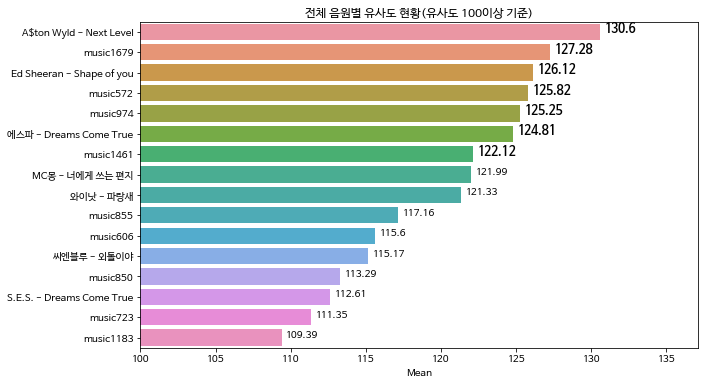

In [ ]:
music_a = '에스파 - Next Level'
df_name = df_total_trim_v2_norm
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
Ed Sheeran - Shape of you  127.958421  133.55   9구간 & 5구간    1.58
music1461                  126.575000  129.27  11구간 & 3구간    0.67
music1398                  125.470000  125.47   3구간 & 2구간    0.33
A$ton Wyld - Next Level    124.580000  131.28   3구간 & 3구간    1.71
music1679                  122.750000  122.75   3구간 & 1구간    0.50
music1183                  119.600000  119.60   1구간 & 1구간    0.33
MC몽 - 너에게 쓰는 편지            119.350000  119.35   4구간 & 9구간    0.10
-------------------------------------------------------------------------------------


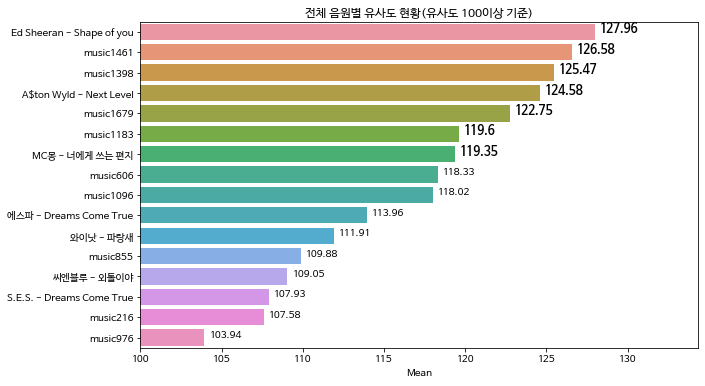

In [ ]:
music_a = '에스파 - Next Level'
df_name = df_total_trim_v2_norm
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
S.E.S. - Dreams Come True  158.710000  170.72   2구간 & 5구간    3.00
씨엔블루 - 외톨이야                156.060000  160.36   1구간 & 2구간    0.27
와이낫 - 파랑새                  151.224444  162.27   3구간 & 8구간    0.90
music795                   128.810000  128.81  10구간 & 3구간    0.33
FTISLAND - 사랑앓이            126.370000  126.37  10구간 & 4구간    0.08
-------------------------------------------------------------------------------------


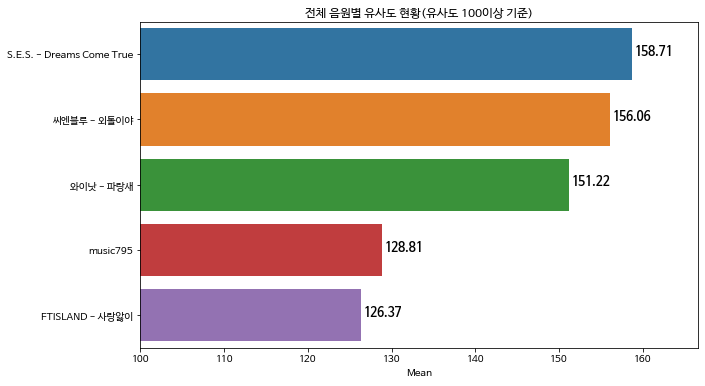

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = df_total_trim_v2_norm
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
S.E.S. - Dreams Come True  155.290303  164.74   2구간 & 5구간    2.75
씨엔블루 - 외톨이야                151.946667  155.25   1구간 & 2구간    0.27
와이낫 - 파랑새                  147.954545  156.28   4구간 & 7구간    1.10
music795                   125.170000  125.17  10구간 & 3구간    0.33
FTISLAND - 사랑앓이            124.850000  124.85  10구간 & 4구간    0.08
music544                   122.290000  122.29  10구간 & 3구간    0.33
-------------------------------------------------------------------------------------


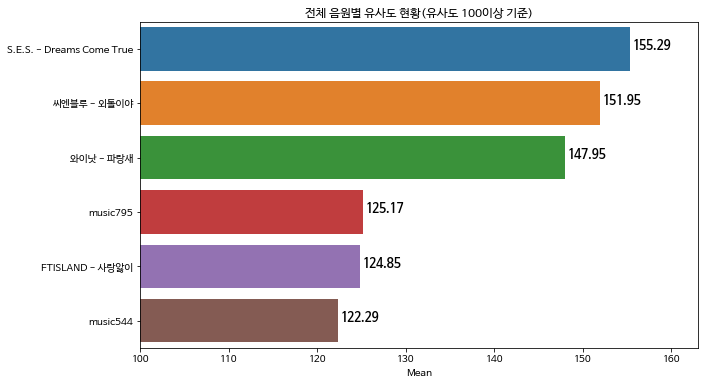

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = df_total_trim_v2_norm
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '3', sim_info_table_ALL) # 결과 저장

In [ ]:
pd.DataFrame(sim_info_dict)

씨엔블루 - 외톨이야  S.E.S. - Dreams Come True  ...  music795  FTISLAND - 사랑앓이
1_2         160.36                     151.82  ...       NaN              NaN
1_1         155.06                        NaN  ...       NaN              NaN
1_3         152.76                        NaN  ...       NaN              NaN
1_10           NaN                     154.24  ...       NaN              NaN
2_5            NaN                     170.72  ...       NaN              NaN
2_4            NaN                     167.63  ...       NaN              NaN
2_8            NaN                     167.19  ...       NaN              NaN
2_7            NaN                     167.09  ...       NaN              NaN
2_11           NaN                     164.64  ...       NaN              NaN
3_4            NaN                     162.69  ...       NaN              NaN
3_11           NaN                     162.29  ...       NaN              NaN
3_5            NaN                     155.57  ...       NaN              NaN
3_7            NaN                     154.66  ...       NaN              NaN
4_11           NaN                     152.41  ...       NaN              NaN
4_5            NaN                     150.06  ...       NaN              NaN
5_5            NaN                     167.06  ...       NaN              NaN
5_7            NaN                     166.54  ...       NaN              NaN
5_4            NaN                     166.19  ...       NaN              NaN
5_2            NaN                     165.24  ...       NaN              NaN
5_8            NaN                     164.94  ...       NaN              NaN
6_4            NaN                     169.06  ...       NaN              NaN
6_11           NaN                     168.01  ...       NaN              NaN
6_5            NaN                     163.56  ...       NaN              NaN
6_7            NaN                     162.83  ...       NaN              NaN
6_8            NaN                     160.22  ...       NaN              NaN
7_11           NaN                     167.47  ...       NaN              NaN
7_4            NaN                     157.94  ...       NaN              NaN
7_5            NaN                     157.19  ...       NaN              NaN
8_5            NaN                     142.56  ...       NaN              NaN
8_11           NaN                     141.77  ...       NaN              NaN
9_7            NaN                     165.63  ...       NaN              NaN
9_5            NaN                     164.96  ...       NaN              NaN
9_8            NaN                     164.72  ...       NaN              NaN
9_4            NaN                     164.07  ...       NaN              NaN
9_11           NaN                     162.82  ...       NaN              NaN
10_12          NaN                     137.48  ...       NaN              NaN
10_11          NaN                     127.60  ...       NaN              NaN
10_1           NaN                     124.69  ...       NaN              NaN
3_8            NaN                        NaN  ...       NaN              NaN
4_8            NaN                        NaN  ...       NaN              NaN
4_7            NaN                        NaN  ...       NaN              NaN
7_1            NaN                        NaN  ...       NaN              NaN
7_7            NaN                        NaN  ...       NaN              NaN
8_4            NaN                        NaN  ...       NaN              NaN
8_9            NaN                        NaN  ...       NaN              NaN
10_3           NaN                        NaN  ...    128.81              NaN
10_4           NaN                        NaN  ...       NaN           126.37

[47 rows x 5 columns]

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                                   Mean     Max       Max구간  매칭횟수비율
music148                     144.140000  148.16   7구간 & 2구간    1.00
FTISLAND - 사랑앓이              140.536667  140.98  8구간 & 11구간    0.25
S.E.S. - Dreams Come True    139.737500  144.54  7구간 & 10구간    0.67
music885                     139.370000  140.58   2구간 & 2구간    1.67
씨엔블루 - 외톨이야                  137.574706  144.41   8구간 & 6구간    1.55
music1339                    137.292500  141.26   3구간 & 1구간    1.33
Harold Faltermeyer - Axel F  136.660000  141.40   6구간 & 8구간    0.56
-------------------------------------------------------------------------------------


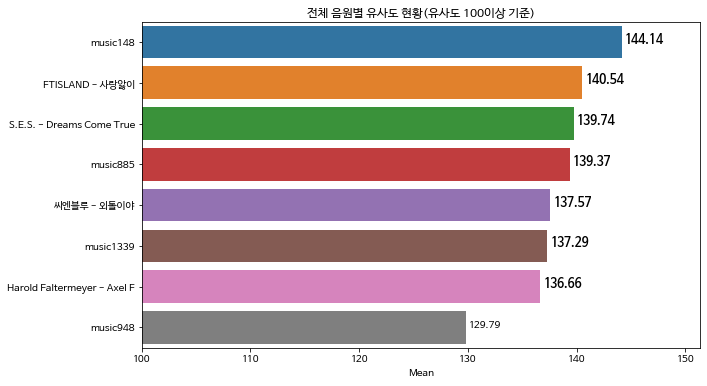

In [ ]:
music_a = '싸이 - 챔피언'
df_name = df_total_trim_v2_norm
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '1', sim_info_table_ALL) # 결과 저장

In [ ]:
play_music('music148', 2, df_total_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                                   Mean     Max       Max구간  매칭횟수비율
music148                     143.707500  152.19   7구간 & 2구간    2.00
music885                     142.716667  146.39   7구간 & 3구간    3.00
Harold Faltermeyer - Axel F  139.130909  144.33   4구간 & 8구간    1.22
FTISLAND - 사랑앓이              138.580000  138.97  8구간 & 11구간    0.25
music2020                    136.820000  140.37   6구간 & 1구간    1.00
music948                     135.940000  135.94   9구간 & 3구간    0.33
씨엔블루 - 외톨이야                  135.370000  140.94   8구간 & 6구간    1.00
-------------------------------------------------------------------------------------


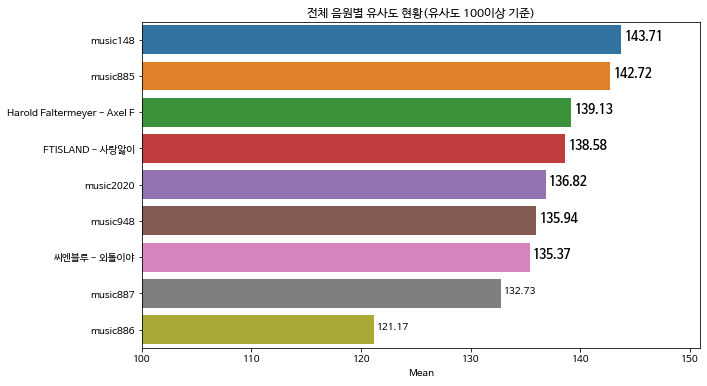

In [ ]:
music_a = '싸이 - 챔피언'
df_name = df_total_trim_v2_norm
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '3', sim_info_table_ALL) # 결과 저장

In [ ]:
pd.DataFrame(sim_info_dict)

Harold Faltermeyer - Axel F  씨엔블루 - 외톨이야  ...  music148  music948
1_5                        130.58          NaN  ...       NaN       NaN
4_8                        140.75          NaN  ...       NaN       NaN
6_8                        141.40          NaN  ...       NaN       NaN
9_9                        137.30          NaN  ...       NaN       NaN
9_8                        133.27          NaN  ...       NaN       NaN
1_9                           NaN       127.80  ...       NaN       NaN
1_6                           NaN       124.77  ...       NaN       NaN
1_8                           NaN       124.74  ...       NaN       NaN
2_6                           NaN       140.46  ...       NaN       NaN
2_2                           NaN       138.61  ...       NaN       NaN
3_6                           NaN       144.24  ...       NaN       NaN
3_2                           NaN       140.68  ...       NaN       NaN
4_6                           NaN       142.74  ...       NaN       NaN
4_2                           NaN       140.85  ...       NaN       NaN
4_3                           NaN       136.60  ...       NaN       NaN
5_6                           NaN       141.29  ...       NaN       NaN
5_2                           NaN       139.21  ...       NaN       NaN
6_6                           NaN       140.38  ...       NaN       NaN
6_2                           NaN       137.38  ...       NaN       NaN
7_6                           NaN       143.01  ...       NaN       NaN
8_6                           NaN       144.41  ...       NaN       NaN
9_11                          NaN       131.60  ...       NaN       NaN
1_10                          NaN          NaN  ...       NaN       NaN
2_10                          NaN          NaN  ...       NaN       NaN
3_10                          NaN          NaN  ...       NaN       NaN
4_10                          NaN          NaN  ...       NaN       NaN
5_10                          NaN          NaN  ...       NaN       NaN
6_10                          NaN          NaN  ...       NaN       NaN
7_10                          NaN          NaN  ...       NaN       NaN
8_10                          NaN          NaN  ...       NaN       NaN
2_3                           NaN          NaN  ...       NaN       NaN
5_3                           NaN          NaN  ...       NaN       NaN
7_3                           NaN          NaN  ...       NaN       NaN
3_1                           NaN          NaN  ...       NaN       NaN
6_1                           NaN          NaN  ...       NaN       NaN
8_1                           NaN          NaN  ...       NaN       NaN
9_3                           NaN          NaN  ...       NaN    129.79
8_11                          NaN          NaN  ...       NaN       NaN
7_2                           NaN          NaN  ...    148.16       NaN
7_1                           NaN          NaN  ...    140.12       NaN

[40 rows x 8 columns]

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                        Mean     Max        Max구간  매칭횟수비율
music850          135.391250  140.35    4구간 & 2구간    4.00
music1461         129.832000  133.61   11구간 & 3구간    1.67
music963          129.340000  129.86    5구간 & 1구간    0.67
music220          128.703333  130.15    5구간 & 1구간    1.00
에스파 - Next Level  127.991538  135.92    9구간 & 9구간    1.18
music572          127.860000  127.86    9구간 & 3구간    0.33
씨엔블루 - 외톨이야       126.880000  128.61  11구간 & 10구간    0.36
-------------------------------------------------------------------------------------


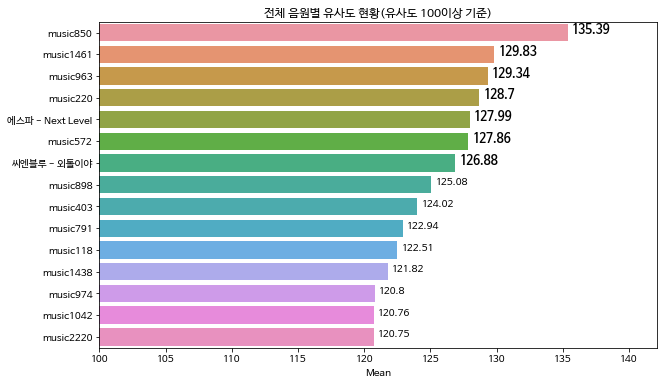

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = df_total_trim_v2_norm
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '1', sim_info_table_ALL) # 결과 저장

In [ ]:
play_music('music850', 2, df_total_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                        Mean     Max       Max구간  매칭횟수비율
music850          133.430000  136.41   4구간 & 2구간    3.00
music1461         130.202000  133.44  11구간 & 3구간    1.67
에스파 - Next Level  129.104000  133.55   5구간 & 9구간    1.36
music220          128.258000  134.05   5구간 & 1구간    1.67
music898          126.291429  130.51   5구간 & 2구간    2.33
music403          124.851000  129.97   8구간 & 1구간    3.33
music963          124.660000  124.66  12구간 & 3구간    0.33
-------------------------------------------------------------------------------------


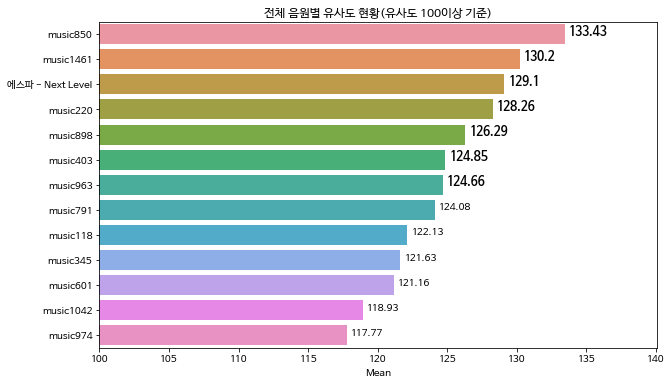

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = df_total_trim_v2_norm
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
S.E.S. - Dreams Come True  150.230000  150.23   7구간 & 4구간    0.08
더더 - It’s you              149.800000  159.91  10구간 & 5구간    0.73
씨엔블루 - 외톨이야                148.688077  162.49  11구간 & 6구간    2.36
요시마타 료 - Resolver          145.050000  147.62   3구간 & 3구간    0.33
music77                    134.995000  137.48  12구간 & 2구간    1.00
music897                   133.730000  136.59  12구간 & 3구간    0.67
music1885                  130.946667  134.02   1구간 & 3구간    1.00
-------------------------------------------------------------------------------------


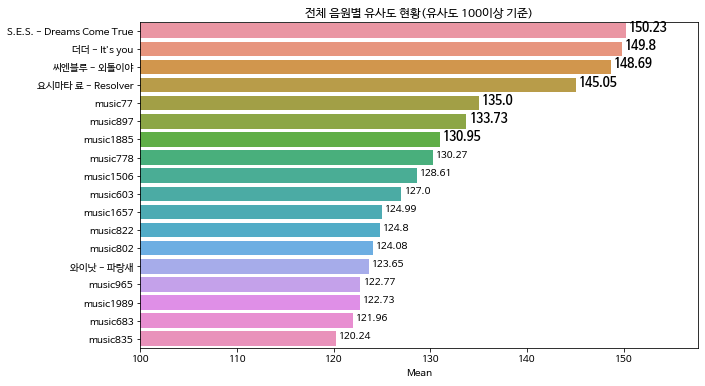

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = df_total_trim_v2_norm
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                         Mean     Max       Max구간  매칭횟수비율
더더 - It’s you      145.448000  157.18  10구간 & 3구간    0.91
씨엔블루 - 외톨이야        143.543913  159.47   7구간 & 6구간    2.09
요시마타 료 - Resolver  140.270000  143.95   3구간 & 3구간    0.33
music77            133.060000  143.19  12구간 & 2구간    1.00
music603           132.930000  132.93   1구간 & 1구간    0.33
music1885          128.456667  132.35   1구간 & 3구간    1.00
music1657          126.025000  133.59   5구간 & 1구간    2.00
-------------------------------------------------------------------------------------


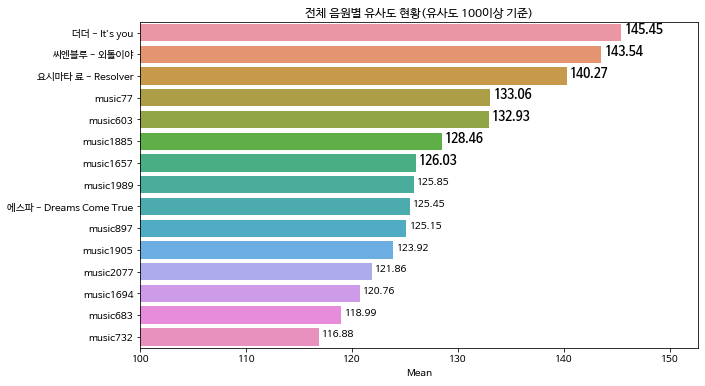

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = df_total_trim_v2_norm
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
에스파 - Dreams Come True     157.710000  160.36   2구간 & 1구간    0.20
FTISLAND - 사랑앓이            156.971250  162.49  6구간 & 11구간    0.67
S.E.S. - Dreams Come True  155.101111  161.71  6구간 & 10구간    1.50
와이낫 - 파랑새                  153.260625  162.33   4구간 & 4구간    1.60
더더 - It’s you              141.900000  149.36  10구간 & 6구간    0.27
MC몽 - 너에게 쓰는 편지            141.298000  148.60   9구간 & 9구간    0.50
TLC - No Scrubs            138.860000  144.04  10구간 & 5구간    0.27
-------------------------------------------------------------------------------------


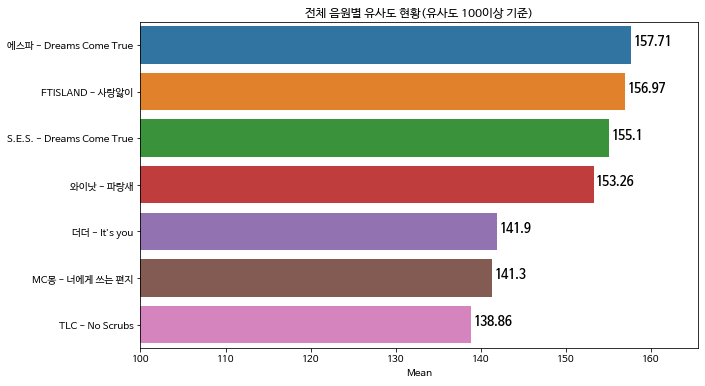

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = df_total_trim_v2_norm
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
에스파 - Dreams Come True     153.325000  155.25   2구간 & 1구간    0.20
S.E.S. - Dreams Come True  149.875714  157.22  6구간 & 10구간    1.17
와이낫 - 파랑새                  148.396667  156.65   4구간 & 4구간    1.50
FTISLAND - 사랑앓이            147.447500  159.47   6구간 & 7구간    1.33
더더 - It’s you              138.840000  145.11  10구간 & 6구간    0.18
TLC - No Scrubs            136.267500  143.26  10구간 & 5구간    0.36
MC몽 - 너에게 쓰는 편지            135.750000  139.73  10구간 & 9구간    0.20
-------------------------------------------------------------------------------------


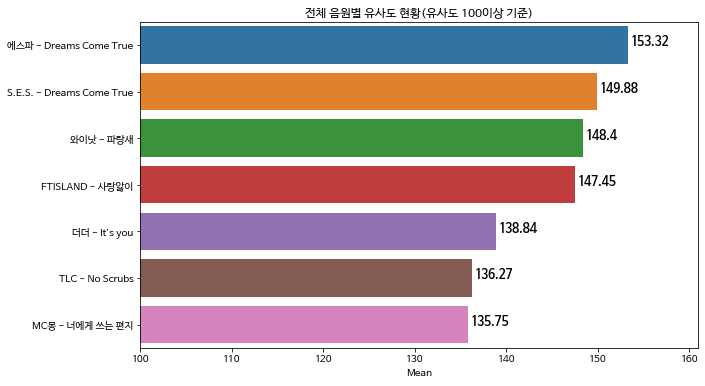

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = df_total_trim_v2_norm
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                       Mean     Max       Max구간  매칭횟수비율
씨엔블루 - 외톨이야      138.212000  148.60   9구간 & 9구간    3.18
FTISLAND - 사랑앓이  136.610000  139.62   6구간 & 6구간    0.25
TLC - No Scrubs  136.076667  142.15   8구간 & 6구간    0.27
더더 - It’s you    134.150000  137.45   3구간 & 6구간    0.18
music1901        131.860000  131.86  10구간 & 1구간    1.00
music631         128.150000  128.15  10구간 & 1구간    1.00
music1649        125.780000  125.78  10구간 & 1구간    1.00
-------------------------------------------------------------------------------------


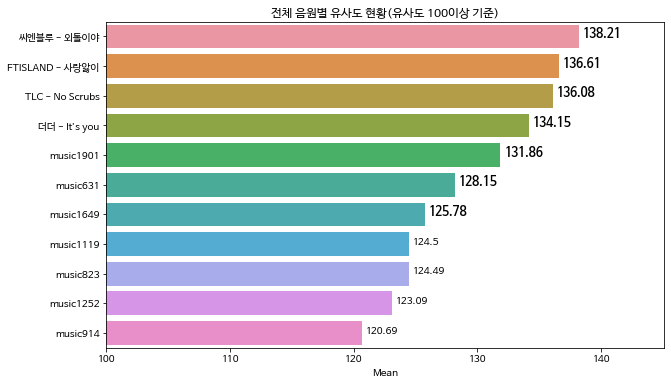

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = df_total_trim_v2_norm
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '1', sim_info_table_ALL) # 결과 저장

In [ ]:
play_music('MC몽 - 너에게 쓰는 편지', 9, df_total_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
play_music('씨엔블루 - 외톨이야', 9, df_total_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                       Mean     Max       Max구간  매칭횟수비율
music1901        137.210000  137.21  10구간 & 1구간    1.00
씨엔블루 - 외톨이야      130.125714  139.73  9구간 & 10구간    2.55
TLC - No Scrubs  130.081250  136.40   8구간 & 6구간    0.73
music1252        129.180000  129.18  10구간 & 1구간    0.33
더더 - It’s you    127.666000  131.95   6구간 & 6구간    0.45
music823         123.850000  123.85   1구간 & 2구간    0.50
music631         122.210000  122.21  10구간 & 1구간    1.00
-------------------------------------------------------------------------------------


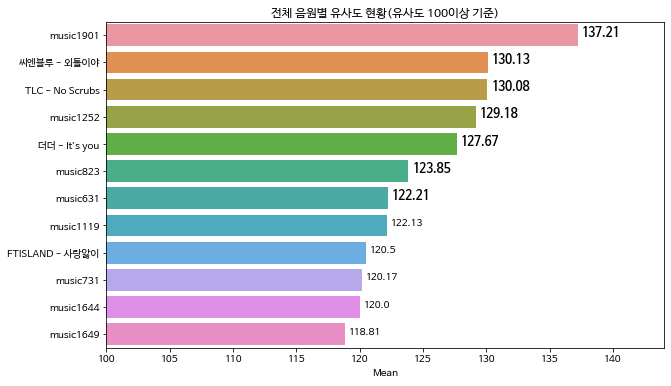

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = df_total_trim_v2_norm
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '원래 음원', '3', sim_info_table_ALL) # 결과 저장

#### (Vocal 기준) 특정 음원과 전체 음원간 유사도 측정 및 결과 시각화

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
A$ton Wyld - Next Level    120.110000  140.92   9구간 & 4구간    0.71
씨엔블루 - 외톨이야                116.059333  137.26  6구간 & 10구간    1.36
FTISLAND - 사랑앓이            105.880000  108.20  10구간 & 5구간    0.17
TLC - No Scrubs            103.725000  104.01   8구간 & 6구간    0.18
Ed Sheeran - Shape of you  100.860000  100.86   1구간 & 1구간    0.08
-------------------------------------------------------------------------------------


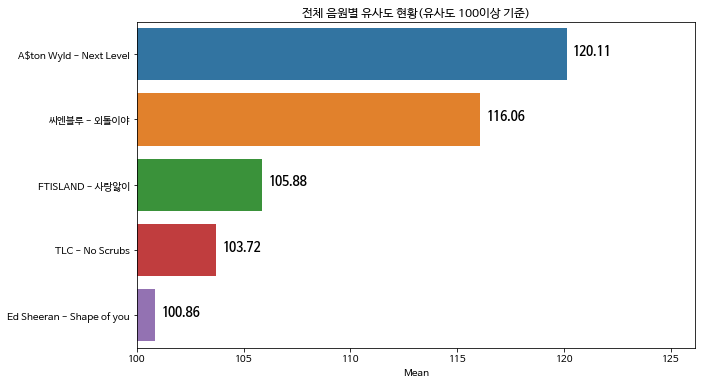

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '1', sim_info_table_ALL) # 결과 저장

In [ ]:
play_music('A$ton Wyld - Next Level', 4, df_total_sepVocal_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
play_music('MC몽 - 너에게 쓰는 편지', 9, df_total_sepVocal_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = '더더 - It’s you'
order = 3
df_name = df_total_sepVocal_trim_v2_norm # 보컬 추출

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = 'MC몽 - 너에게 쓰는 편지'
order = 3
df_name = df_total_sepVocal_trim_v2_norm # 보컬 추출

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = 'A$ton Wyld - Next Level'
order = 2
df_name = df_total_sepVocal_trim_v2_norm # 보컬 추출

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = '씨엔블루 - 외톨이야'
order = 6
df_name = df_total_sepVocal_trim_v2_norm # 보컬 추출

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = '요시마타 료 - Resolver'
order = 2
df_name = df_total_sepOther_trim_v2_norm # 보컬 제외

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = 'FTISLAND - 사랑앓이'
order = 1
df_name = df_total_sepOther_trim_v2_norm # 보컬 제외

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = 'music1458'
order = 1
df_name = df_total_sepOther_trim_v2_norm # 보컬 제외

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = 'FTISLAND - 사랑앓이'
order = 11
df_name = df_total_trim_v2_norm # 원래 음원

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                            Mean     Max       Max구간  매칭횟수비율
A$ton Wyld - Next Level  122.742  144.94   9구간 & 4구간    0.71
씨엔블루 - 외톨이야              118.615  137.89  6구간 & 10구간    1.27
TLC - No Scrubs          114.855  116.12   8구간 & 6구간    0.18
-------------------------------------------------------------------------------------


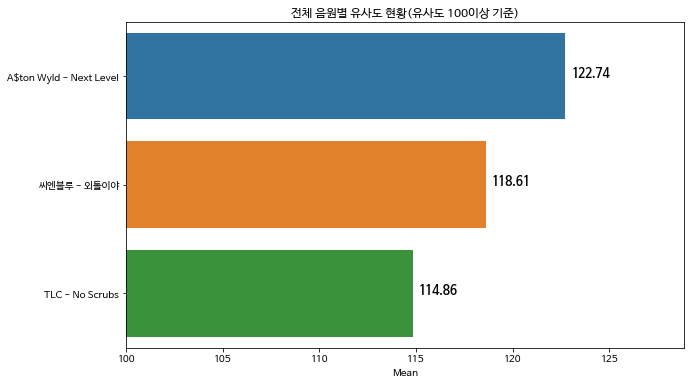

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                       Mean     Max       Max구간  매칭횟수비율
MC몽 - 너에게 쓰는 편지  116.003846  137.26  10구간 & 6구간    1.30
와이낫 - 파랑새        111.630000  111.63   8구간 & 4구간    0.10
싸이 - 챔피언         109.764000  118.79   2구간 & 2구간    0.56
FTISLAND - 사랑앓이  107.156000  114.69   4구간 & 6구간    0.83
-------------------------------------------------------------------------------------


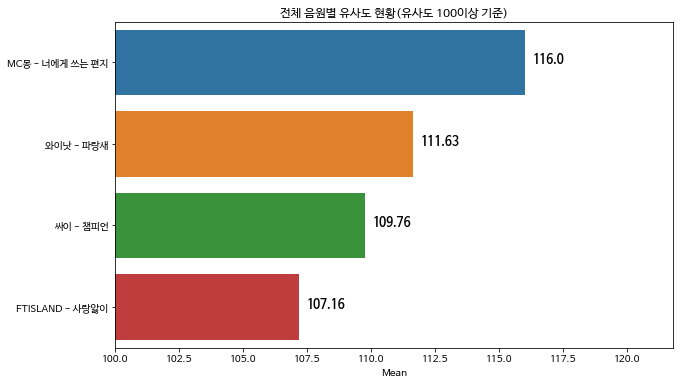

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                       Mean     Max       Max구간  매칭횟수비율
MC몽 - 너에게 쓰는 편지  121.050909  137.89  10구간 & 6구간    1.10
싸이 - 챔피언         115.181429  130.24   2구간 & 2구간    0.78
TLC - No Scrubs  107.020000  107.02  11구간 & 6구간    0.09
와이낫 - 파랑새        106.040000  111.85   8구간 & 4구간    0.20
-------------------------------------------------------------------------------------


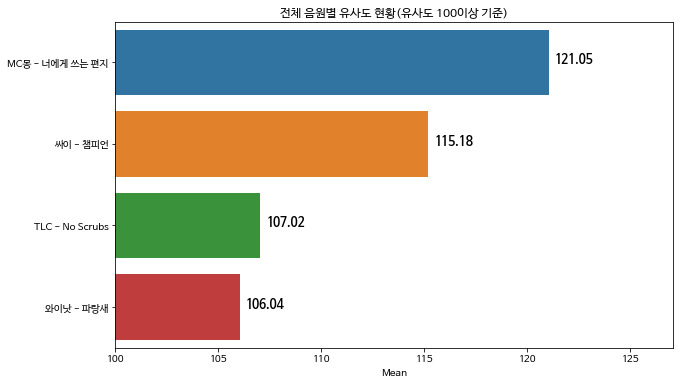

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                                   Mean     Max       Max구간  매칭횟수비율
요시마타 료 - Resolver            119.583333  128.36   1구간 & 2구간    1.00
Harold Faltermeyer - Axel F  113.340000  113.34   1구간 & 4구간    0.11
씨엔블루 - 외톨이야                  107.798889  114.69   6구간 & 4구간    0.82
TLC - No Scrubs              106.785000  107.37   2구간 & 6구간    0.18
에스파 - Dreams Come True       106.516667  112.31  11구간 & 6구간    0.30
싸이 - 챔피언                     106.120000  106.12   5구간 & 1구간    0.11
MC몽 - 너에게 쓰는 편지              105.880000  108.20  5구간 & 10구간    0.20
-------------------------------------------------------------------------------------


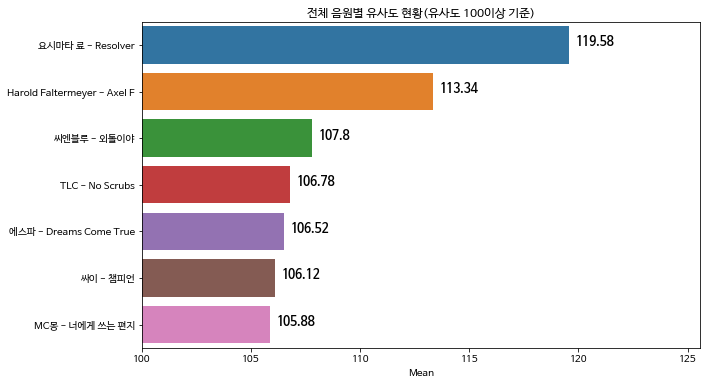

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '1', sim_info_table_ALL) # 결과 저장

In [ ]:
label = '요시마타 료 - Resolver'
order = 2
df_name = df_total_sepVocal_trim_v2_norm # 보컬 추출

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = 'FTISLAND - 사랑앓이'
order = 1
df_name = df_total_sepVocal_trim_v2_norm # 보컬 추출

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                               Mean     Max       Max구간  매칭횟수비율
요시마타 료 - Resolver            113.44  126.56   1구간 & 2구간    1.00
Harold Faltermeyer - Axel F  110.15  110.15   1구간 & 4구간    0.11
TLC - No Scrubs              107.32  107.32   2구간 & 6구간    0.09
싸이 - 챔피언                     107.08  107.08   5구간 & 1구간    0.11
에스파 - Dreams Come True       106.35  106.35  11구간 & 6구간    0.10
-------------------------------------------------------------------------------------


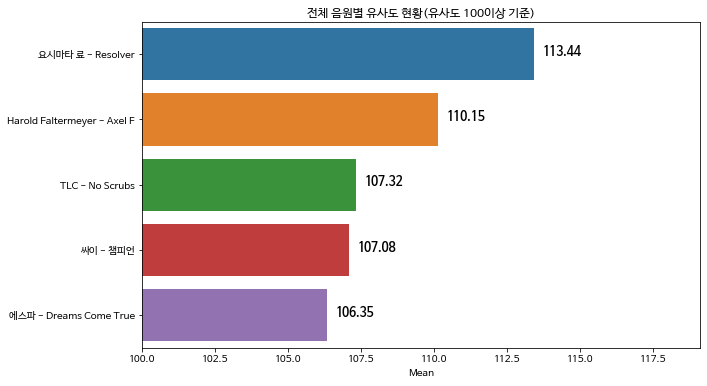

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '3', sim_info_table_ALL) # 결과 저장

In [ ]:
pd.DataFrame(sim_info_dict)

요시마타 료 - Resolver  ...  에스파 - Dreams Come True
1_2              128.36  ...                     NaN
1_6              121.98  ...                     NaN
1_5              121.11  ...                     NaN
1_3              120.43  ...                     NaN
5_2              114.79  ...                     NaN
5_3              110.83  ...                     NaN
1_4                 NaN  ...                     NaN
2_5                 NaN  ...                     NaN
3_3                 NaN  ...                     NaN
3_6                 NaN  ...                     NaN
6_4                 NaN  ...                     NaN
6_6                 NaN  ...                     NaN
6_5                 NaN  ...                     NaN
6_7                 NaN  ...                     NaN
6_3                 NaN  ...                     NaN
9_6                 NaN  ...                     NaN
2_6                 NaN  ...                     NaN
5_1                 NaN  ...                     NaN
2_9                 NaN  ...                     NaN
5_10                NaN  ...                     NaN
11_6                NaN  ...                  112.31
11_3                NaN  ...                  104.66
11_7                NaN  ...                  102.58

[23 rows x 7 columns]

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                   Mean     Max      Max구간  매칭횟수비율
MC몽 - 너에게 쓰는 편지  100.86  100.86  1구간 & 1구간     0.1
-------------------------------------------------------------------------------------


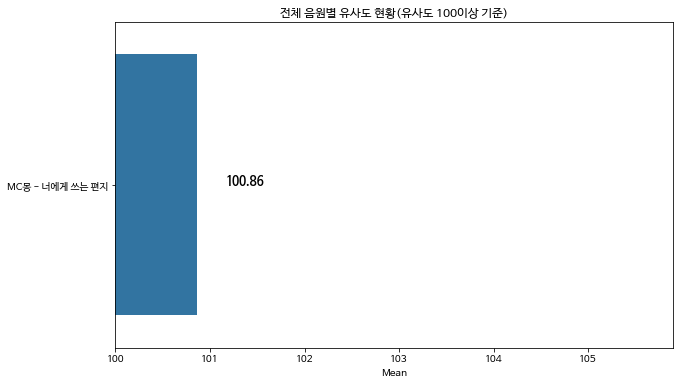

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                        Mean     Max      Max구간  매칭횟수비율
에스파 - Next Level  104.688571  108.08  6구간 & 9구간    0.64
-------------------------------------------------------------------------------------


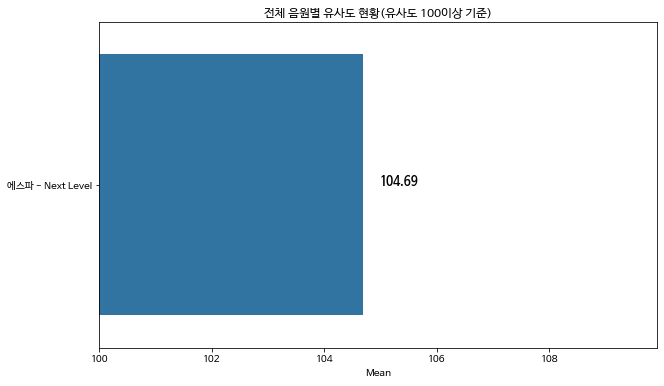

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                        Mean     Max       Max구간  매칭횟수비율
씨엔블루 - 외톨이야       109.764000  118.79   2구간 & 2구간    0.45
와이낫 - 파랑새         105.930000  105.93   7구간 & 8구간    0.10
FTISLAND - 사랑앓이   105.803333  107.81   9구간 & 1구간    0.25
에스파 - Next Level  105.238000  110.65  5구간 & 11구간    0.91
TLC - No Scrubs   102.000000  102.00   5구간 & 8구간    0.09
-------------------------------------------------------------------------------------


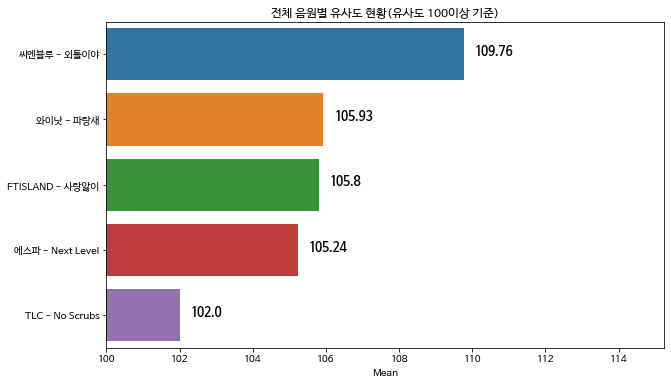

In [ ]:
music_a = '싸이 - 챔피언'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                         Mean     Max       Max구간  매칭횟수비율
씨엔블루 - 외톨이야        116.816667  130.24   2구간 & 2구간    0.55
에스파 - Next Level   111.398235  122.53  4구간 & 11구간    1.55
FTISLAND - 사랑앓이    107.080000  107.08   1구간 & 5구간    0.08
요시마타 료 - Resolver  106.190000  106.19   1구간 & 1구간    0.17
-------------------------------------------------------------------------------------


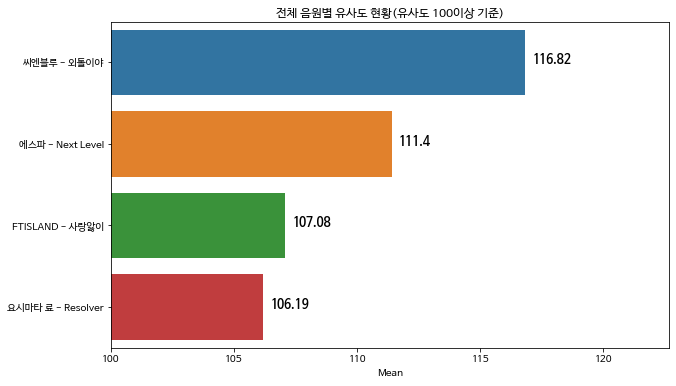

In [ ]:
music_a = '싸이 - 챔피언'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
더더 - It’s you              121.643333  134.10   6구간 & 3구간    0.27
A$ton Wyld - Next Level    114.370000  114.37   1구간 & 1구간    0.14
TLC - No Scrubs            110.845000  117.86  4구간 & 10구간    0.91
에스파 - Dreams Come True     110.782000  126.16   7구간 & 9구간    0.50
S.E.S. - Dreams Come True  109.000000  111.70   6구간 & 9구간    0.17
싸이 - 챔피언                   105.238000  110.65  11구간 & 5구간    1.11
-------------------------------------------------------------------------------------


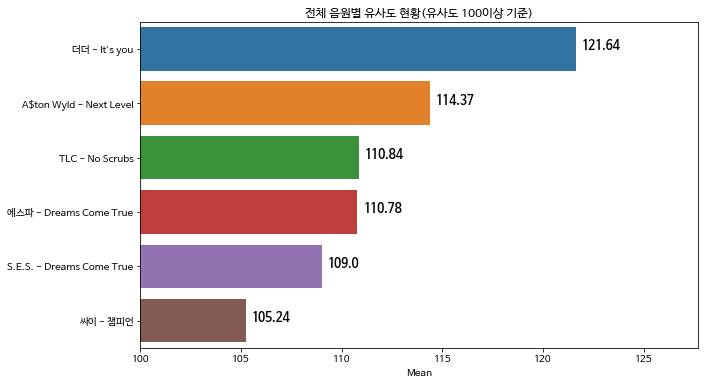

In [ ]:
music_a = '에스파 - Next Level'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
더더 - It’s you              118.940000  122.88   6구간 & 3구간    0.18
싸이 - 챔피언                   111.398235  122.53  11구간 & 4구간    1.89
에스파 - Dreams Come True     108.035000  121.22   7구간 & 9구간    0.40
TLC - No Scrubs            106.990000  114.77   4구간 & 8구간    0.64
Ed Sheeran - Shape of you  105.331667  108.08   9구간 & 6구간    0.50
S.E.S. - Dreams Come True  102.120000  104.03   7구간 & 9구간    0.17
씨엔블루 - 외톨이야                101.830000  101.83   8구간 & 2구간    0.09
-------------------------------------------------------------------------------------


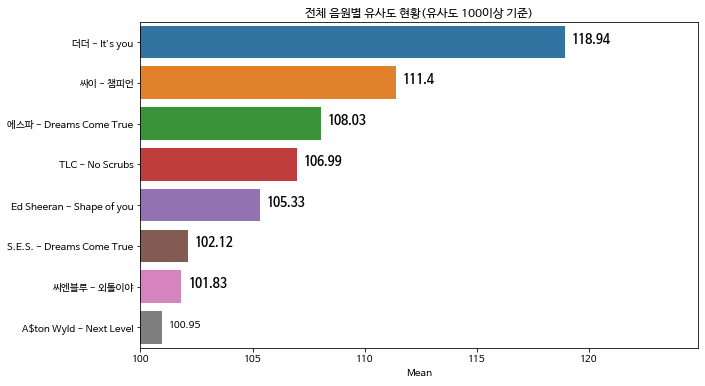

In [ ]:
music_a = '에스파 - Next Level'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
S.E.S. - Dreams Come True  127.429429  147.73  7구간 & 11구간    2.92
FTISLAND - 사랑앓이            112.310000  112.31  6구간 & 11구간    0.08
에스파 - Next Level           111.406000  126.16   9구간 & 7구간    0.45
-------------------------------------------------------------------------------------


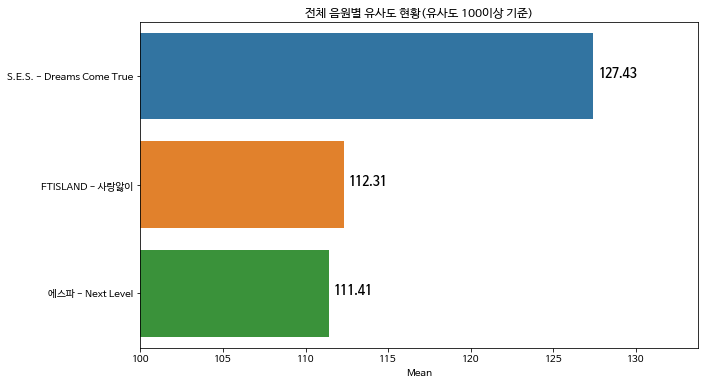

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max      Max구간  매칭횟수비율
S.E.S. - Dreams Come True  130.320303  153.23  6구간 & 4구간    2.75
에스파 - Next Level           108.035000  121.22  9구간 & 7구간    0.36
-------------------------------------------------------------------------------------


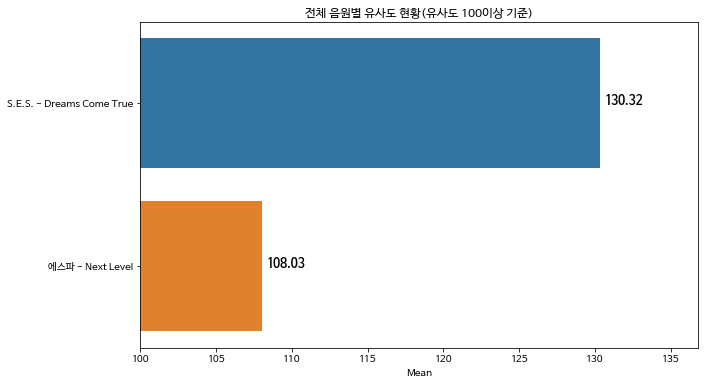

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = df_total_sepVocal_trim_v2_norm # Vocal 추출 기준
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 추출', '3', sim_info_table_ALL) # 결과 저장

In [ ]:
label = '에스파 - Dreams Come True'
order = 7
df_name = df_total_sepVocal_trim_v2_norm # 보컬 추출

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
label = 'S.E.S. - Dreams Come True'
order = 11
df_name = df_total_sepVocal_trim_v2_norm # 보컬 추출

ipd.Audio(df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path'], rate=SAMPLING_RATE)

Output hidden; open in https://colab.research.google.com to view.

#### (Vocal 제외 추출 기준) 특정 음원과 전체 음원간 유사도 측정 및 결과 시각화

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                       Mean     Max       Max구간  매칭횟수비율
music194         129.763333  135.75  10구간 & 1구간    1.00
music1901        125.320000  125.32  10구간 & 1구간    1.00
music2150        122.110000  122.11  10구간 & 1구간    0.33
music1065        117.410000  117.98   1구간 & 3구간    0.67
FTISLAND - 사랑앓이  113.190000  117.83   3구간 & 6구간    0.25
music2245        112.640000  112.64   1구간 & 1구간    0.50
music1878        112.200000  118.05   1구간 & 1구간    1.33
-------------------------------------------------------------------------------------


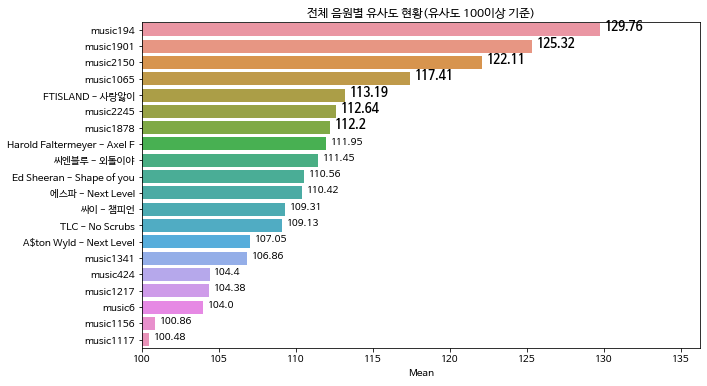

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                Mean     Max       Max구간  매칭횟수비율
music1901                    133.500  133.50  10구간 & 1구간    1.00
music194                     122.016  139.54  10구간 & 1구간    1.67
music2150                    121.410  121.41  10구간 & 1구간    0.33
Harold Faltermeyer - Axel F  116.550  117.32   2구간 & 5구간    0.22
music424                     115.230  115.23   8구간 & 1구간    0.33
music1878                    112.362  117.07   1구간 & 1구간    1.67
music1065                    111.250  112.20   1구간 & 3구간    0.67
-------------------------------------------------------------------------------------


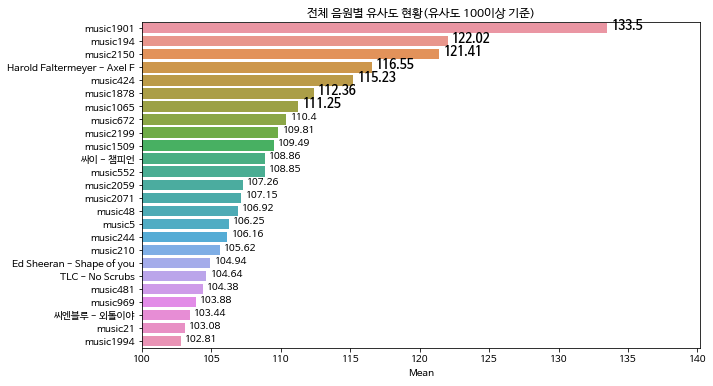

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '3', sim_info_table_ALL) # 결과 저장

In [ ]:
play_music('MC몽 - 너에게 쓰는 편지', 10, df_total_sepOther_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
play_music('music1901', 1, df_total_sepOther_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
FTISLAND - 사랑앓이            157.700000  159.41  10구간 & 7구간    0.17
S.E.S. - Dreams Come True  155.673235  169.36   4구간 & 7구간    2.83
더더 - It’s you              150.930000  154.65  10구간 & 7구간    0.27
music241                   148.300000  148.30  11구간 & 2구간    0.50
TLC - No Scrubs            139.450000  146.40   2구간 & 9구간    0.27
와이낫 - 파랑새                  133.992000  144.19   8구간 & 4구간    0.50
싸이 - 챔피언                   132.302857  141.64   5구간 & 4구간    0.78
-------------------------------------------------------------------------------------


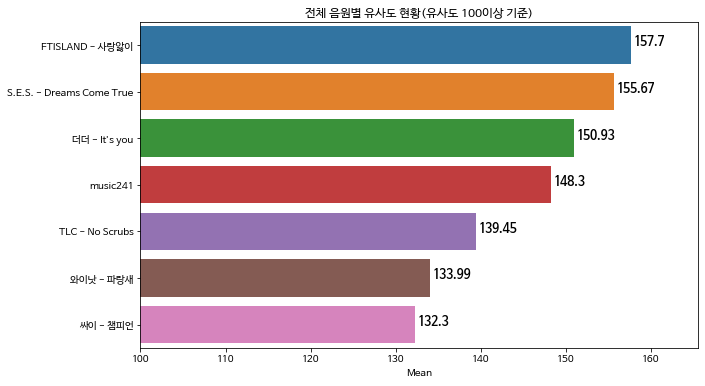

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
FTISLAND - 사랑앓이            151.945000  159.29   4구간 & 7구간    0.33
S.E.S. - Dreams Come True  147.512188  160.58   4구간 & 7구간    2.67
더더 - It’s you              144.557500  149.20  10구간 & 7구간    0.36
music241                   142.740000  142.74  11구간 & 2구간    0.50
싸이 - 챔피언                   135.080000  136.07   1구간 & 7구간    0.44
에스파 - Dreams Come True     129.330000  129.33   1구간 & 1구간    0.10
와이낫 - 파랑새                  128.551429  139.61  8구간 & 10구간    0.70
-------------------------------------------------------------------------------------


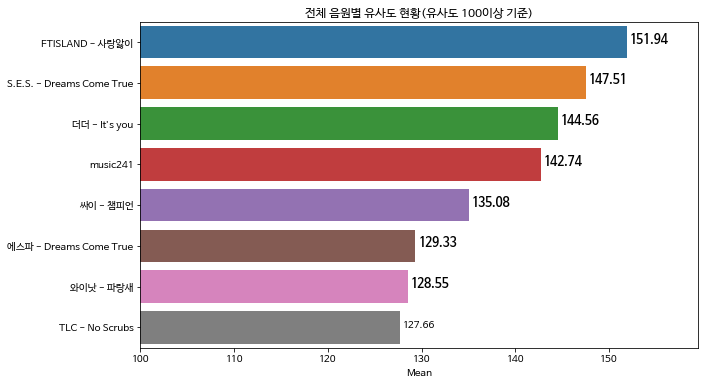

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_3

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                     Mean     Max       Max구간  매칭횟수비율
더더 - It’s you  152.118857  178.70  11구간 & 3구간    3.18
music603       140.010000  140.01   1구간 & 1구간    0.33
music1885      137.450000  141.08   1구간 & 3구간    1.00
music1506      129.860000  129.86   1구간 & 1구간    0.33
music2090      129.170000  129.75   2구간 & 1구간    0.67
music2150      128.040000  135.30   2구간 & 2구간    1.00
씨엔블루 - 외톨이야    126.370000  126.37   4구간 & 8구간    0.09
-------------------------------------------------------------------------------------


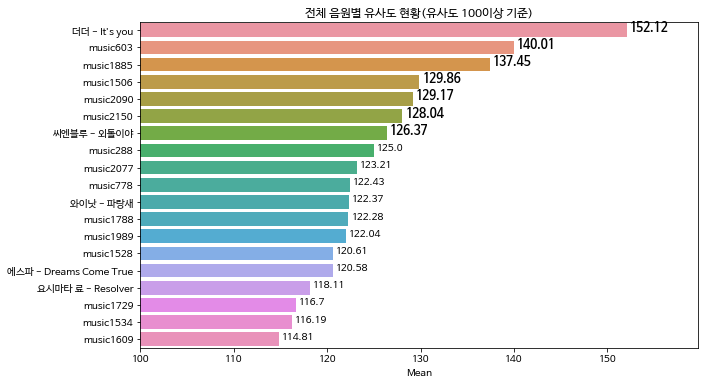

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
              Mean     Max       Max구간  매칭횟수비율
music785   161.040  161.04   1구간 & 1구간    1.00
music368   157.865  158.20   7구간 & 3구간    0.67
music1885  155.440  155.44   1구간 & 3구간    0.33
music1456  149.175  151.16  12구간 & 2구간    0.67
music603   148.480  148.48   1구간 & 1구간    0.33
music1193  146.420  146.42  12구간 & 2구간    0.50
music1657  146.344  151.48   1구간 & 1구간    2.50
-------------------------------------------------------------------------------------


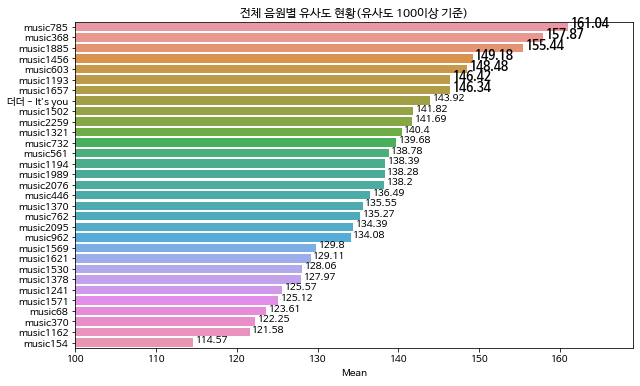

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_2 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '2', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                     Mean     Max       Max구간  매칭횟수비율
더더 - It’s you  145.770588  174.84  11구간 & 3구간    3.09
music603       135.210000  135.21   1구간 & 1구간    0.33
music1885      134.150000  138.38   1구간 & 3구간    1.00
music1657      125.645000  128.66   1구간 & 1구간    2.00
music1989      124.180000  124.18   5구간 & 1구간    0.33
music2077      123.340000  123.34   5구간 & 1구간    0.50
씨엔블루 - 외톨이야    123.200000  123.20   4구간 & 8구간    0.09
-------------------------------------------------------------------------------------


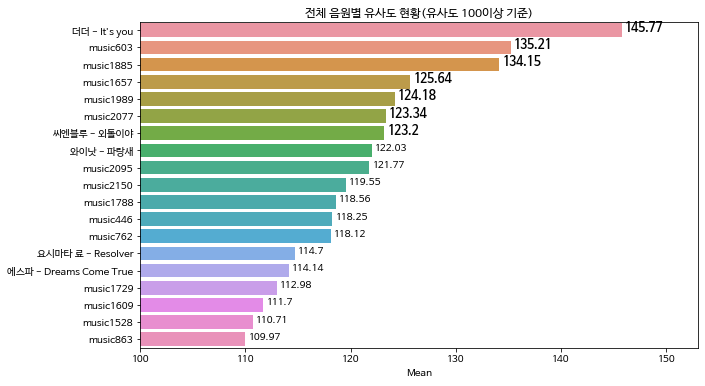

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_3 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                 Mean     Max      Max구간  매칭횟수비율
music1975  129.030000  132.96  2구간 & 1구간    3.00
music220   128.650000  132.72  2구간 & 1구간    2.33
music2158  127.852500  130.85  2구간 & 1구간    2.00
music866   127.366667  128.94  5구간 & 2구간    1.00
music365   126.440000  127.25  5구간 & 2구간    0.67
music2145  125.765000  126.30  5구간 & 1구간    0.67
music2199  125.497500  128.44  2구간 & 2구간    2.00
-------------------------------------------------------------------------------------


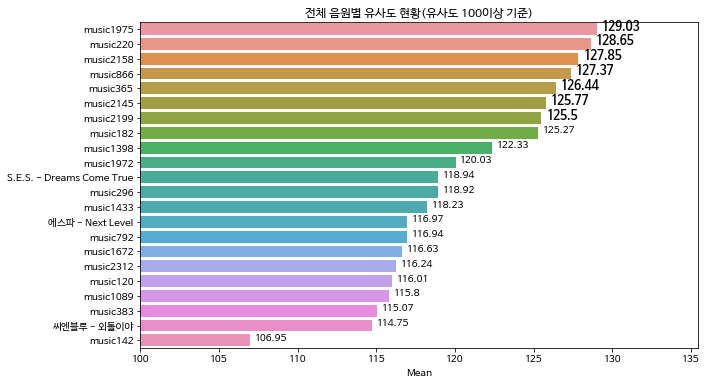

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                 Mean     Max      Max구간  매칭횟수비율
music1309  150.450000  150.45  7구간 & 1구간    0.50
music220   148.756667  157.08  2구간 & 1구간    3.00
music1398  146.765000  152.08  7구간 & 1구간    1.33
music182   145.810000  145.81  7구간 & 2구간    0.50
music139   145.760000  145.76  6구간 & 1구간    0.33
music974   144.392500  151.16  2구간 & 1구간    2.00
music345   143.923333  149.76  6구간 & 1구간    1.00
-------------------------------------------------------------------------------------


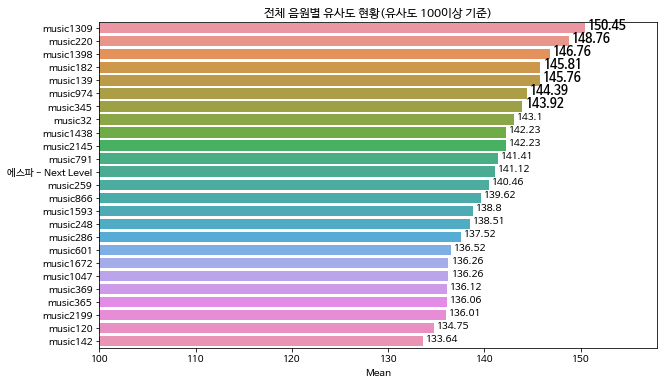

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_2 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '2', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                 Mean     Max       Max구간  매칭횟수비율
music220   128.032857  132.92   3구간 & 1구간    2.33
music2145  127.143333  128.16   6구간 & 3구간    1.00
music1975  127.135000  128.11   2구간 & 1구간    2.00
music1972  125.690000  125.82  11구간 & 1구간    1.00
music2158  124.882000  127.09   2구간 & 1구간    2.50
music1398  124.760000  124.76   7구간 & 1구간    0.33
music120   123.683333  126.14   8구간 & 2구간    1.50
-------------------------------------------------------------------------------------


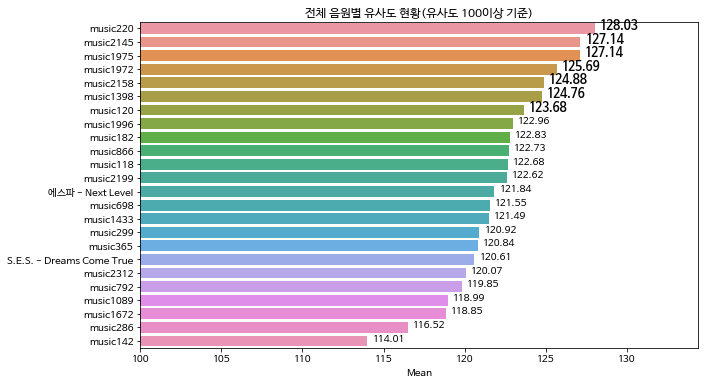

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_3 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                                   Mean     Max       Max구간  매칭횟수비율
FTISLAND - 사랑앓이              142.120000  142.12  3구간 & 11구간    0.08
S.E.S. - Dreams Come True    141.417500  142.18  7구간 & 10구간    0.33
씨엔블루 - 외톨이야                  137.494828  147.48   3구간 & 6구간    2.64
Harold Faltermeyer - Axel F  135.664444  143.05   9구간 & 8구간    1.00
MC몽 - 너에게 쓰는 편지              112.200000  114.12   1구간 & 5구간    0.20
-------------------------------------------------------------------------------------


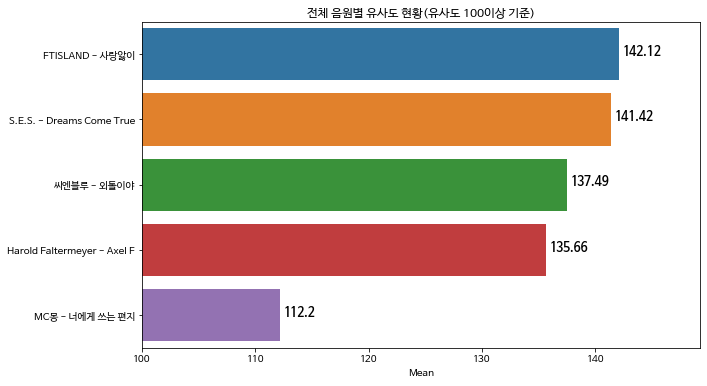

In [ ]:
music_a = '싸이 - 챔피언'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                                   Mean     Max      Max구간  매칭횟수비율
music913                     159.940000  161.85  7구간 & 1구간    1.00
music156                     159.380000  170.73  8구간 & 1구간    4.00
music885                     155.825833  159.50  2구간 & 2구간    4.00
music151                     155.490000  157.20  7구간 & 2구간    1.00
Harold Faltermeyer - Axel F  154.582500  166.47  1구간 & 5구간    0.44
music261                     153.890000  158.22  4구간 & 2구간    2.00
music1560                    152.750000  152.75  4구간 & 2구간    0.50
-------------------------------------------------------------------------------------


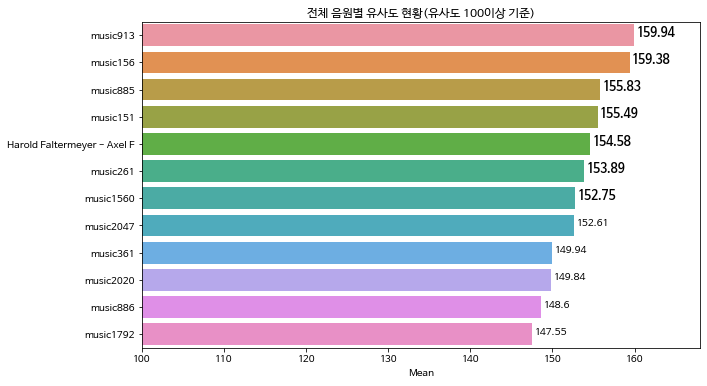

In [ ]:
music_a = '싸이 - 챔피언'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_2 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '2', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                                   Mean     Max       Max구간  매칭횟수비율
FTISLAND - 사랑앓이              139.593333  140.79  3구간 & 11구간    0.25
S.E.S. - Dreams Come True    136.870000  136.87  7구간 & 10구간    0.08
씨엔블루 - 외톨이야                  135.302105  142.85   7구간 & 6구간    1.73
Harold Faltermeyer - Axel F  135.078947  144.50   9구간 & 8구간    2.11
music1346                    128.590000  128.59   9구간 & 1구간    0.33
music1245                    110.210000  110.21   1구간 & 3구간    0.33
MC몽 - 너에게 쓰는 편지              108.860000  108.86   1구간 & 5구간    0.10
-------------------------------------------------------------------------------------


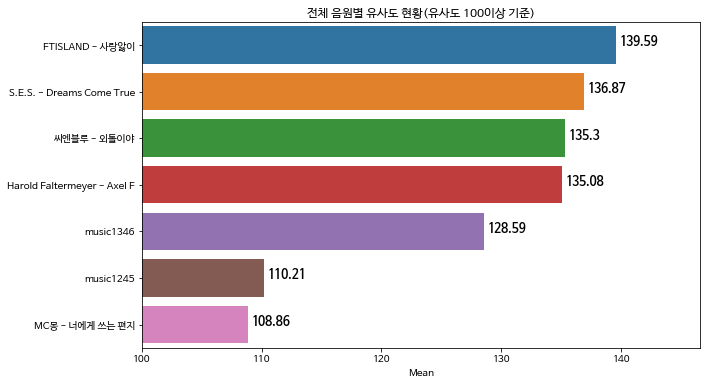

In [ ]:
music_a = '싸이 - 챔피언'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_3 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '3', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                               Mean     Max      Max구간  매칭횟수비율
A$ton Wyld - Next Level  124.954286  142.59  3구간 & 5구간    3.00
music1183                122.040000  122.04  1구간 & 1구간    0.33
TLC - No Scrubs          120.824444  125.14  7구간 & 8구간    0.82
에스파 - Dreams Come True   120.557500  125.51  6구간 & 5구간    0.40
MC몽 - 너에게 쓰는 편지          119.210000  119.21  8구간 & 9구간    0.10
music2299                118.650000  118.65  7구간 & 2구간    0.33
music1458                116.210000  116.21  2구간 & 1구간    0.50
-------------------------------------------------------------------------------------


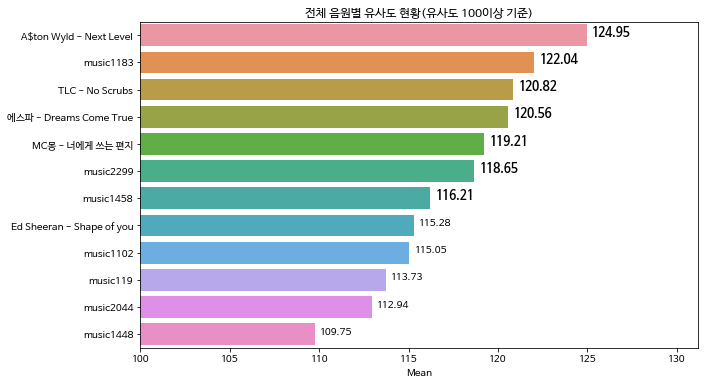

In [ ]:
music_a = '에스파 - Next Level'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
              Mean     Max      Max구간  매칭횟수비율
music1562  160.890  160.89  6구간 & 2구간    0.50
music1448  152.980  152.98  5구간 & 1구간    0.33
music515   151.958  162.75  7구간 & 2구간    2.50
music1468  148.485  152.04  7구간 & 2구간    2.00
music1438  148.240  148.24  5구간 & 3구간    0.33
music2252  147.720  147.72  7구간 & 3구간    0.33
music681   147.350  147.35  6구간 & 3구간    0.33
-------------------------------------------------------------------------------------


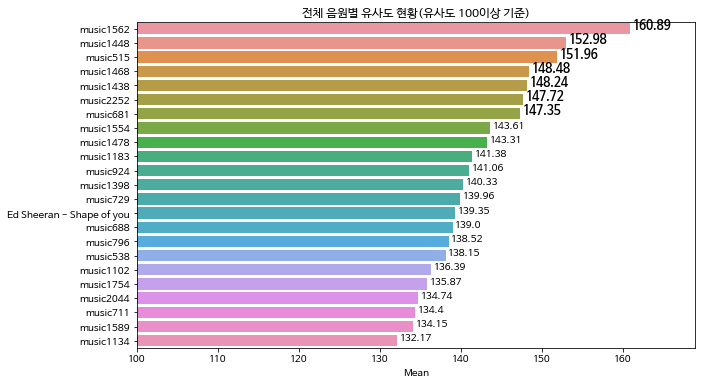

In [ ]:
music_a = '에스파 - Next Level'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_2 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '2', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max        Max구간  매칭횟수비율
music1183                  130.250000  130.25    1구간 & 1구간    0.33
A$ton Wyld - Next Level    124.829167  135.63    3구간 & 3구간    1.71
music1060                  122.450000  122.45    2구간 & 2구간    0.50
music1398                  122.043333  124.79    3구간 & 3구간    1.00
music1102                  120.610000  127.14    1구간 & 3구간    1.33
Ed Sheeran - Shape of you  120.379091  129.98  10구간 & 10구간    0.92
music2044                  119.300000  119.30    1구간 & 2구간    0.50
-------------------------------------------------------------------------------------


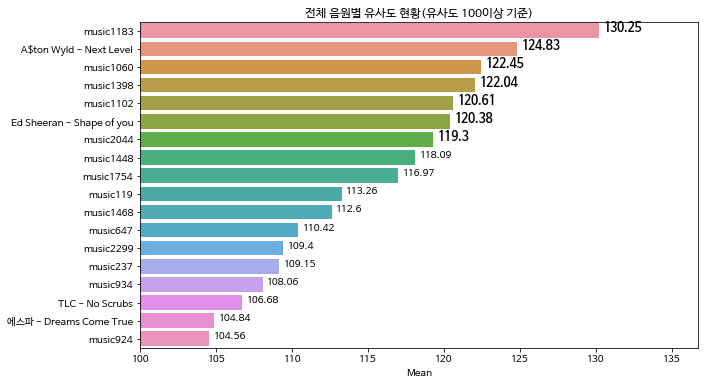

In [ ]:
music_a = '에스파 - Next Level'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_3 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '3', sim_info_table_ALL) # 결과 저장

In [ ]:
play_music('music1183', 1, df_total_sepOther_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
play_music('에스파 - Next Level', 1, df_total_sepOther_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
S.E.S. - Dreams Come True  153.677308  168.63   2구간 & 7구간    2.17
요시마타 료 - Resolver          134.543333  137.82   3구간 & 3구간    0.50
와이낫 - 파랑새                  132.827333  158.88   9구간 & 4구간    1.50
TLC - No Scrubs            126.596667  129.12   1구간 & 9구간    0.27
씨엔블루 - 외톨이야                125.060000  131.69   1구간 & 1구간    0.18
music1026                  116.170000  116.17  10구간 & 2구간    0.33
-------------------------------------------------------------------------------------


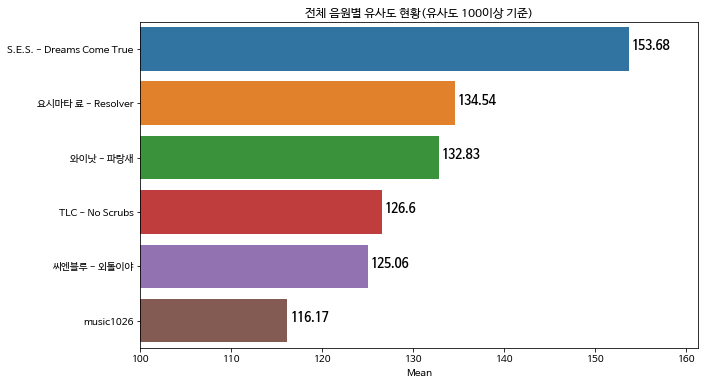

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '1', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
music206                   171.790000  179.81   5구간 & 2구간    1.33
music240                   170.880000  171.04   5구간 & 2구간    1.00
S.E.S. - Dreams Come True  151.494286  168.21   5구간 & 3구간    1.17
music1026                  151.355000  155.27  10구간 & 1구간    0.67
music769                   150.830000  150.83  10구간 & 3구간    0.33
music503                   147.110000  147.11  10구간 & 2구간    0.50
music1149                  144.810000  144.81   1구간 & 2구간    0.50
-------------------------------------------------------------------------------------


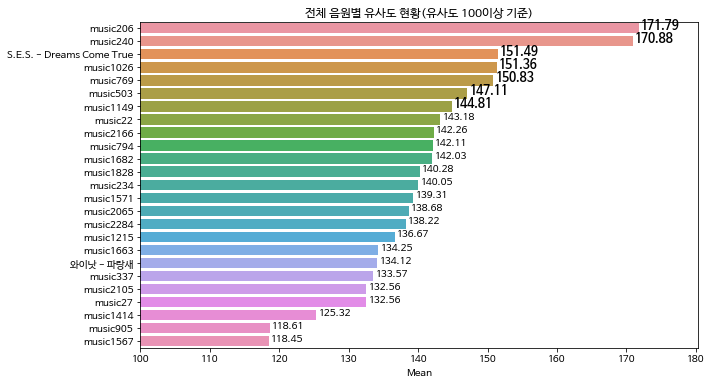

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_2 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '2', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
S.E.S. - Dreams Come True  147.189286  161.69   6구간 & 4구간    2.33
와이낫 - 파랑새                  129.817857  156.84   9구간 & 4구간    1.40
요시마타 료 - Resolver          129.620000  132.45   3구간 & 3구간    0.33
씨엔블루 - 외톨이야                125.330000  129.33   1구간 & 1구간    0.18
TLC - No Scrubs            120.440000  121.73   1구간 & 9구간    0.18
music769                   117.750000  117.75  10구간 & 3구간    0.33
music1026                  117.550000  117.55  10구간 & 2구간    0.33
-------------------------------------------------------------------------------------


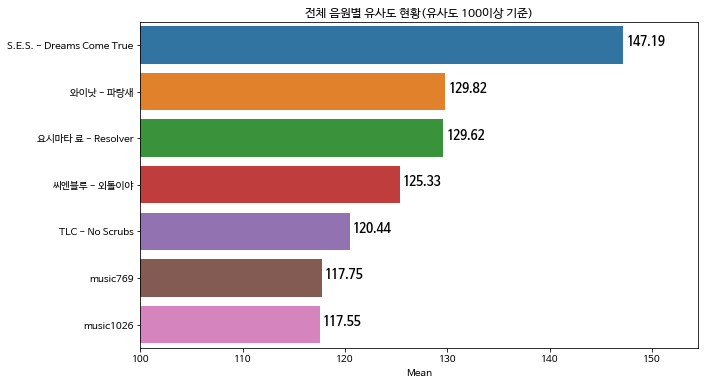

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = df_total_sepOther_trim_v2_norm # Vocal 제외 추출 기준
col_setting = col_names_3 # 컬럼 셋팅값 변경

sim_info_dict = get_sim_info_dict(music_a, df_name, col_setting, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, '보컬 제외', '3', sim_info_table_ALL) # 결과 저장

In [ ]:
play_music('music240', 2, df_total_sepOther_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with open(DIR_PATH + 'test_data/sim_info_table_ALL.pkl','wb') as f:
  pickle.dump(sim_info_table_ALL, f)

In [ ]:
with open(DIR_PATH + 'test_data/sim_info_table_ALL.pkl','rb') as f:
  sim_info_table_ALL = pickle.load(f)

In [ ]:
key_list = sim_info_table_ALL.keys()
for k1 in key_list:
  print(k1, end=' => ')
  for k2 in sim_info_table_ALL[k1].keys():
    print(k2, end=', ')
  print()

에스파 - Next Level => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, AE 추출_all_scalingX, AE 추출_all_pca20, AE 추출2_all, 보컬 추출_3, 
에스파 - Dreams Come True => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, AE 추출_all, AE 추출2_all, AE 추출_all_pca20, VGG 추출5_all, VGG 추출3_all, 보컬 추출_3, 
싸이 - 챔피언 => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, AE 추출2_all, 보컬 추출_3, 
Ed Sheeran - Shape of you => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, 보컬 추출_3, 
FTISLAND - 사랑앓이 => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, AE 추출2_all, 보컬 추출_3, 
씨엔블루 - 외톨이야 => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 원래 음원_3, 보컬 제외_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, 보컬 추출_3, 
MC몽 - 너에게 쓰는 편지 => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 원래 음원_3, 보컬 제외_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, 보컬 추출_3, 



-------------------------------------------------------------------------------------
                                 Mean     Max      Max구간  매칭횟수비율
S.E.S. - Dreams Come True  147.189286  161.69  6구간 & 4구간    2.33
와이낫 - 파랑새                  129.817857  156.84  9구간 & 4구간    1.40
요시마타 료 - Resolver          129.620000  132.45  3구간 & 3구간    0.33
-------------------------------------------------------------------------------------


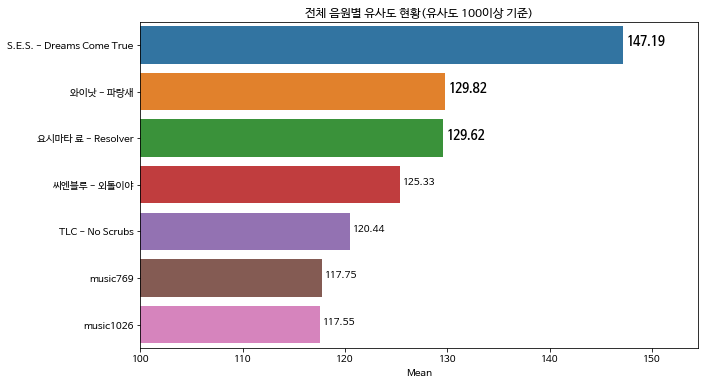

In [ ]:
# 저장된 딕셔너리에서 출력 테스트
show_sim_info_result_2(sim_info_table_ALL['에스파 - Dreams Come True']['보컬 제외_3'], top=3)

In [ ]:
# 2개 음원간 유사도 측정 및 전체 음원 중 Rank 산출 함수 정의
def get_sim_rank(music_a, music_b, col_names, df_name):
  df_rank_all = get_similarity_ALL(music_a, df_name, start_col='Chroma_stft1_mean', end_col='Chroma_stft12_var', col_names=col_names)
  df_rank_all.sort_values(by='Score', ascending=False, inplace=True)
  df_rank_all.reset_index(drop=True, inplace=True)

  rank_num = list(df_rank_all['비교곡']).index(music_b)

  return df_rank_all, rank_num

In [ ]:
# Test 음원(원곡 기준 7곡)과 유사음원간 유사도 측정 및 Rank 테이블 반환 함수 정의
def get_sim_rank_table(df_name, col_names, order='ab'):
  # "rank_table" 생성
  rank_table = pd.read_excel(DIR_PATH + 'test_data/test_data_table.xlsx', index_col=0)

  for idx, row in rank_table.iterrows():
    if rank_table.index[0] != 1: # index 1로 시작하는지 확인
      print('check index')
      return

    # rank 산출 => order 옵션에 따라 music_a, music_b 반영
    if order == 'ab':
      music_a = row['원곡']
      music_b = row['비교곡']
    else:
      music_a = row['비교곡']
      music_b = row['원곡']
    df_score_all, rank_num = get_sim_rank(music_a, music_b, col_names, df_name)

    # 컬럼별 값 추가
    rank_table.loc[idx, 'Rank'] = int(rank_num)
    rank_table.loc[idx, 'Score'] = df_score_all.loc[rank_num, 'Score']
  
  return rank_table

In [ ]:
play_music('MC몽 - 너에게 쓰는 편지', 3, df_total_sepVocal_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
play_music('더더 - It’s you', 3, df_total_sepVocal_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def show_chromagram_with_load(label, order, df_name, chroma_type='stft'):
  music_path = df_name[(df_name['label'] == label) & (df_name['order'] == order)].iloc[0, :]['Path']
  music, sr = librosa.load(music_path, sr=SAMPLING_RATE, duration=None)
  show_chromagram(music, sr, chroma_type)

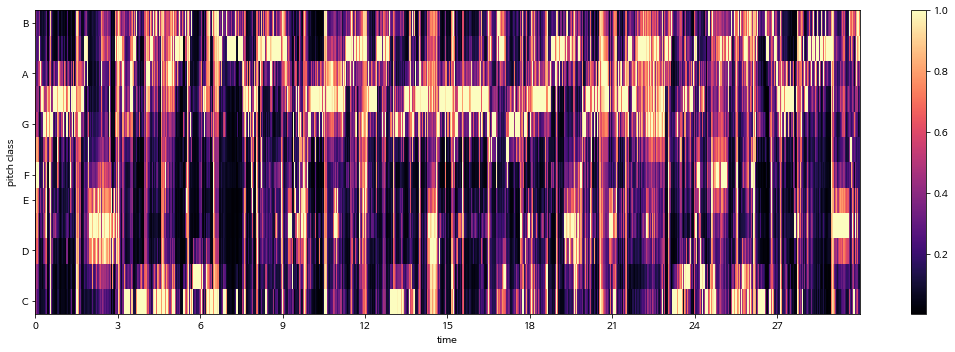

In [ ]:
show_chromagram_with_load('MC몽 - 너에게 쓰는 편지', 3, df_total_trim_v2_norm, 'stft')

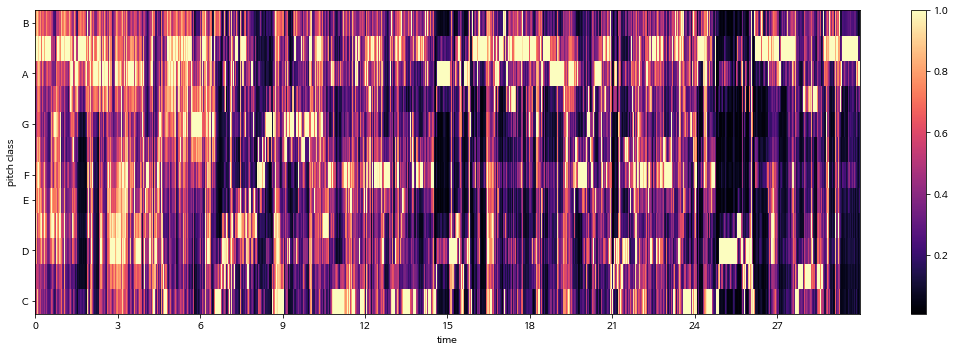

In [ ]:
show_chromagram_with_load('더더 - It’s you', 3, df_total_trim_v2_norm, 'stft')

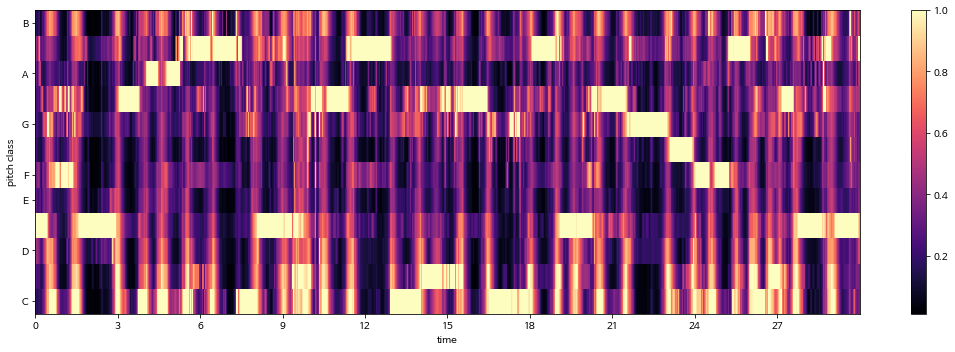

In [ ]:
show_chromagram_with_load('MC몽 - 너에게 쓰는 편지', 3, df_total_trim_v2_norm, 'cqt')

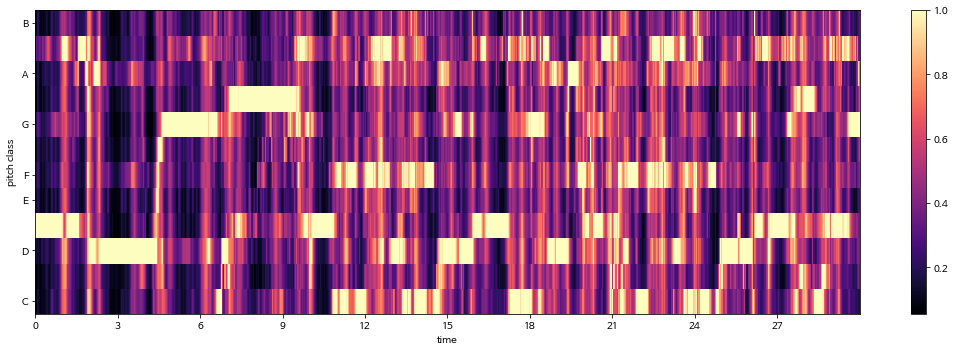

In [ ]:
show_chromagram_with_load('더더 - It’s you', 3, df_total_trim_v2_norm, 'cqt')

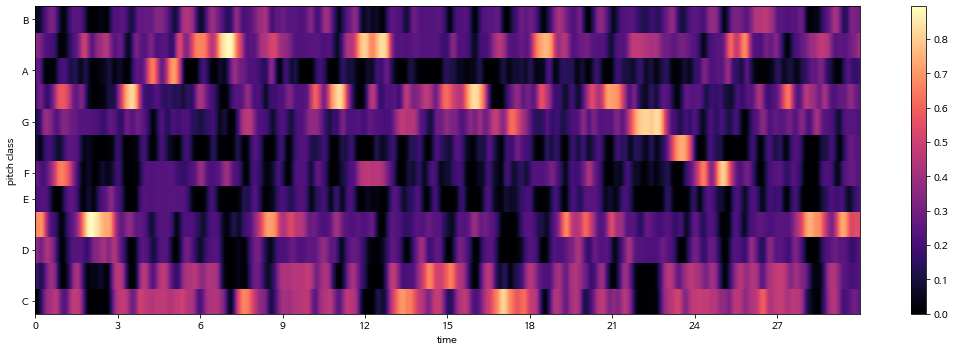

In [ ]:
show_chromagram_with_load('MC몽 - 너에게 쓰는 편지', 3, df_total_trim_v2_norm, 'cens')

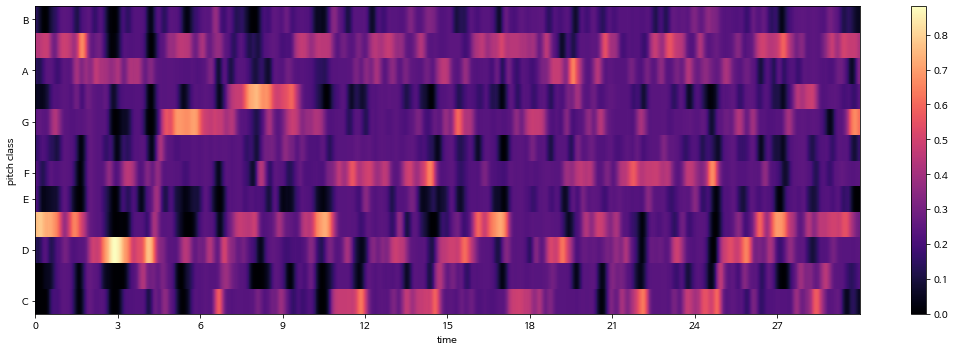

In [ ]:
show_chromagram_with_load('더더 - It’s you', 3, df_total_trim_v2_norm, 'cens')

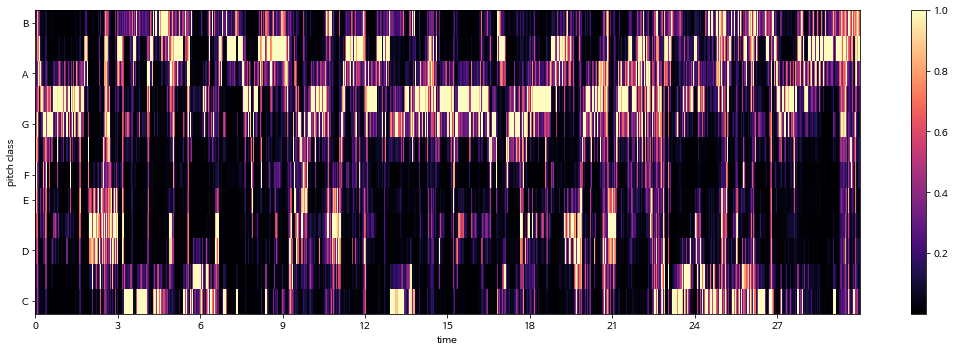

In [ ]:
show_chromagram_with_load('MC몽 - 너에게 쓰는 편지', 3, df_total_sepVocal_trim_v2_norm, 'stft')

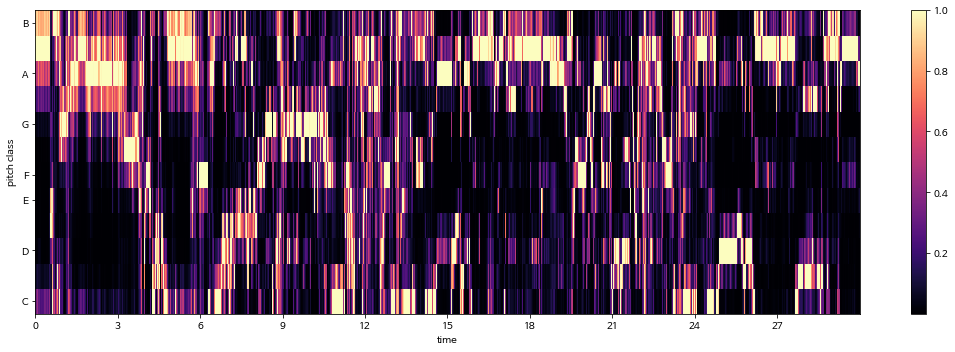

In [ ]:
show_chromagram_with_load('더더 - It’s you', 3, df_total_sepVocal_trim_v2_norm, 'stft')

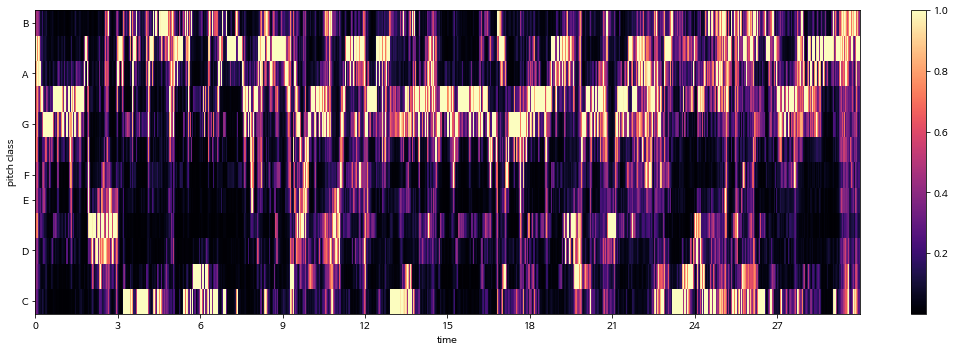

In [ ]:
show_chromagram_with_load('MC몽 - 너에게 쓰는 편지', 3, df_total_sepVocal_trim_v2_norm, 'cqt')

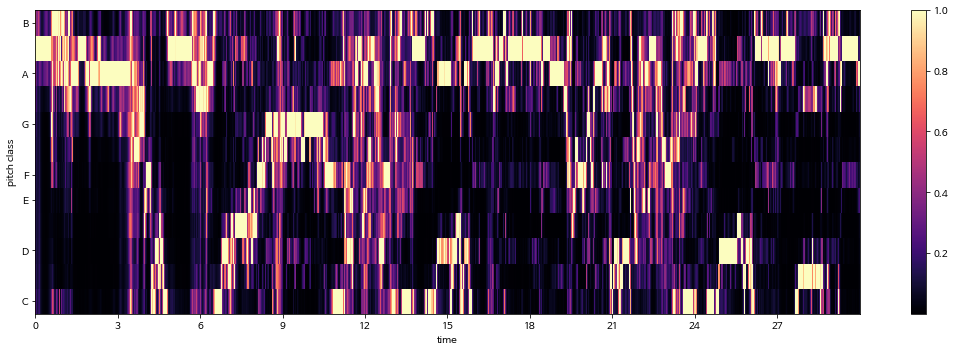

In [ ]:
show_chromagram_with_load('더더 - It’s you', 3, df_total_sepVocal_trim_v2_norm, 'cqt')

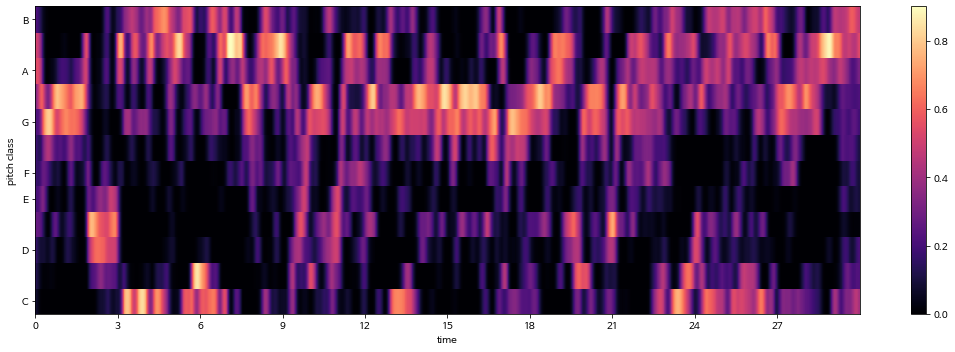

In [ ]:
show_chromagram_with_load('MC몽 - 너에게 쓰는 편지', 3, df_total_sepVocal_trim_v2_norm, 'cens')

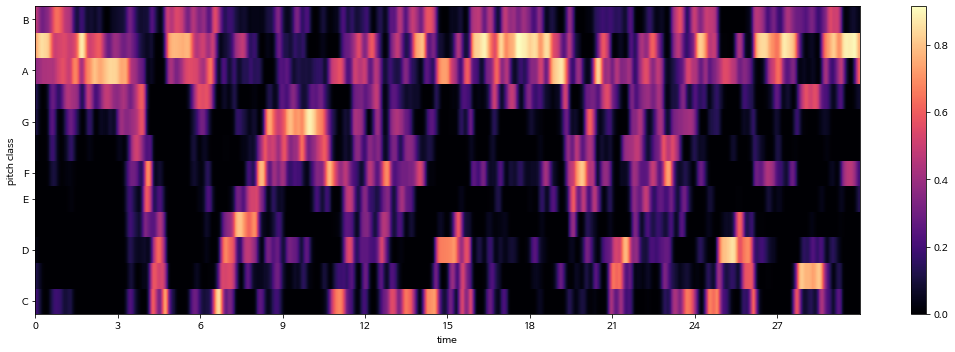

In [ ]:
show_chromagram_with_load('더더 - It’s you', 3, df_total_sepVocal_trim_v2_norm, 'cens')

#### 30초 단위 보컬 추출 음원 이미지 비교

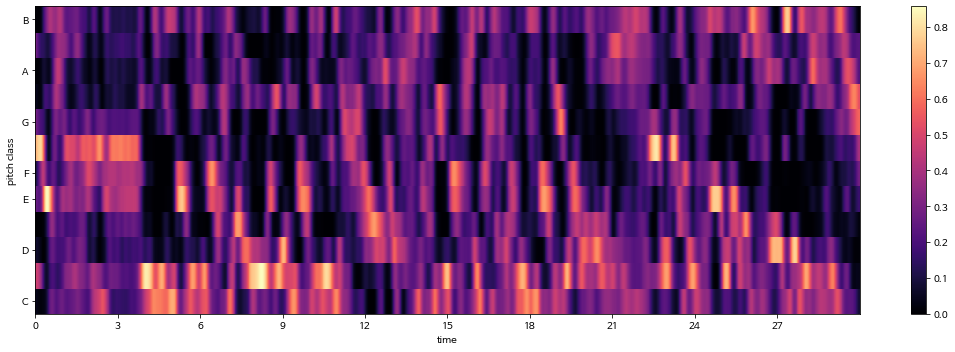

In [ ]:
show_chromagram_with_load('에스파 - Next Level', 3, df_total_sepVocal_trim_v2_norm, 'cens')

# Part 2. K-Means, DBSCAN 통한 Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [ ]:
kmeans = KMeans(n_clusters=100, random_state=42)
kmeans.fit(df_total_trim_v2_norm.loc[:, 'Tempo':])

df_kmeans_v2 = df_total_trim_v2_norm.loc[:, :'Path']
df_kmeans_v2['Cluster_kmeans'] = kmeans.labels_

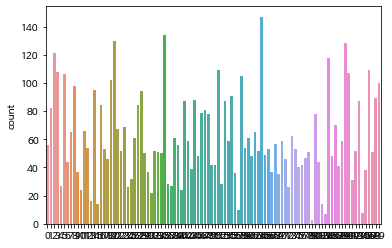

In [ ]:
# K-Means 결과 클러스터별 데이터 분포 시각화
sns.countplot(kmeans.labels_)

In [ ]:
df_kmeans_v2[df_kmeans_v2['label'] == '에스파 - Dreams Come True']['Cluster_kmeans'].value_counts()

48    10
Name: Cluster_kmeans, dtype: int64

In [ ]:
df_kmeans_v2[df_kmeans_v2['Cluster_kmeans'] == 48]['label'].value_counts()

S.E.S. - Dreams Come True    12
에스파 - Dreams Come True       10
와이낫 - 파랑새                     9
씨엔블루 - 외톨이야                   9
더더 - It’s you                 8
FTISLAND - 사랑앓이               8
요시마타 료 - Resolver             4
에스파 - Next Level              3
music724                      2
music551                      2
music660                      2
music914                      2
music1681                     1
music855                      1
music570                      1
music1569                     1
music503                      1
music77                       1
music60                       1
Name: label, dtype: int64

In [ ]:
# 음원별 Clustering 현황 시각화 함수 정의
def show_cluster_means(df_name, music_a, music_b):
  plt.figure(figsize=(8, 4))
  plt.subplot(1,2,1)
  sns.countplot(df_name[df_name['label'] == music_a]['Cluster_kmeans'])
  plt.ylim(0, 15)
  plt.title(music_a)
  plt.subplot(1,2,2)
  sns.countplot(df_name[df_name['label'] == music_b]['Cluster_kmeans'])
  plt.ylim(0, 15)
  plt.title(music_b)
  plt.show()

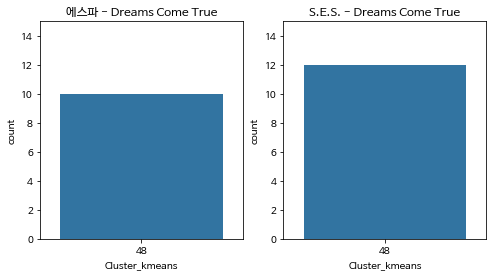

In [ ]:
# 음원별 Clustering 현황 시각화
show_cluster_means(df_kmeans_v2, '에스파 - Dreams Come True', 'S.E.S. - Dreams Come True')

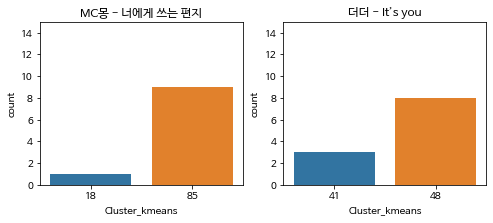

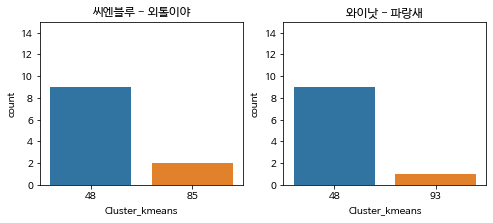

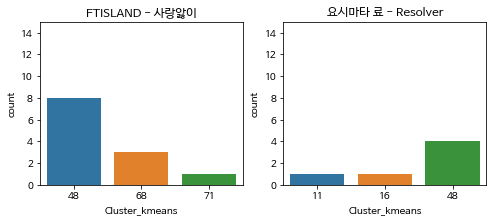

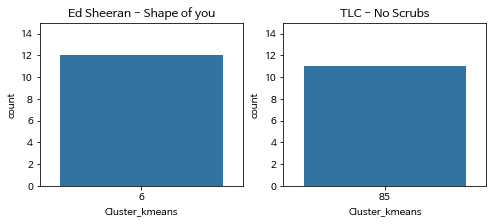

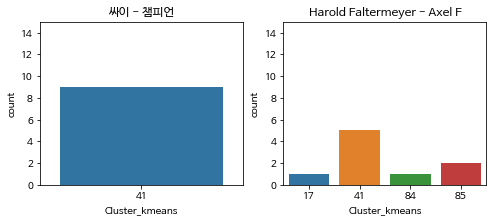

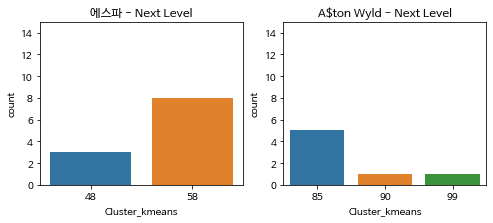

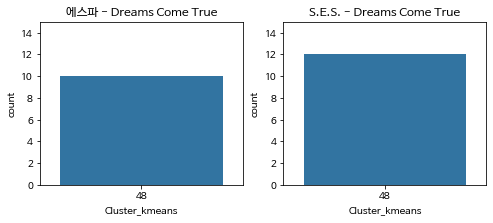

In [ ]:
# 음원별 Clustering 현황 시각화
label_list = []
for i, label in enumerate(list(test_data['Music'])):
  label_list.append(label)
  if len(label_list) == 2:
    show_cluster_means(df_kmeans_v2, label_list[1], label_list[0])
    label_list.clear()

In [ ]:
# n_cluster 50으로 설정
kmeans50 = KMeans(n_clusters=50, random_state=42)
kmeans50.fit(df_total_trim_v2_norm.loc[:, 'Tempo':])

df_kmeans50_v2 = df_total_trim_v2_norm.loc[:, :'Path']
df_kmeans50_v2['Cluster_kmeans'] = kmeans50.labels_

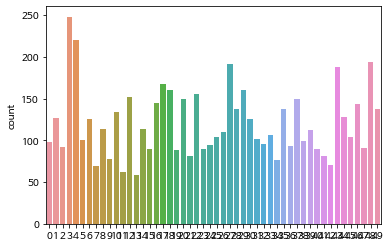

In [ ]:
# K-Means(n_cluster=50) 결과 클러스터별 데이터 분포
sns.countplot(kmeans50.labels_)
plt.show()

In [ ]:
df_kmeans50_v2[df_kmeans50_v2['label'] == '에스파 - Dreams Come True']['Cluster_kmeans'].value_counts()

25    10
Name: Cluster_kmeans, dtype: int64

In [ ]:
df_kmeans50_v2[df_kmeans50_v2['Cluster_kmeans'] == 25]['label'].value_counts()

S.E.S. - Dreams Come True    12
씨엔블루 - 외톨이야                  11
에스파 - Dreams Come True       10
와이낫 - 파랑새                     9
더더 - It’s you                 8
MC몽 - 너에게 쓰는 편지               8
FTISLAND - 사랑앓이               7
TLC - No Scrubs               6
에스파 - Next Level              3
요시마타 료 - Resolver             3
music1845                     2
music660                      2
music914                      2
music651                      2
music53                       2
music1040                     2
music323                      2
music724                      2
music2292                     1
music855                      1
music720                      1
music570                      1
music793                      1
music503                      1
music319                      1
music1339                     1
A$ton Wyld - Next Level       1
music795                      1
music830                      1
Name: label, dtype: int64

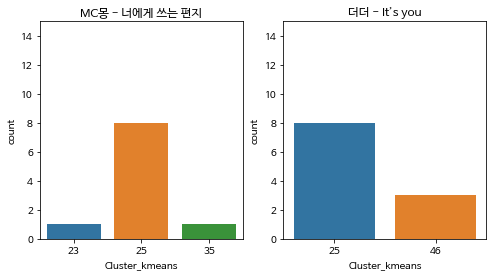

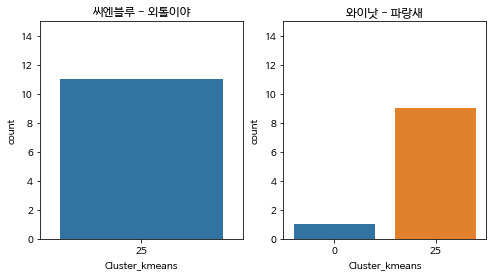

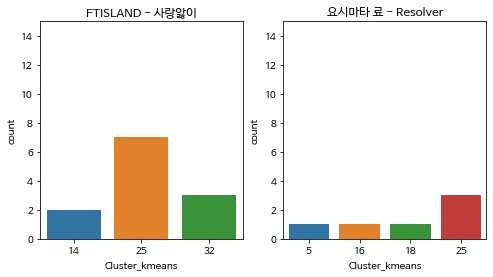

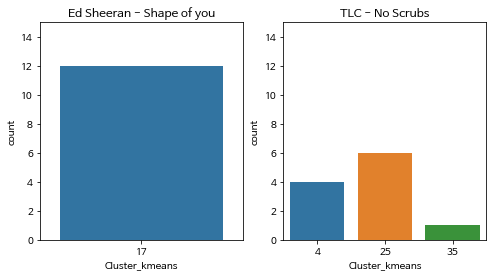

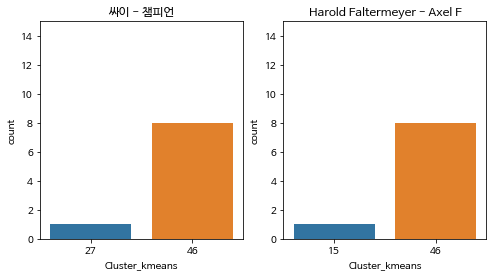

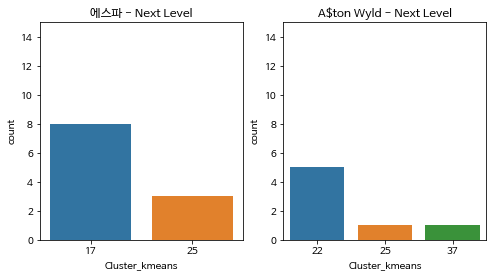

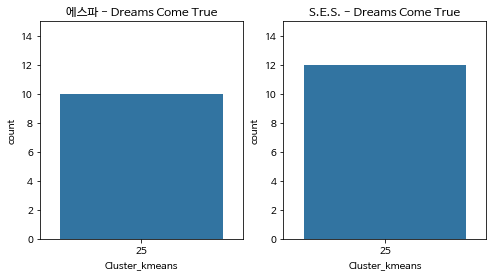

In [ ]:
# 음원별 Clustering 현황 시각화
label_list = []
for i, label in enumerate(list(test_data['Music'])):
  label_list.append(label)
  if len(label_list) == 2:
    show_cluster_means(df_kmeans50_v2, label_list[1], label_list[0])
    label_list.clear()

In [ ]:
# n_cluster 20으로 설정
kmeans20 = KMeans(n_clusters=20, random_state=42)
kmeans20.fit(df_total_trim_v2_norm.loc[:, 'Tempo':])

df_kmeans20_v2 = df_total_trim_v2_norm.loc[:, :'Path']
df_kmeans20_v2['Cluster_kmeans'] = kmeans20.labels_

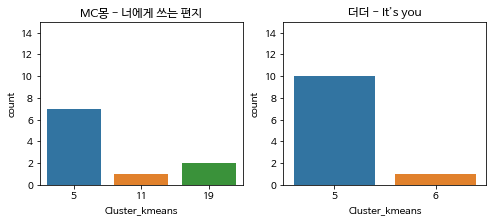

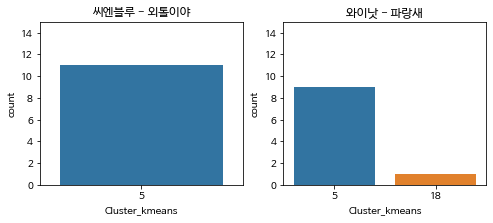

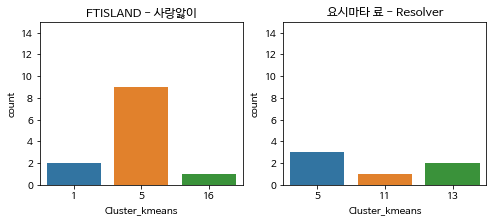

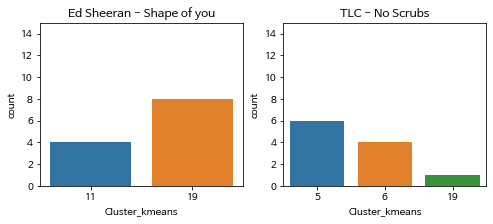

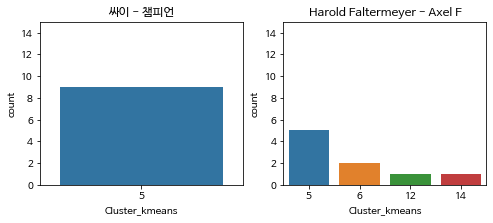

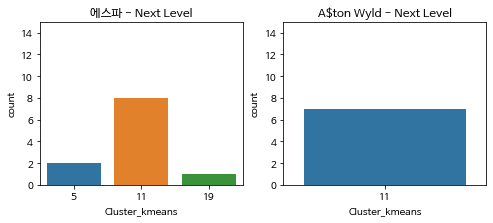

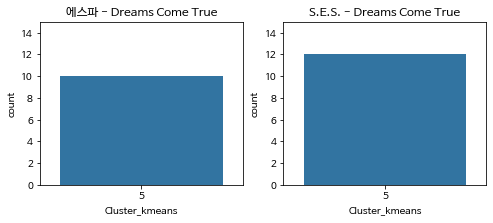

In [ ]:
# 음원별 Clustering 현황 시각화
label_list = []
for i, label in enumerate(list(test_data['Music'])):
  label_list.append(label)
  if len(label_list) == 2:
    show_cluster_means(df_kmeans20_v2, label_list[1], label_list[0])
    label_list.clear()

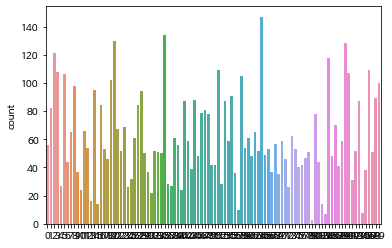

In [ ]:
sns.countplot(kmeans.labels_)
plt.show()

In [ ]:
# kmeans.cluster_centers_ # 군집 중심점 좌표

#### DBSCAN

In [ ]:
dbscan2 = DBSCAN(eps=11.0, min_samples=2)
dbscan2.fit(df_total_trim_v2_norm.loc[:, 'Tempo':])
np.unique(dbscan2.labels_) # DBSCAN 결과 클러스터 개수 확인

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
# DBSCAN 결과 클러스터별 데이터 분포 확인
unique, counts = np.unique(dbscan2.labels_, return_counts=True)
dbscan2_clustering = pd.DataFrame(counts, index=unique, columns=['Count'])
dbscan2_clustering.T

-1     0    1    2    3    4    5   ...   8    9    10   11   12   13   14
Count   25  5983    2    2    3    2    3  ...    2    3    2    2    2    2    2

[1 rows x 16 columns]

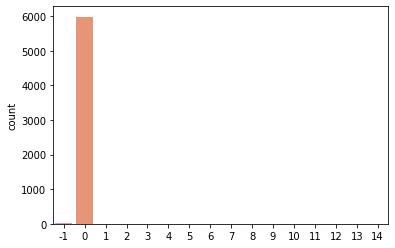

In [ ]:
# DBSCAN 결과 클러스터별 데이터 분포
sns.countplot(dbscan2.labels_)
plt.show()

#### PCA 차원축소 및 음원 데이터 분포 시각화

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_total_trim_v2_norm.loc[:, 'Tempo':])

In [ ]:
pca.explained_variance_ratio_

array([0.1378516 , 0.08812161])

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.22597320849637675

In [ ]:
df_pca_result = pd.DataFrame(pca_result, columns=[f'PCA_component_{i+1}' for i in range(len(pca.components_))])
df_pca_result.head()

PCA_component_1  PCA_component_2
0        -3.964485        -1.855339
1        -2.345081        -0.271460
2        -0.779334        -0.909888
3        -1.829649        -1.623407
4        -1.275404        -0.824862

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(df_pca_result)

df_pca_result['Cluster'] = kmeans.labels_

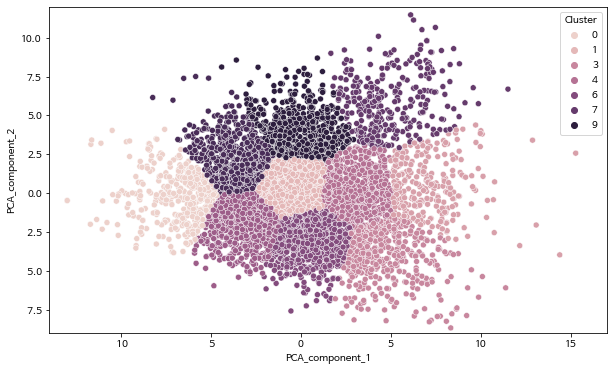

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_pca_result['PCA_component_1'],
                y=df_pca_result['PCA_component_2'],
                hue=df_pca_result['Cluster'])
plt.xlim(-14, 17)
plt.ylim(-9, 12)
plt.show()

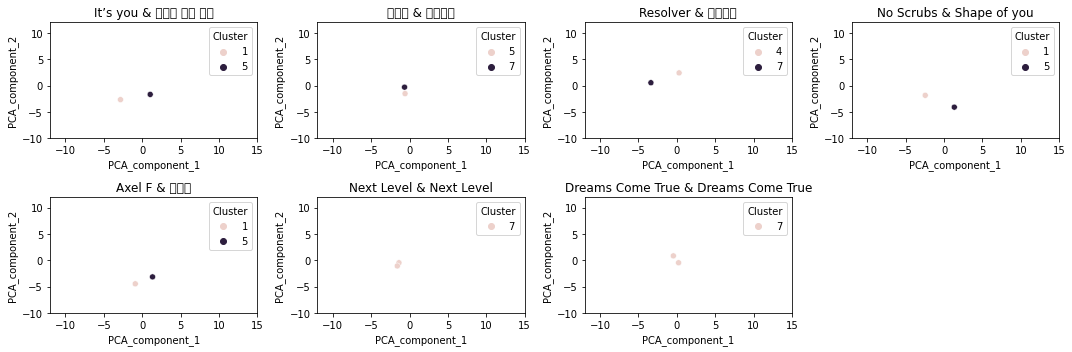

In [ ]:
# plt.figure(figsize=(15,5))

# for i in range(7):
#   plt.subplot(2, 4, i+1)
#   df = df_pca_result.loc[i*2:i*2+1, :]
#   sns.scatterplot(x=df['PCA_component_1'], y=df['PCA_component_2'], hue=df['Cluster'])
#   # plt.xlim(-10000, 25000)
#   # plt.ylim(-4000, 6000)
#   plt.xlim(-12, 15)
#   plt.ylim(-10, 12)
#   plt.title(f'{df_kmeans_v2.loc[i*2,"Music"].split(" - ")[1]} & {df_kmeans_v2.loc[i*2+1,"Music"].split(" - ")[1]}')

# # plt.subplots_adjust(wspace=0.5, hspace=0.5)
# plt.tight_layout()
# plt.show()

#### GMM

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gmm = GaussianMixture(n_components=100, random_state=42)
gmm_labels = gmm.fit_predict(df_total_trim_v2_norm.loc[:, 'Tempo':])

df_gmm_v2 = df_total_trim_v2_norm.loc[:, :'Path']
df_gmm_v2['Cluster_gmm'] = gmm_labels
df_gmm_v2.head(30)

file name  ... Cluster_gmm
0    1_org_0.wav  ...          88
1    1_org_1.wav  ...          36
2    1_org_2.wav  ...          36
3    1_org_3.wav  ...          36
4    1_org_4.wav  ...          36
5    1_org_5.wav  ...          36
6    1_org_6.wav  ...          88
7    1_org_7.wav  ...          99
8    1_org_8.wav  ...          36
9    1_org_9.wav  ...          36
10  1_org_10.wav  ...          88
11   1_sim_0.wav  ...          67
12   1_sim_1.wav  ...          36
13   1_sim_2.wav  ...          36
14   1_sim_3.wav  ...          36
15   1_sim_4.wav  ...          36
16   1_sim_5.wav  ...          36
17   1_sim_6.wav  ...          36
18   1_sim_7.wav  ...          67
19   1_sim_8.wav  ...          36
20   1_sim_9.wav  ...          98
21   2_org_0.wav  ...          36
22   2_org_1.wav  ...          36
23   2_org_2.wav  ...          19
24   2_org_3.wav  ...          36
25   2_org_4.wav  ...          36
26   2_org_5.wav  ...          36
27   2_org_6.wav  ...          36
28   2_org_7.wav  ...          36
29   2_org_8.wav  ...          36

[30 rows x 6 columns]

In [ ]:
gmm = GaussianMixture(n_components=10, random_state=42)
gmm_labels = gmm.fit_predict(df_pca_result)

df_pca_result['Cluster'] = gmm_labels

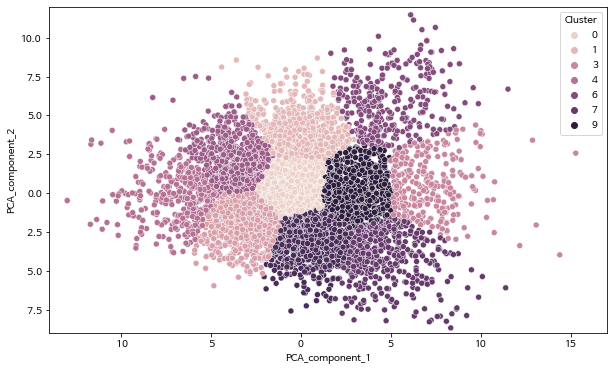

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_pca_result['PCA_component_1'], y=df_pca_result['PCA_component_2'], hue=df_pca_result['Cluster'])
# plt.xlim(-10000, 25000)
# plt.ylim(-4000, 6000)
plt.xlim(-14, 17)
plt.ylim(-9, 12)
plt.show()

# Part 3. Mel Spectrogram 활용

In [ ]:
import skimage.io

In [ ]:
# melspectrogram 시각화 함수 정의
def show_melspectrogram(music, sr):
  S = librosa.feature.melspectrogram(y=music, sr=sr)
  S_db = librosa.power_to_db(S, ref=np.max)
  seconds = len(music)/SAMPLING_RATE

  plt.figure(figsize=(15,5))
  librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
  plt.colorbar()
  plt.tight_layout()
  plt.xlabel('time')
  plt.ylabel('Hz')
  plt.xticks(np.arange(0, seconds, seconds//10)) # 좌표간격 설정
  plt.show()

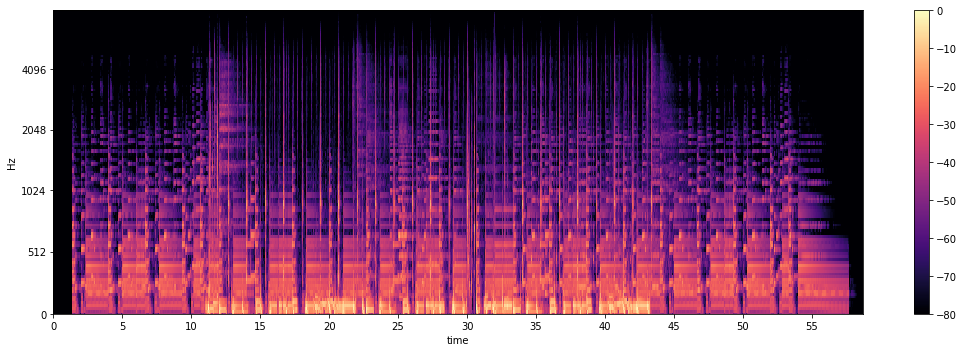

In [ ]:
show_melspectrogram(music, sr)

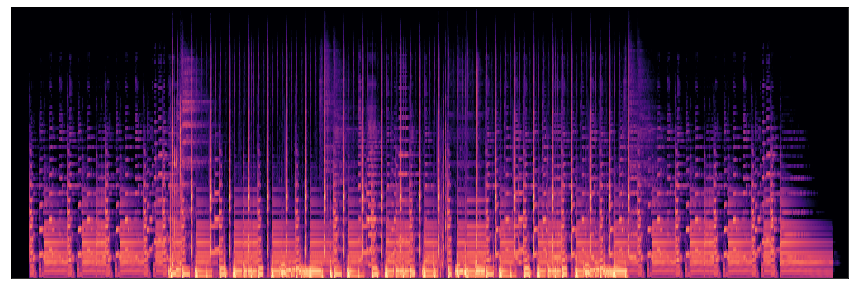

In [ ]:
S = librosa.feature.melspectrogram(y=music, sr=sr)
S_db = librosa.power_to_db(S, ref=np.max)
seconds = len(music)/SAMPLING_RATE

fig = plt.figure(figsize=(15,5))
librosa.display.specshow(S_db, sr=sr, fmax=8000)
fig.savefig(DIR_PATH + f'data_mel/test123.png')

In [ ]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, filename):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=music, sr=sr)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(DIR_PATH + f'data_mel/{filename}', img)

    return img

In [ ]:
test = spectrogram_image(music, sr, 'test.png')

## VGG 기반 특성 추출 및 유사도 측정

In [ ]:
# vgg_vector_5
vgg_vector_5a = pd.read_csv(DIR_PATH + 'vgg_data/sample_music_feature_vector_5.csv')
vgg_vector_5b = pd.read_csv(DIR_PATH + 'vgg_data/music_feature_vector_5.csv')
vgg_vector_5 = pd.concat([vgg_vector_5a, vgg_vector_5b])
vgg_vector_5.reset_index(drop=True, inplace=True)
vgg_vector_5.head(2)

file name      vec0      vec1      vec2  ...  vec508  vec509    vec510    vec511
0   1_org_3  0.016950  0.255308  0.140547  ...     0.0     0.0  0.097595  0.000000
1   1_org_0  0.043325  0.000000  0.000000  ...     0.0     0.0  0.098077  0.015558

[2 rows x 513 columns]

In [ ]:
# label, order 정보확인용 csv 파일 불러오기
df_info = pd.read_csv(DIR_PATH + f'test_data/df_total_trim_v1.csv')
df_info = df_info[['file name', 'label', 'order']]
df_info.head(2)

file name          label  order
0  1_org_0.wav  더더 - It’s you      1
1  1_org_1.wav  더더 - It’s you      2

In [ ]:
for idx, row in vgg_vector_5.iterrows():
  target_name = row['file name'] + '.wav'
  index_num = list(df_info['file name']).index(target_name)

  label_name = df_info.loc[index_num, 'label']
  order_num = df_info.loc[index_num, 'order']

  vgg_vector_5.loc[idx, 'label'] = label_name
  vgg_vector_5.loc[idx, 'order'] = int(order_num)

vgg_vector_5['order'] = list(map(int, vgg_vector_5['order']))
vgg_vector_5.head()

file name      vec0      vec1  ...    vec511          label  order
0   1_org_3  0.016950  0.255308  ...  0.000000  더더 - It’s you      4
1   1_org_0  0.043325  0.000000  ...  0.015558  더더 - It’s you      1
2   2_org_5  0.209582  0.238663  ...  1.622894      와이낫 - 파랑새      6
3   2_org_4  0.000000  0.422271  ...  1.065934      와이낫 - 파랑새      5
4   2_org_3  0.058981  0.063292  ...  0.425971      와이낫 - 파랑새      4

[5 rows x 515 columns]

In [ ]:
vgg_vector_5_norm = get_norm_withVector(vgg_vector_5, 'mms', 'vec0', 'vec511')
vgg_vector_5_norm.head(2)

file name      vec0      vec1  ...    vec511          label  order
0   1_org_3  0.003897  0.042874  ...  0.000000  더더 - It’s you      4
1   1_org_0  0.009962  0.000000  ...  0.000956  더더 - It’s you      1

[2 rows x 515 columns]

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                Mean     Max      Max구간  매칭횟수비율
music1603                  172.58000  175.32  6구간 & 2구간    0.67
music148                   169.70000  169.70  5구간 & 2구간    0.50
씨엔블루 - 외톨이야                168.58125  174.48  3구간 & 7구간    0.73
music2080                  168.17000  171.30  6구간 & 2구간    0.67
music1462                  166.35500  166.80  5구간 & 2구간    0.67
Ed Sheeran - Shape of you  165.80000  165.80  4구간 & 8구간    0.08
music1567                  165.58000  165.58  2구간 & 2구간    0.33
-------------------------------------------------------------------------------------


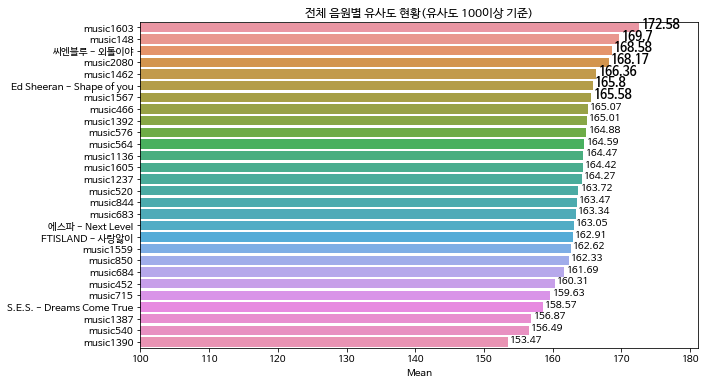

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = vgg_vector_5_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec0' # 시작 컬럼
end_col = 'vec511' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출5', 'all', sim_info_table_ALL) # 결과 저장

In [ ]:
play_music('music1603', 2, df_total_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                   Mean     Max      Max구간  매칭횟수비율
TLC - No Scrubs  166.95  166.95  6구간 & 9구간    0.09
music886         166.20  166.20  6구간 & 3구간    0.33
music902         165.77  165.77  6구간 & 1구간    0.50
music700         165.63  165.63  7구간 & 1구간    0.50
music505         165.30  165.30  8구간 & 2구간    0.50
music710         165.10  165.10  6구간 & 2구간    0.33
music1091        164.93  164.93  8구간 & 2구간    0.50
-------------------------------------------------------------------------------------


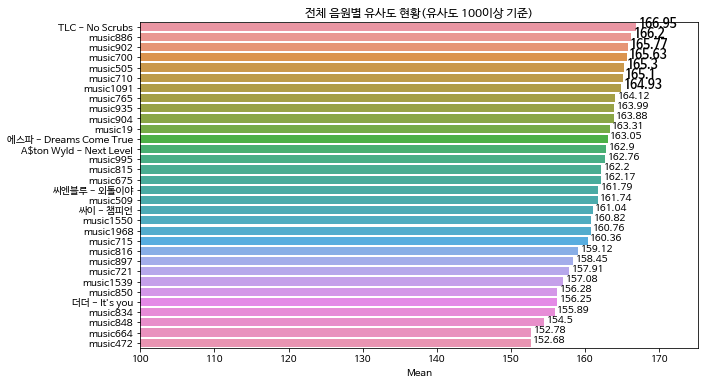

In [ ]:
music_a = '에스파 - Next Level'
df_name = vgg_vector_5_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec0' # 시작 컬럼
end_col = 'vec511' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출5', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                 Mean     Max      Max구간  매칭횟수비율
music2021  174.380000  174.38  7구간 & 3구간    0.33
music1337  172.830000  172.83  7구간 & 2구간    0.33
music675   172.770000  172.77  9구간 & 3구간    0.33
music262   172.280000  172.28  2구간 & 2구간    0.33
music368   171.940000  171.94  6구간 & 2구간    0.33
music507   171.676667  172.34  7구간 & 2구간    1.00
music529   171.070000  172.92  7구간 & 2구간    1.00
-------------------------------------------------------------------------------------


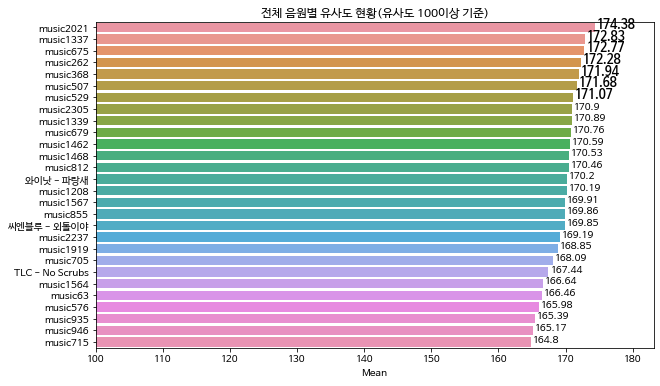

In [ ]:
music_a = '싸이 - 챔피언'
df_name = vgg_vector_5_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec0' # 시작 컬럼
end_col = 'vec511' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출5', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                           Mean     Max       Max구간  매칭횟수비율
music66                 171.060  171.06   4구간 & 1구간    0.50
music1387               170.245  174.58  11구간 & 2구간    0.67
에스파 - Dreams Come True  167.804  169.88   8구간 & 6구간    0.50
music1603               166.185  167.67  11구간 & 2구간    0.67
music1567               163.700  163.70  10구간 & 2구간    0.33
music1462               163.120  163.12  10구간 & 2구간    0.33
씨엔블루 - 외톨이야             160.197  172.47  11구간 & 3구간    0.91
-------------------------------------------------------------------------------------


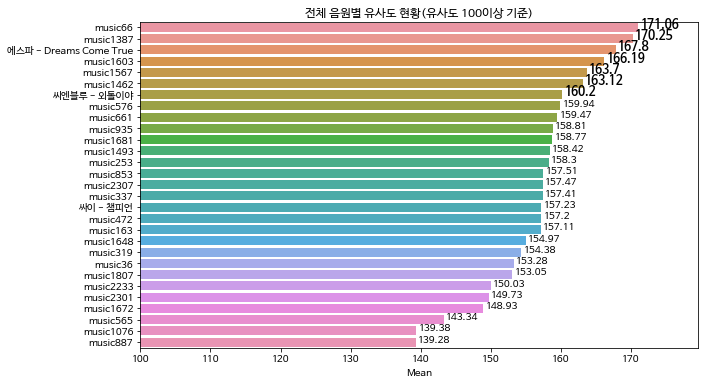

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = vgg_vector_5_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec0' # 시작 컬럼
end_col = 'vec511' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출5', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                              Mean     Max       Max구간  매칭횟수비율
music1998               168.960000  168.96  11구간 & 2구간    0.33
music1581               163.736667  166.15  10구간 & 2구간    1.50
에스파 - Dreams Come True  162.910000  162.91  4구간 & 10구간    0.10
요시마타 료 - Resolver       162.488333  168.29  11구간 & 2구간    1.00
music110                162.465000  163.24   6구간 & 2구간    1.00
music2219               162.420000  162.42   7구간 & 1구간    0.33
더더 - It’s you           162.196000  165.49  7구간 & 10구간    0.45
-------------------------------------------------------------------------------------


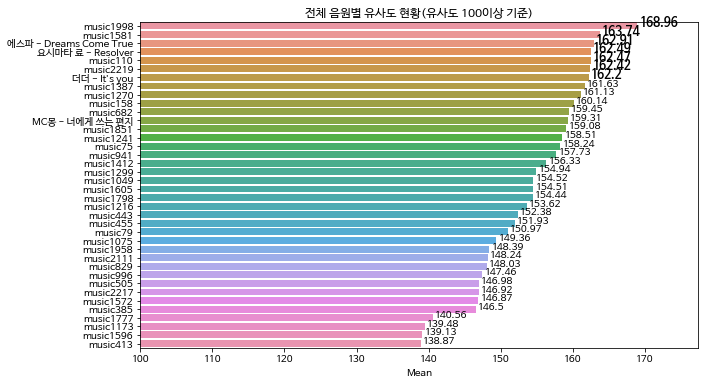

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = vgg_vector_5_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec0' # 시작 컬럼
end_col = 'vec511' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출5', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
music679                   173.203333  177.40   7구간 & 2구간    3.00
에스파 - Dreams Come True     172.825000  174.48   7구간 & 3구간    0.60
music897                   172.740000  172.74  11구간 & 3구간    0.33
music2020                  172.690000  172.69   1구간 & 3구간    0.33
music264                   172.185000  173.05   7구간 & 1구간    1.33
S.E.S. - Dreams Come True  171.510000  173.41  2구간 & 10구간    0.33
music1346                  171.250000  172.70   3구간 & 2구간    1.00
-------------------------------------------------------------------------------------


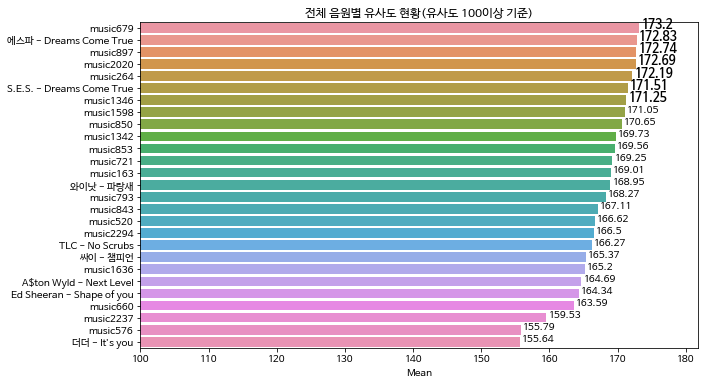

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = vgg_vector_5_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec0' # 시작 컬럼
end_col = 'vec511' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출5', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                    Mean     Max      Max구간  매칭횟수비율
music28          168.210  168.21  2구간 & 2구간    0.33
music1757        166.905  167.06  1구간 & 2구간    0.67
music661         166.280  166.28  2구간 & 2구간    0.33
TLC - No Scrubs  165.695  167.35  1구간 & 1구간    0.36
더더 - It’s you    165.300  165.30  6구간 & 9구간    0.09
music476         165.080  165.08  8구간 & 3구간    0.25
music2215        164.685  164.86  1구간 & 2구간    0.67
-------------------------------------------------------------------------------------


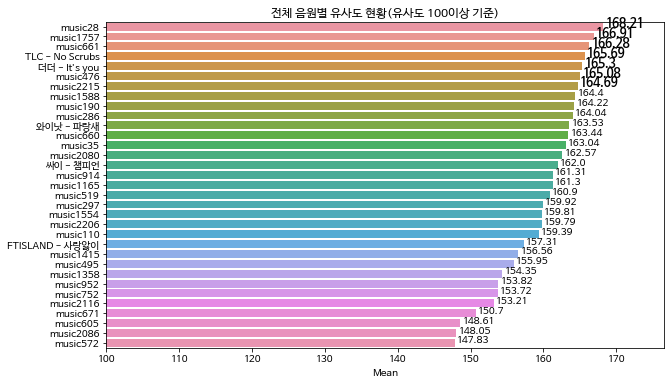

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = vgg_vector_5_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec0' # 시작 컬럼
end_col = 'vec511' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출5', 'all', sim_info_table_ALL) # 결과 저장

In [ ]:
# vgg_vector_3
vgg_vector_3a = pd.read_csv(DIR_PATH + 'vgg_data/sample_music_feature_vector_3.csv')
vgg_vector_3b = pd.read_csv(DIR_PATH + 'vgg_data/music_feature_vector_3.csv')
vgg_vector_3 = pd.concat([vgg_vector_3a, vgg_vector_3b])
vgg_vector_3.reset_index(drop=True, inplace=True)
vgg_vector_3.rename(columns={'Unnamed: 0':'file name'}, inplace=True)
vgg_vector_3.head(2)

file name         vec1         vec2  ...       vec254      vec255      vec256
0   1_org_0  1895.528076  1387.745361  ...  3666.866943   99.556320  459.730072
1   1_org_1  2502.238281  1709.134399  ...  3356.963867  120.462555  596.705994

[2 rows x 257 columns]

In [ ]:
# label, order 정보확인용 csv 파일 불러오기
df_info = pd.read_csv(DIR_PATH + f'test_data/df_total_trim_v1.csv')
df_info = df_info[['file name', 'label', 'order']]
df_info.head(2)

file name          label  order
0  1_org_0.wav  더더 - It’s you      1
1  1_org_1.wav  더더 - It’s you      2

In [ ]:
for idx, row in vgg_vector_3.iterrows():
  target_name = row['file name'] + '.wav'
  index_num = list(df_info['file name']).index(target_name)

  label_name = df_info.loc[index_num, 'label']
  order_num = df_info.loc[index_num, 'order']

  vgg_vector_3.loc[idx, 'label'] = label_name
  vgg_vector_3.loc[idx, 'order'] = int(order_num)

vgg_vector_3['order'] = list(map(int, vgg_vector_3['order']))
vgg_vector_3.head()

file name         vec1         vec2  ...      vec256          label  order
0   1_org_0  1895.528076  1387.745361  ...  459.730072  더더 - It’s you      1
1   1_org_1  2502.238281  1709.134399  ...  596.705994  더더 - It’s you      2
2   1_org_2  2330.031738  1742.783813  ...  577.736816  더더 - It’s you      3
3   1_org_3  2232.042725  1677.359985  ...  545.673645  더더 - It’s you      4
4   1_org_4  2478.492432  1688.656128  ...  563.346436  더더 - It’s you      5

[5 rows x 259 columns]

In [ ]:
vgg_vector_3_norm = get_norm_withVector(vgg_vector_3, 'mms', 'vec1', 'vec256')
vgg_vector_3_norm.head(2)

file name      vec1      vec2  ...    vec256          label  order
0   1_org_0  0.408061  0.577853  ...  0.516862  더더 - It’s you      1
1   1_org_1  0.542402  0.713721  ...  0.671162  더더 - It’s you      2

[2 rows x 259 columns]

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                     Mean     Max       Max구간  매칭횟수비율
씨엔블루 - 외톨이야       193.336  194.56  6구간 & 10구간    0.91
music2318         193.310  193.31   2구간 & 2구간    0.33
music72           192.580  192.58  10구간 & 2구간    0.50
music1500         192.390  192.39   3구간 & 3구간    0.33
TLC - No Scrubs   192.340  193.08   1구간 & 3구간    0.27
에스파 - Next Level  191.845  192.12   1구간 & 6구간    0.18
music1807         191.482  192.30   2구간 & 1구간    1.67
-------------------------------------------------------------------------------------


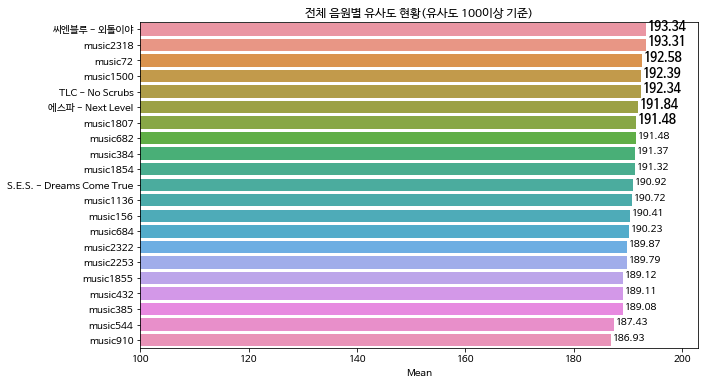

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = vgg_vector_3_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec1' # 시작 컬럼
end_col = 'vec256' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출3', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max       Max구간  매칭횟수비율
TLC - No Scrubs            191.980000  191.98   6구간 & 8구간    0.09
A$ton Wyld - Next Level    191.540556  195.15   3구간 & 3구간    2.57
Ed Sheeran - Shape of you  191.510000  191.51  5구간 & 10구간    0.08
music841                   191.470000  191.47   6구간 & 2구간    0.33
music385                   190.690000  190.69   5구간 & 3구간    0.33
S.E.S. - Dreams Come True  190.090000  190.09   5구간 & 7구간    0.08
에스파 - Dreams Come True     190.081667  192.12   6구간 & 1구간    0.60
-------------------------------------------------------------------------------------


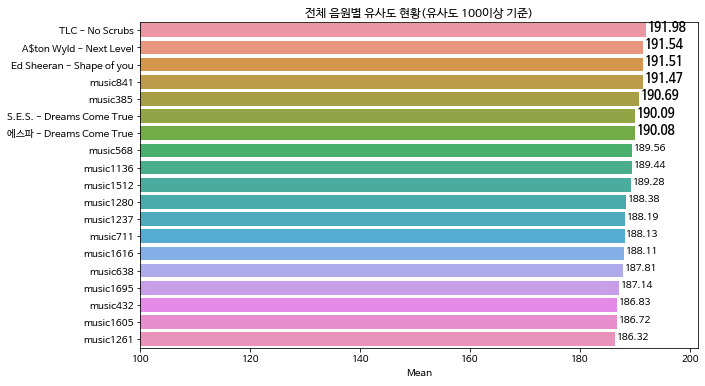

In [ ]:
music_a = '에스파 - Next Level'
df_name = vgg_vector_3_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec1' # 시작 컬럼
end_col = 'vec256' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출3', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                 Mean     Max      Max구간  매칭횟수비율
music1607  193.620000  193.62  7구간 & 2구간    0.50
music507   191.800000  191.80  7구간 & 3구간    0.33
music66    191.690000  191.69  7구간 & 1구간    0.50
music1058  190.726667  192.40  7구간 & 1구간    1.50
music2301  190.275000  192.07  7구간 & 1구간    2.00
music353   190.246667  191.15  3구간 & 2구간    4.00
music606   190.170000  190.17  8구간 & 1구간    0.33
-------------------------------------------------------------------------------------


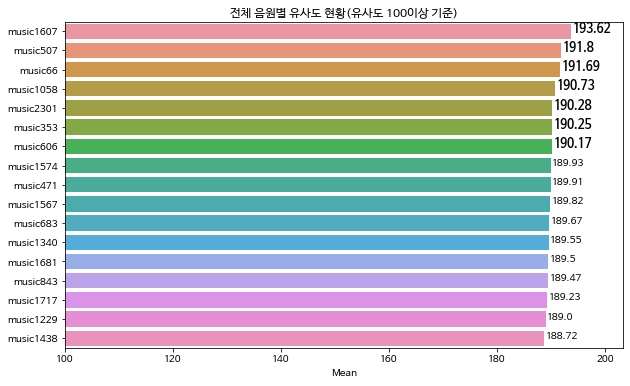

In [ ]:
music_a = '싸이 - 챔피언'
df_name = vgg_vector_3_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec1' # 시작 컬럼
end_col = 'vec256' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출3', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                               Mean     Max       Max구간  매칭횟수비율
music286                 191.620000  191.62  10구간 & 1구간    0.50
music571                 190.870000  192.67  10구간 & 2구간    0.67
A$ton Wyld - Next Level  190.735000  192.15   9구간 & 4구간    0.57
music948                 190.660000  190.66  11구간 & 1구간    0.33
music1807                190.620000  192.39  10구간 & 1구간    1.67
씨엔블루 - 외톨이야              190.525385  191.81   5구간 & 8구간    1.18
에스파 - Dreams Come True   190.223333  191.74  11구간 & 3구간    0.30
-------------------------------------------------------------------------------------


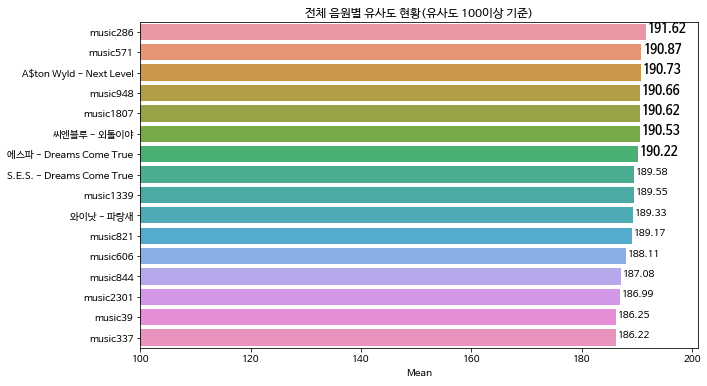

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = vgg_vector_3_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec1' # 시작 컬럼
end_col = 'vec256' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출3', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                         Mean     Max       Max구간  매칭횟수비율
music1977          190.175000  191.54   9구간 & 2구간    1.00
music1581          189.750000  189.75   9구간 & 2구간    0.50
music2000          189.650000  190.74   9구간 & 3구간    2.00
music1556          187.710000  187.71   7구간 & 3구간    0.33
music666           187.192500  192.06   9구간 & 1구간    2.00
더더 - It’s you      186.983333  187.88   3구간 & 9구간    0.27
요시마타 료 - Resolver  186.550000  191.22  11구간 & 2구간    2.00
-------------------------------------------------------------------------------------


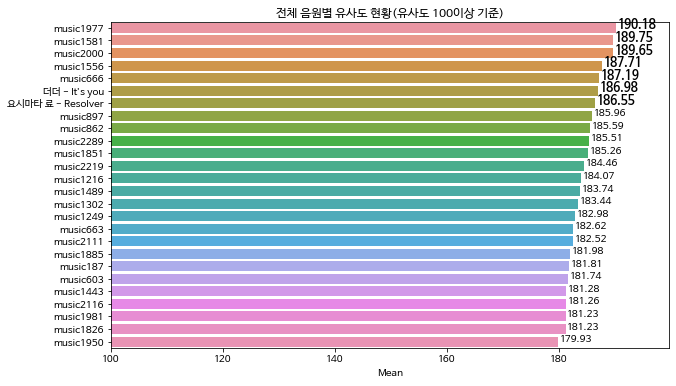

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = vgg_vector_3_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec1' # 시작 컬럼
end_col = 'vec256' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출3', 'all', sim_info_table_ALL) # 결과 저장

In [ ]:
play_music('music2000', 3, df_total_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
play_music('music1977', 2, df_total_trim_v2_norm)

Output hidden; open in https://colab.research.google.com to view.

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                           Mean     Max       Max구간  매칭횟수비율
music1339               193.150  193.27   1구간 & 1구간    0.67
music360                192.910  192.91   2구간 & 2구간    0.33
에스파 - Dreams Come True  192.555  194.56  10구간 & 6구간    1.60
music855                192.550  192.55   2구간 & 2구간    0.33
music798                192.460  192.46   2구간 & 2구간    0.33
music843                191.900  192.50   2구간 & 2구간    1.00
music472                191.900  191.90   8구간 & 1구간    0.50
-------------------------------------------------------------------------------------


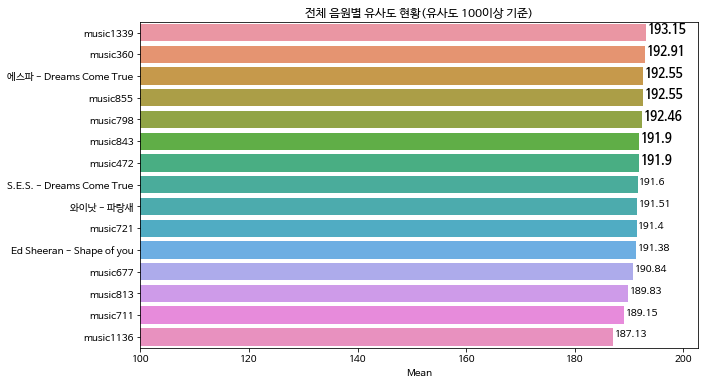

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = vgg_vector_3_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec1' # 시작 컬럼
end_col = 'vec256' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출3', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                 Mean     Max      Max구간  매칭횟수비율
music671   190.050000  190.05  4구간 & 2구간    0.33
music2322  188.590000  188.59  9구간 & 2구간    0.33
music116   188.482500  189.75  4구간 & 3구간    1.33
music1989  188.476667  188.97  4구간 & 2구간    1.00
music1810  188.290000  188.29  4구간 & 1구간    0.33
music297   188.050000  188.05  4구간 & 3구간    0.33
music1897  187.890000  187.89  5구간 & 2구간    0.33
-------------------------------------------------------------------------------------


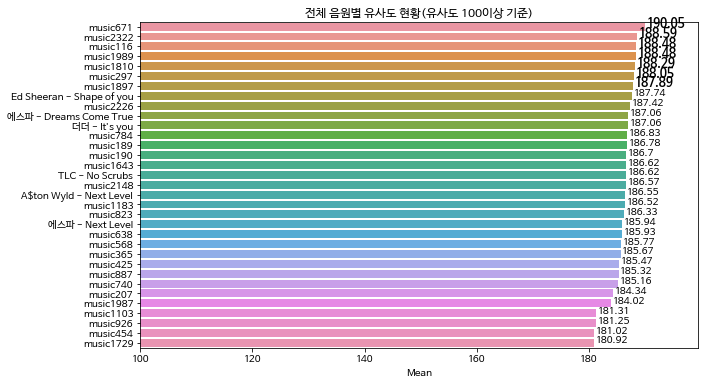

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = vgg_vector_3_norm # VGG 기반 추출된 벡터 정보
start_col = 'vec1' # 시작 컬럼
end_col = 'vec256' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'VGG 추출3', 'all', sim_info_table_ALL) # 결과 저장

In [ ]:
with open(DIR_PATH + 'test_data/sim_info_table_ALL.pkl','wb') as f:
  pickle.dump(sim_info_table_ALL, f)

In [ ]:
with open(DIR_PATH + 'test_data/sim_info_table_ALL.pkl','rb') as f:
  sim_info_table_ALL = pickle.load(f)

In [ ]:
key_list = sim_info_table_ALL.keys()
for k1 in key_list:
  print(k1, end=' => ')
  for k2 in sim_info_table_ALL[k1].keys():
    print(k2, end=', ')
  print()

에스파 - Next Level => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, AE 추출_all_scalingX, AE 추출_all_pca20, AE 추출2_all, 
에스파 - Dreams Come True => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, AE 추출_all, AE 추출2_all, AE 추출_all_pca20, VGG 추출5_all, VGG 추출3_all, 
싸이 - 챔피언 => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, AE 추출2_all, 
Ed Sheeran - Shape of you => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, 
FTISLAND - 사랑앓이 => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 보컬 제외_2, 보컬 제외_3, 원래 음원_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, AE 추출2_all, 
씨엔블루 - 외톨이야 => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 원래 음원_3, 보컬 제외_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, 
MC몽 - 너에게 쓰는 편지 => 원래 음원_1, 보컬 추출_1, 보컬 제외_1, 원래 음원_3, 보컬 제외_3, VGG 추출5_all, VGG 추출3_all, AE 추출_all, 


## 오토인코더 기반 잠재벡터 정보로 유사도 측정 및 검토

In [ ]:
# 특정 음원과 전체 음원간 유사도 측정 함수 정의
def get_similarity_ALL_withVector(label, order, df_norm, start_col, end_col, col_names=False):
  # "score_table_all" 생성
  score_table_all = pd.DataFrame(columns=['원곡', '비교곡', 'Euclidean', 'Cos_sim', 'Pearson_sim'])

  # 특정 음원 데이터 값 추출
  idx_a = df_norm[(df_norm['label'] == label) & (df_norm['order'] == order)].index[0]
  if col_names: # col_names 적용
    a = df_norm[col_names].loc[idx_a, :].values
  else: # start_col 및 end_col 적용
    a = df_norm.loc[idx_a, start_col:end_col].values

  for idx, row in df_norm.iterrows():
    # 비교대상 데이터 값 추출
    if col_names: # col_names 적용
      b = df_norm[col_names].loc[idx, :].values
    else: # start_col 및 end_col 적용
      b = df_norm.loc[idx, start_col:end_col].values

    new_data = {
        '원곡' : f'{label}_{order}',
        '비교곡' : row['label'] + '_' + str(row['order']),
        'Euclidean' : euclidean_dist(a, b),
        'Cos_sim' : cos_similarity(a, b),
        'Pearson_sim' : pearson_similarity(a, b)
    }

    # 행 데이터 추가
    score_table_all = score_table_all.append(new_data, ignore_index=True)
  
  score_table_all['Score'] = round(((100.0 - score_table_all['Euclidean']) * (score_table_all['Cos_sim'] + 1.0) * (score_table_all['Pearson_sim'] + 1.0)) / 2, 2)
  
  return score_table_all

In [ ]:
# 유사도 정보 dict 함수 정의
def get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=10):
  # label별 개수 정보 저장
  label_count = df_total_trim_v2_norm['label'].value_counts()[music_a]

  info_dict = {}
  for i in range(label_count):
    music_a_order = i + 1
    # 특정 음원(music_a)과 전체 음원간 유사도 측정
    df_sim_all = get_similarity_ALL_withVector(music_a, music_a_order, df_name, start_col, end_col)
    df_sim_all.sort_values(by='Score', ascending=False, inplace=True)

    # 유사도가 일정 수준 이상인 음원 정보 저장 => info_dict
    count = 0
    for idx, row in df_sim_all.iterrows():
      music_b = row['비교곡'].split('_')[0]
      music_b_order = row['비교곡'].split('_')[1]
      if music_b == music_a:
        continue
      if row['Score'] < 100.0: # 100점 미만 제외
        break
      if info_dict.get(music_b) == None:
        info_dict[music_b] = {}
      info_dict[music_b][f"{music_a_order}_{music_b_order}"] = row['Score']
      count += 1
      if count >= check_count:
        break
    
    print(f'{i+1}', end=' ')

  return info_dict

In [ ]:
# 전체 컬럼 스케일링 함수 정의
def get_norm_withVector(df, type, start_col, end_col):
  df_copy = df.copy()

  if type == 'mms':
    scaler = MinMaxScaler()
  elif type == 'ss':
    scaler = StandardScaler()
  else:
    print('type error')
    return

  df_copy.loc[:, start_col:end_col] = scaler.fit_transform(df_copy.loc[:, start_col:end_col])
  
  return df_copy

In [ ]:
df_total_sepOther_trim_v2_norm.head(1)

file name  ... MFCC13_var
0  1_orgOther_0.wav  ...  -0.913778

[1 rows x 104 columns]

In [ ]:
latent_vector_AE10 = pd.read_csv(DIR_PATH + 'latent_vector_AE10.csv')
latent_vector_AE10.head()

index  Latent_vec1  ...                      label  order
0  2_sim_7.png          0.0  ...                씨엔블루 - 외톨이야    8.0
1  6_sim_2.png          0.0  ...           에스파 - Next Level    3.0
2  7_org_1.png          0.0  ...  S.E.S. - Dreams Come True    2.0
3  1_sim_8.png          0.0  ...            MC몽 - 너에게 쓰는 편지    9.0
4  4_org_0.png          0.0  ...            TLC - No Scrubs    1.0

[5 rows x 131 columns]

In [ ]:
latent_vector_AE10_norm = get_norm_withVector(latent_vector_AE10, 'ss', 'Latent_vec1', 'Latent_vec128')
latent_vector_AE10_norm.head()

index  Latent_vec1  ...                      label  order
0  2_sim_7.png          0.0  ...                씨엔블루 - 외톨이야    8.0
1  6_sim_2.png          0.0  ...           에스파 - Next Level    3.0
2  7_org_1.png          0.0  ...  S.E.S. - Dreams Come True    2.0
3  1_sim_8.png          0.0  ...            MC몽 - 너에게 쓰는 편지    9.0
4  4_org_0.png          0.0  ...            TLC - No Scrubs    1.0

[5 rows x 131 columns]

In [ ]:
# PCA 검토
pca = PCA(n_components=20, random_state=42)
latent_vector_AE10_PCA = pca.fit_transform(latent_vector_AE10.loc[:, 'Latent_vec1':'Latent_vec128'])

print(np.sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_

0.9999999999999999


array([1.93344068e-01, 1.47942544e-01, 1.27122165e-01, 9.60304678e-02,
       9.09638019e-02, 7.61531961e-02, 4.99750565e-02, 3.93272909e-02,
       3.52397596e-02, 2.80391439e-02, 2.35060495e-02, 2.09065643e-02,
       1.87258285e-02, 1.80265978e-02, 1.22357282e-02, 9.30502281e-03,
       7.76466754e-03, 5.39204704e-03, 1.64481251e-33, 1.64481251e-33])

In [ ]:
# 데이터 프레임 합치기
df_left = latent_vector_AE10.loc[:,['index', 'label', 'order']]
df_right = pd.DataFrame(latent_vector_AE10_PCA, columns=[f'PCA_component_{i+1}' for i in range(len(pca.components_))])
latent_vector_AE10_PCA = pd.concat([df_left, df_right], axis=1)
latent_vector_AE10_PCA.head()

index                      label  ...  PCA_component_19  PCA_component_20
0  2_sim_7.png                씨엔블루 - 외톨이야  ...      1.207602e-16     -3.027706e-17
1  6_sim_2.png           에스파 - Next Level  ...     -2.355119e-17     -3.321909e-17
2  7_org_1.png  S.E.S. - Dreams Come True  ...     -6.614468e-17     -1.669597e-17
3  1_sim_8.png            MC몽 - 너에게 쓰는 편지  ...     -4.273003e-17      1.500840e-17
4  4_org_0.png            TLC - No Scrubs  ...     -5.471475e-17     -3.299299e-18

[5 rows x 23 columns]

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                               Mean     Max         Max구간  매칭횟수비율
music1387                  179.8775  183.93   7구간 & 2.0구간    1.33
S.E.S. - Dreams Come True  178.5400  181.60   8구간 & 4.0구간    0.33
music793                   178.3800  178.38   7구간 & 2.0구간    0.50
Ed Sheeran - Shape of you  177.9100  177.91  7구간 & 11.0구간    0.08
music1403                  176.7800  176.78   3구간 & 2.0구간    0.50
music684                   176.5800  176.58   3구간 & 2.0구간    0.33
music847                   176.4850  183.31   8구간 & 2.0구간    0.67
-------------------------------------------------------------------------------------


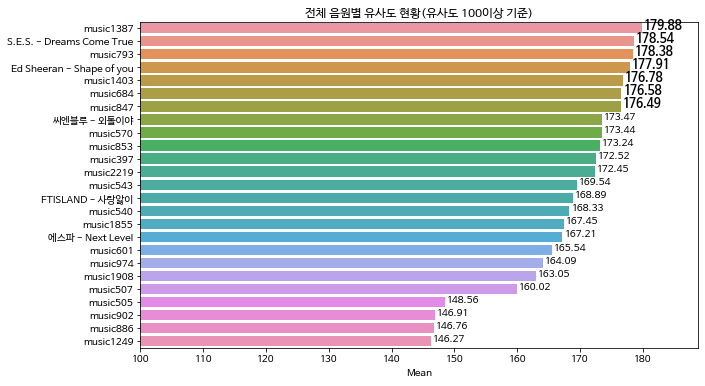

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = latent_vector_AE10_norm # 오토인코더 기반 추출된 벡터 정보(10epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                              Mean     Max          Max구간  매칭횟수비율
music504                   187.180  187.18   11구간 & 3.0구간    0.33
music383                   184.160  184.16   11구간 & 3.0구간    0.33
music2294                  182.630  182.63   11구간 & 3.0구간    0.33
Ed Sheeran - Shape of you  180.210  180.21  11구간 & 12.0구간    0.08
music976                   179.020  179.02   10구간 & 1.0구간    0.50
music816                   176.200  176.20   10구간 & 1.0구간    0.50
씨엔블루 - 외톨이야                176.166  189.85  11구간 & 11.0구간    0.45
-------------------------------------------------------------------------------------


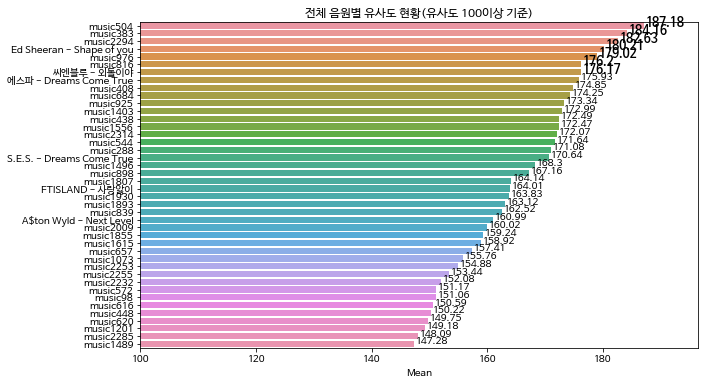

In [ ]:
music_a = '에스파 - Next Level'
df_name = latent_vector_AE10_norm # 오토인코더 기반 추출된 벡터 정보(10epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                 Mean     Max        Max구간  매칭횟수비율
music60    183.450000  183.45  9구간 & 2.0구간    0.50
music678   183.327273  186.66  7구간 & 1.0구간    5.50
music777   182.108571  186.70  8구간 & 2.0구간    2.33
music53    182.098000  185.97  2구간 & 1.0구간    3.33
music661   180.615000  183.67  4구간 & 2.0구간    0.67
music2020  180.560000  181.69  2구간 & 2.0구간    1.00
와이낫 - 파랑새  177.696667  178.83  6구간 & 1.0구간    0.30
-------------------------------------------------------------------------------------


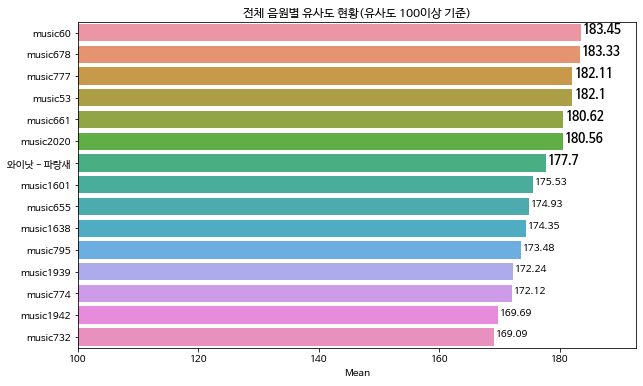

In [ ]:
music_a = '싸이 - 챔피언'
df_name = latent_vector_AE10_norm # 오토인코더 기반 추출된 벡터 정보(10epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                              Mean     Max          Max구간  매칭횟수비율
씨엔블루 - 외톨이야             180.490000  180.49  12구간 & 11.0구간    0.09
music793                180.360000  180.36   11구간 & 2.0구간    0.50
에스파 - Next Level        180.210000  180.21  12구간 & 11.0구간    0.09
music1387               180.096667  188.43   11구간 & 3.0구간    1.00
music684                178.770000  178.77   12구간 & 3.0구간    0.33
에스파 - Dreams Come True  177.910000  177.91   11구간 & 7.0구간    0.10
music39                 172.880000  183.07    3구간 & 2.0구간    3.00
-------------------------------------------------------------------------------------


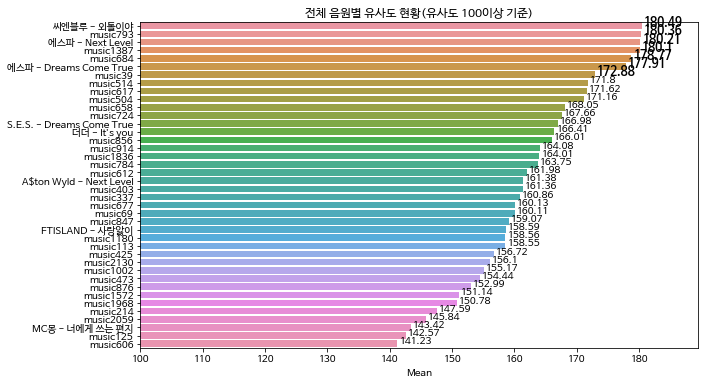

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = latent_vector_AE10_norm # 오토인코더 기반 추출된 벡터 정보(10epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                   Mean     Max         Max구간  매칭횟수비율
music65      183.620000  183.62   1구간 & 1.0구간    0.25
music1829    181.720000  181.72   1구간 & 1.0구간    0.50
music1828    181.335000  183.66   1구간 & 1.0구간    1.00
씨엔블루 - 외톨이야  178.815714  185.87  11구간 & 4.0구간    1.27
music763     177.870000  177.87   1구간 & 1.0구간    0.50
music850     176.336000  183.31   7구간 & 1.0구간    2.50
music570     175.980000  175.98   4구간 & 3.0구간    0.33
-------------------------------------------------------------------------------------


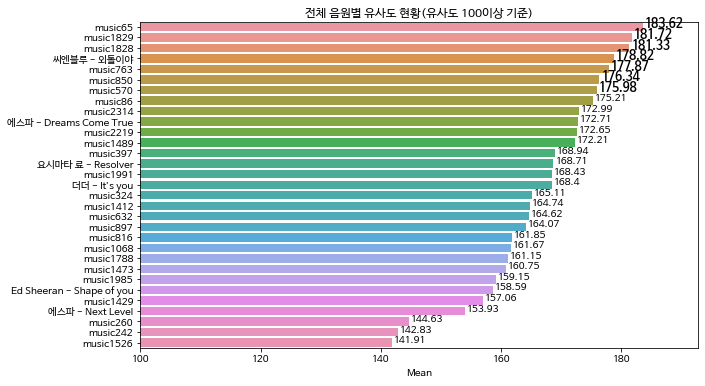

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = latent_vector_AE10_norm # 오토인코더 기반 추출된 벡터 정보(10epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max          Max구간  매칭횟수비율
FTISLAND - 사랑앓이            184.346667  185.87   4구간 & 11.0구간    0.75
S.E.S. - Dreams Come True  183.642500  191.41   10구간 & 4.0구간    0.67
에스파 - Next Level           183.480000  189.85  11구간 & 11.0구간    0.18
music1387                  181.680000  184.01    4구간 & 2.0구간    2.00
music793                   180.835000  180.94    3구간 & 2.0구간    1.00
에스파 - Dreams Come True     177.102500  183.16    3구간 & 7.0구간    0.40
music679                   176.910000  176.91    5구간 & 2.0구간    0.50
-------------------------------------------------------------------------------------


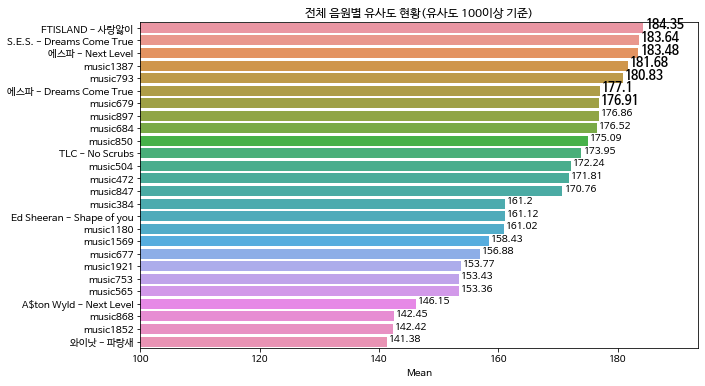

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = latent_vector_AE10_norm # 오토인코더 기반 추출된 벡터 정보(10epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
              Mean     Max        Max구간  매칭횟수비율
music868   189.640  189.64  1구간 & 1.0구간    0.25
music661   184.580  184.58  5구간 & 2.0구간    0.33
music658   182.910  182.91  9구간 & 2.0구간    0.33
music403   182.105  183.40  3구간 & 2.0구간    0.67
music1842  181.830  181.83  1구간 & 1.0구간    0.50
music777   181.620  181.62  9구간 & 2.0구간    0.33
music187   180.400  185.78  9구간 & 2.0구간    0.67
-------------------------------------------------------------------------------------


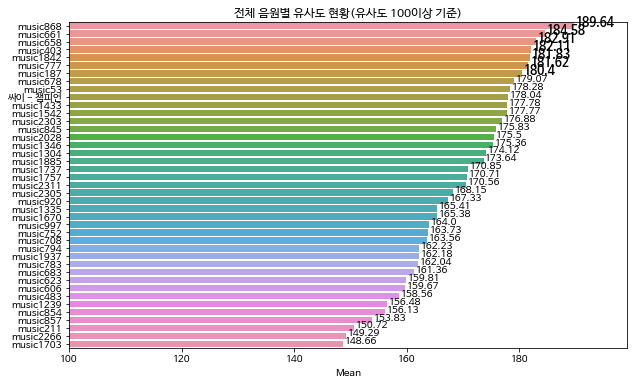

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = latent_vector_AE10_norm # 오토인코더 기반 추출된 벡터 정보(10epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all', sim_info_table_ALL) # 결과 저장

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = latent_vector_AE10 # 오토인코더 기반 추출된 벡터 정보(10epoch), 스케일링 미적용
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max          Max구간  매칭횟수비율
music504                   197.260000  197.26   11구간 & 3.0구간    0.33
Ed Sheeran - Shape of you  197.240000  197.24  11구간 & 12.0구간    0.08
music816                   196.510000  196.51   10구간 & 1.0구간    0.50
씨엔블루 - 외톨이야                196.010000  197.16  11구간 & 11.0구간    0.18
S.E.S. - Dreams Come True  195.460000  196.54    8구간 & 4.0구간    0.25
에스파 - Dreams Come True     195.424286  196.92    8구간 & 3.0구간    0.70
music288                   195.200000  195.20    1구간 & 2.0구간    0.50
-------------------------------------------------------------------------------------


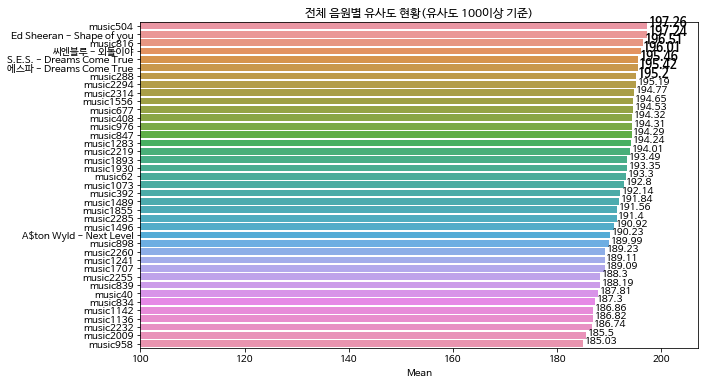

In [ ]:
music_a = '에스파 - Next Level'
df_name = latent_vector_AE10 # 오토인코더 기반 추출된 벡터 정보(10epoch), 스케일링 미적용
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all_scalingX', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max         Max구간  매칭횟수비율
music1387                  186.780000  186.78   7구간 & 2.0구간    0.33
music570                   186.340000  186.34  10구간 & 3.0구간    0.33
music847                   184.770000  188.64   8구간 & 2.0구간    0.67
S.E.S. - Dreams Come True  183.075000  189.25   8구간 & 4.0구간    0.50
music1910                  182.530000  182.53  10구간 & 2.0구간    0.50
music1403                  181.250000  181.25   3구간 & 2.0구간    0.50
씨엔블루 - 외톨이야                179.868824  190.92  7구간 & 10.0구간    1.55
-------------------------------------------------------------------------------------


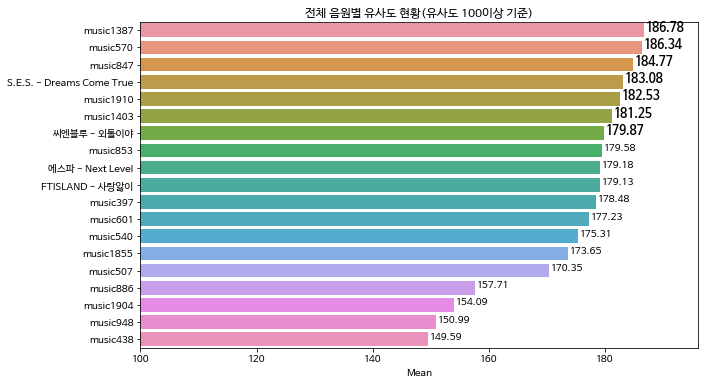

In [ ]:
# PCA 데이터프레임 기준
music_a = '에스파 - Dreams Come True'
df_name = latent_vector_AE10_PCA # 오토인코더 기반 추출된 벡터 정보(10epoch)
start_col = 'PCA_component_1' # 시작 컬럼
end_col = 'PCA_component_20' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all_pca20', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                             Mean     Max          Max구간  매칭횟수비율
Ed Sheeran - Shape of you  192.69  192.69  11구간 & 12.0구간    0.08
music504                   188.90  188.90   11구간 & 3.0구간    0.33
music2294                  187.99  187.99   11구간 & 3.0구간    0.33
music383                   187.15  187.15   11구간 & 3.0구간    0.33
music288                   183.18  183.18    1구간 & 2.0구간    0.50
music408                   182.43  182.43   10구간 & 1.0구간    0.50
music816                   181.59  181.59   10구간 & 1.0구간    0.50
-------------------------------------------------------------------------------------


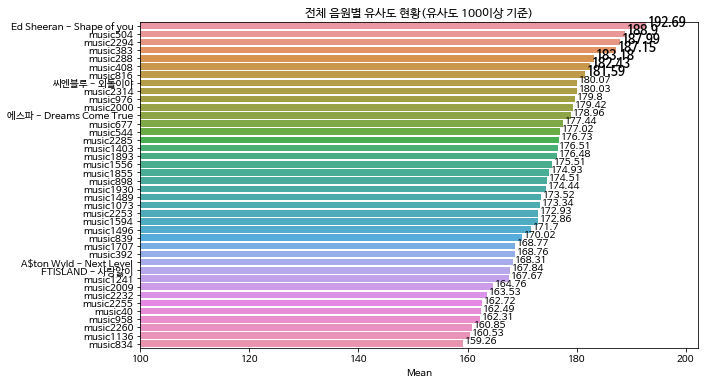

In [ ]:
# PCA 데이터프레임 기준
music_a = '에스파 - Next Level'
df_name = latent_vector_AE10_PCA # 오토인코더 기반 추출된 벡터 정보(10epoch)
start_col = 'PCA_component_1' # 시작 컬럼
end_col = 'PCA_component_20' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출', 'all_pca20', sim_info_table_ALL) # 결과 저장

In [ ]:
latent_vector_AE30 = pd.read_csv(DIR_PATH + 'latent_vector_AE30.csv')
latent_vector_AE30.head()

index  Latent_vec1  ...                      label  order
0  2_sim_7.png          0.0  ...                씨엔블루 - 외톨이야    8.0
1  6_sim_2.png          0.0  ...           에스파 - Next Level    3.0
2  7_org_1.png          0.0  ...  S.E.S. - Dreams Come True    2.0
3  1_sim_8.png          0.0  ...            MC몽 - 너에게 쓰는 편지    9.0
4  4_org_0.png          0.0  ...            TLC - No Scrubs    1.0

[5 rows x 131 columns]

In [ ]:
latent_vector_AE30_norm = get_norm_withVector(latent_vector_AE30, 'ss', 'Latent_vec1', 'Latent_vec128')
latent_vector_AE30_norm.head()

index  Latent_vec1  ...                      label  order
0  2_sim_7.png          0.0  ...                씨엔블루 - 외톨이야    8.0
1  6_sim_2.png          0.0  ...           에스파 - Next Level    3.0
2  7_org_1.png          0.0  ...  S.E.S. - Dreams Come True    2.0
3  1_sim_8.png          0.0  ...            MC몽 - 너에게 쓰는 편지    9.0
4  4_org_0.png          0.0  ...            TLC - No Scrubs    1.0

[5 rows x 131 columns]

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                                 Mean     Max         Max구간  매칭횟수비율
music1387                  177.916667  180.63   7구간 & 2.0구간    1.00
music847                   173.900000  178.84   8구간 & 2.0구간    0.67
music677                   173.590000  173.59   8구간 & 3.0구간    0.33
music1297                  172.570000  172.57   3구간 & 2.0구간    0.33
Ed Sheeran - Shape of you  172.540000  172.54  7구간 & 11.0구간    0.08
music2219                  172.320000  172.32  10구간 & 3.0구간    0.33
music682                   172.200000  172.20  10구간 & 4.0구간    0.25
-------------------------------------------------------------------------------------


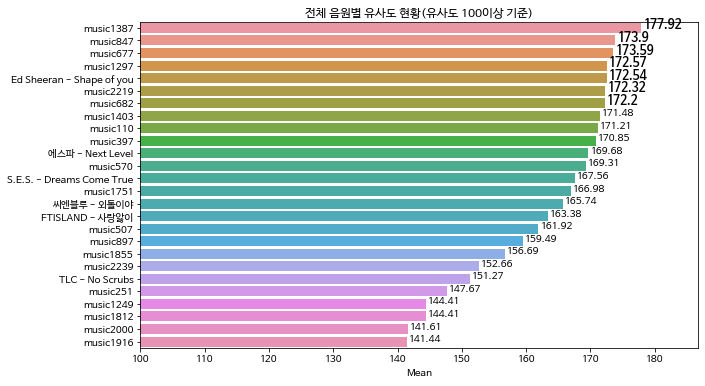

In [ ]:
music_a = '에스파 - Dreams Come True'
df_name = latent_vector_AE30_norm # 오토인코더 기반 추출된 벡터 정보(30epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출2', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                             Mean     Max          Max구간  매칭횟수비율
Ed Sheeran - Shape of you  184.52  184.52  11구간 & 12.0구간    0.08
music383                   183.98  183.98   11구간 & 3.0구간    0.33
music1893                  178.50  178.50    4구간 & 3.0구간    0.33
music976                   176.39  176.39   10구간 & 1.0구간    0.50
music2217                  176.31  176.31   11구간 & 3.0구간    0.33
music816                   176.00  176.00   10구간 & 1.0구간    0.50
music1349                  175.59  175.59   11구간 & 3.0구간    0.33
-------------------------------------------------------------------------------------


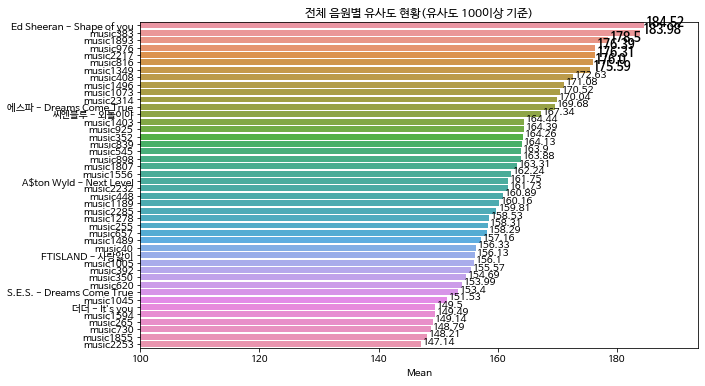

In [ ]:
music_a = '에스파 - Next Level'
df_name = latent_vector_AE30_norm # 오토인코더 기반 추출된 벡터 정보(30epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출2', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 
-------------------------------------------------------------------------------------
                       Mean     Max        Max구간  매칭횟수비율
music678         185.732857  188.30  8구간 & 1.0구간    7.00
music1206        184.360000  184.36  9구간 & 3.0구간    0.33
MC몽 - 너에게 쓰는 편지  182.327692  186.23  2구간 & 6.0구간    1.30
music1542        182.090000  182.09  5구간 & 2.0구간    0.33
music2019        180.843333  181.50  5구간 & 1.0구간    1.50
music683         180.530000  180.53  3구간 & 2.0구간    0.33
music200         178.690000  179.17  7구간 & 1.0구간    1.00
-------------------------------------------------------------------------------------


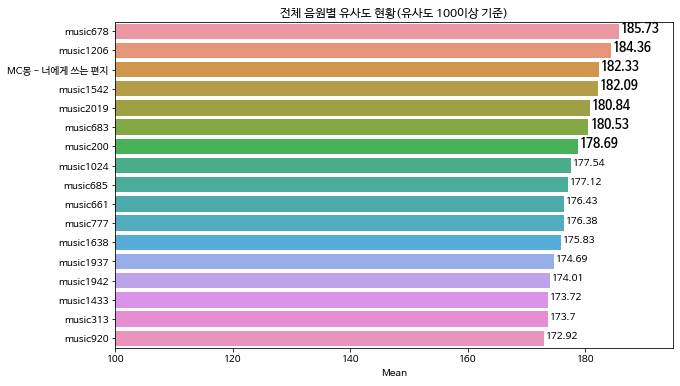

In [ ]:
music_a = '싸이 - 챔피언'
df_name = latent_vector_AE30_norm # 오토인코더 기반 추출된 벡터 정보(30epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출2', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                    Mean     Max          Max구간  매칭횟수비율
씨엔블루 - 외톨이야       185.72  185.72  12구간 & 11.0구간    0.09
에스파 - Next Level  184.52  184.52  12구간 & 11.0구간    0.09
music758          181.03  182.19    2구간 & 2.0구간    0.67
music1387         178.31  189.59   11구간 & 3.0구간    1.00
music1647         178.10  178.10    1구간 & 1.0구간    0.33
music514          177.56  177.56   12구간 & 3.0구간    0.33
music617          177.33  177.33    3구간 & 1.0구간    0.50
-------------------------------------------------------------------------------------


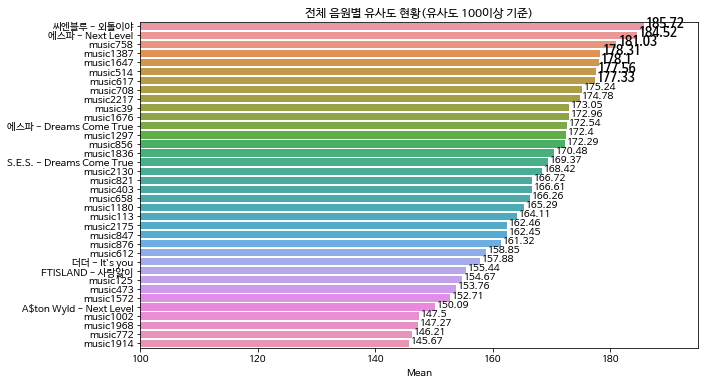

In [ ]:
music_a = 'Ed Sheeran - Shape of you'
df_name = latent_vector_AE30_norm # 오토인코더 기반 추출된 벡터 정보(30epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출2', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 12 
-------------------------------------------------------------------------------------
                           Mean     Max         Max구간  매칭횟수비율
music65                 183.700  183.70   1구간 & 1.0구간    0.25
music1828               181.550  181.55   1구간 & 1.0구간    0.50
music850                179.485  180.42   7구간 & 1.0구간    1.00
music1991               177.740  177.74   4구간 & 3.0구간    0.33
music1489               176.970  176.97   8구간 & 2.0구간    0.33
에스파 - Dreams Come True  176.770  176.77  4구간 & 10.0구간    0.10
music763                176.450  176.45   1구간 & 1.0구간    0.50
-------------------------------------------------------------------------------------


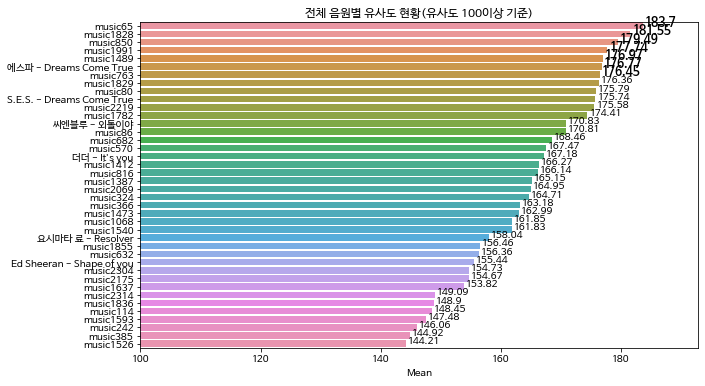

In [ ]:
music_a = 'FTISLAND - 사랑앓이'
df_name = latent_vector_AE30_norm # 오토인코더 기반 추출된 벡터 정보(30epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출2', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 11 
-------------------------------------------------------------------------------------
                                 Mean     Max          Max구간  매칭횟수비율
에스파 - Next Level           190.180000  190.18  11구간 & 11.0구간    0.09
S.E.S. - Dreams Come True  182.483333  192.64   10구간 & 4.0구간    0.75
music1387                  178.205000  181.07   10구간 & 2.0구간    2.00
FTISLAND - 사랑앓이            175.882500  183.93   7구간 & 10.0구간    1.00
music793                   174.550000  174.55    6구간 & 2.0구간    0.50
music897                   171.210000  171.21   11구간 & 3.0구간    0.33
music383                   170.700000  170.70   11구간 & 3.0구간    0.33
-------------------------------------------------------------------------------------


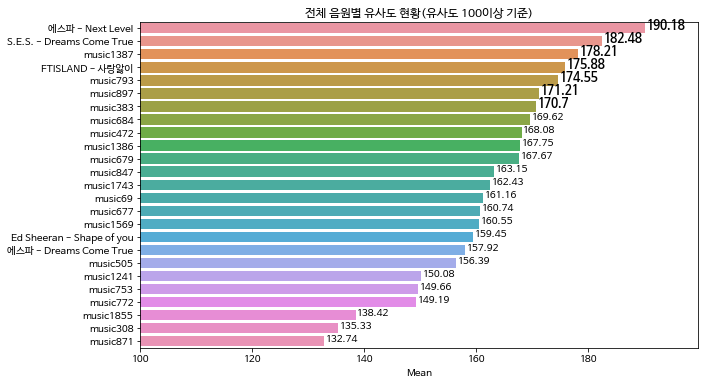

In [ ]:
music_a = '씨엔블루 - 외톨이야'
df_name = latent_vector_AE30_norm # 오토인코더 기반 추출된 벡터 정보(30epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출2', 'all', sim_info_table_ALL) # 결과 저장

1 2 3 4 5 6 7 8 9 10 
-------------------------------------------------------------------------------------
                 Mean     Max        Max구간  매칭횟수비율
music868   191.540000  191.54  1구간 & 1.0구간    0.25
music403   185.856667  186.96  9구간 & 2.0구간    1.00
music661   185.030000  185.03  5구간 & 2.0구간    0.33
music2028  185.003333  187.40  3구간 & 3.0구간    1.00
music2303  183.440000  183.44  5구간 & 2.0구간    0.25
싸이 - 챔피언   183.208571  186.23  6구간 & 2.0구간    0.78
music187   181.998000  189.14  6구간 & 2.0구간    1.67
-------------------------------------------------------------------------------------


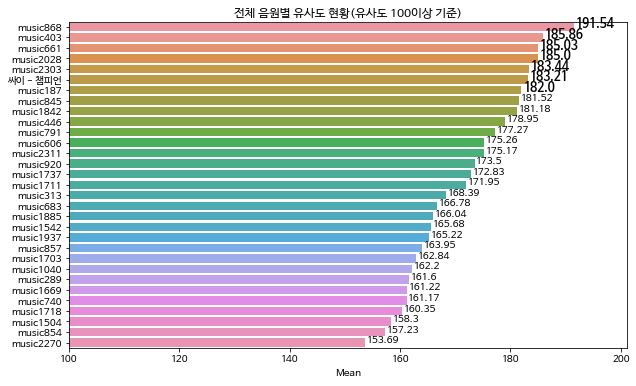

In [ ]:
music_a = 'MC몽 - 너에게 쓰는 편지'
df_name = latent_vector_AE30_norm # 오토인코더 기반 추출된 벡터 정보(30epoch)
start_col = 'Latent_vec1' # 시작 컬럼
end_col = 'Latent_vec128' # 마지막 컬럼

sim_info_dict = get_sim_info_dict_withVector(music_a, df_name, start_col, end_col, check_count=5)
sim_info_table = show_sim_info_result(sim_info_dict, df_name, top=7) # 유사도 측정 결과 시각화
save_sim_info_table(sim_info_table, music_a, 'AE 추출2', 'all', sim_info_table_ALL) # 결과 저장